In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
from ete2 import NCBITaxa
import re
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn import preprocessing
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
import plotly.offline as offline
import matplotlib.backends.backend_pdf
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import itertools
import scipy.stats as ss
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
census=pd.read_table("../TSV/census.tsv")

/home/rcuadrat/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

read_table is deprecated, use read_csv instead, passing sep='\t'.



In [4]:
deep=pd.read_table("../TSV/deepARG_plas_kaiju.tsv")


/home/rcuadrat/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

read_table is deprecated, use read_csv instead, passing sep='\t'.



In [6]:
len(deep)

116425

In [4]:
deep.groupby(["#ARG"])["#ARG"].count().sort_values(ascending=False).to_csv("../all_ARGs_for_curation.tsv",sep="\t")

/home/rcuadrat/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.



In [ ]:
# manual curation

In [140]:
curation=pd.read_csv("../curation_ARGs.tsv",sep="\t")



In [141]:
curation["Quantification"]=curation["Quantification"].str.replace(" ","").str.replace("Yes","yes")

In [142]:
curation["Quantification"].value_counts()

yes    313
no     281
Name: Quantification, dtype: int64

In [143]:
curation["Scenario"]=curation["Scenario"].str.replace(" ","")

In [144]:
curation["Scenario"].value_counts()

v      187
iv      41
i       34
ii      10
iii      9
Name: Scenario, dtype: int64

In [146]:
curation.columns=["#ARG","Type","quantification","scenario"]

In [147]:
curation_yes=curation[curation["quantification"]=="yes"]

In [149]:
deep_yes=pd.merge(deep,curation_yes,on="#ARG")

In [150]:
len(deep_yes)

13163

In [153]:
curation=curation[curation["scenario"]!="i"]

In [154]:
deep=pd.merge(deep,curation,on="#ARG")

In [155]:
len(deep)

99205

In [79]:
#plt.figure(figsize=(12,10))
#deepcu.groupby(["#ARG"])["#ARG"].count().sort_values(ascending=False)[0:30].plot(kind="bar")
#plt.ylabel("Number of ORFs")
#plt.show()

In [156]:
multiple_ARGS=deep.groupby(["contig_id","plasmid"])["#ARG"].count()
multiple_ARGS=pd.DataFrame(multiple_ARGS)
multiple_ARGS=multiple_ARGS[multiple_ARGS["#ARG"]>1]

multiple_ARGS_distribution=pd.DataFrame(multiple_ARGS.groupby(["#ARG","plasmid"])["#ARG"].count())
multiple_ARGS_distribution.columns=["Number of contigs"]
multiple_ARGS_distribution.reset_index(inplace=True)
multiple_ARGS_distribution.columns=["Number of #ARGs","plasmid","Number of contigs"]

In [158]:
full_Table_multiARGS=deep[deep["contig_id"].isin(list(multiple_ARGS.reset_index()["contig_id"]))]
#full_Table_multiARGS[["#ARG","predicted_ARG-class","contig_id","plasmid","taxon_name_kaiju"]].head()
multi_args_contigs=full_Table_multiARGS.groupby("contig_id")["#ARG"].count().sort_values(ascending=False)

In [159]:
full_Table_multiARGS_all=full_Table_multiARGS[["#ARG","predicted_ARG-class","contig_id","plasmid","taxon_name_kaiju"]]

In [160]:
full_Table_multiARGS_all['freq'] = full_Table_multiARGS_all.groupby('contig_id')['contig_id'].transform('count')

/home/rcuadrat/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [161]:
full_Table_multiARGS_all.sort_values("freq",ascending=False,inplace=True)

/home/rcuadrat/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [165]:
#full_Table_multiARGS_all[full_Table_multiARGS_all["plasmid"]=="yes"]

In [163]:
multi_args_contigs.head()

contig_id
TARA_ANW-k99_1343221     11
TARA_ANE-k99_4428305     11
TARA_ION-k99_13063158    10
TARA_PSW-k99_8257882     10
TARA_PON-k99_11447815     9
Name: #ARG, dtype: int64

In [167]:
multiple_ARGS_distribution[multiple_ARGS_distribution["plasmid"]=="yes"]

Number of #ARGs plasmid  Number of contigs
1                2     yes                689
3                3     yes                 37
5                4     yes                 13
7                5     yes                  2

In [170]:
multiple_ARGS_distribution["Number of contigs"].sum()

4804

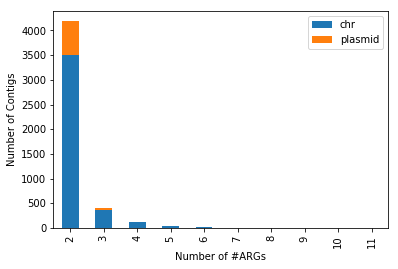

In [164]:
multiple_ARGS_distribution.set_index(["Number of #ARGs","plasmid"]).unstack().plot(kind="bar",stacked=True)
plt.legend(["chr","plasmid"])
plt.ylabel("Number of Contigs")
plt.show()

In [180]:
argcount=pd.DataFrame(deep.groupby(["#ARG"])["#ARG"].count().sort_values(ascending=False))
argcount.columns=["counts"]
argcount.reset_index(inplace=True)
argcount=pd.merge(argcount,deep[["#ARG","predicted_ARG-class"]])
argcount.drop_duplicates(inplace=True)

In [261]:
# plt.figure(figsize=(12,10))
# sns.boxplot(argcount["predicted_ARG-class"],argcount["counts"])
# plt.ylabel("Number of ORFs")
# plt.xticks(rotation=90)
# plt.show()

In [260]:
# plt.figure(figsize=(12,10))

# argcount.groupby("predicted_ARG-class")["counts"].mean().sort_values(ascending=False).plot(kind="bar")

# plt.show()

In [262]:
# plt.figure(figsize=(12,10))

# deep.groupby(["predicted_ARG-class"])["#ARG"].count().sort_values(ascending=False)[0:50].plot(kind="bar")

# plt.show()

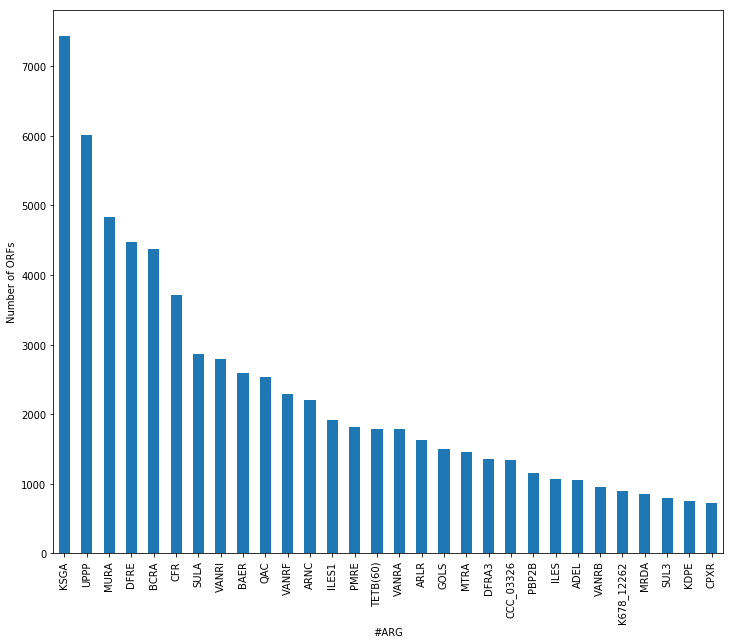

In [171]:
plt.figure(figsize=(12,10))
deep.groupby(["#ARG"])["#ARG"].count().sort_values(ascending=False)[0:30].plot(kind="bar")
plt.ylabel("Number of ORFs")
plt.show()

In [173]:
deep_plas=deep[deep["plasmid"]=="yes"]

In [176]:
len(deep_plas)

24567

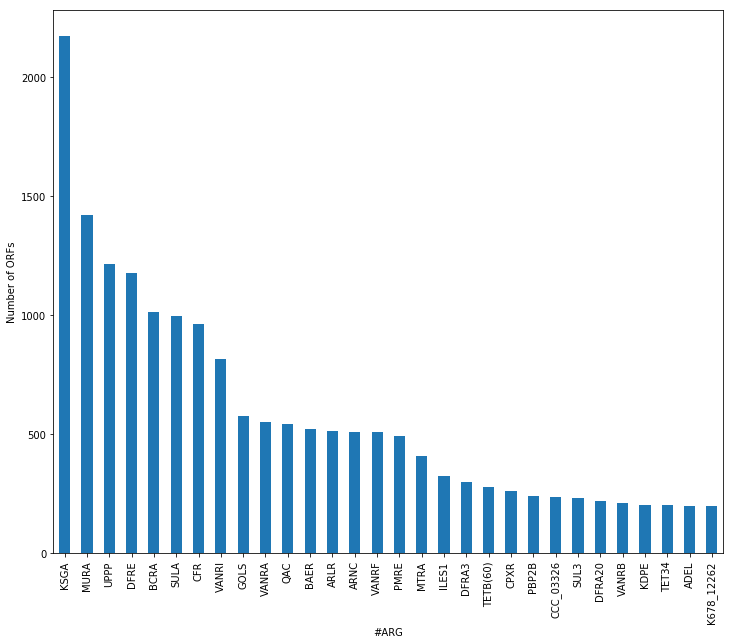

In [174]:
#just in plasmids

plt.figure(figsize=(12,10))
deep_plas.groupby(["#ARG"])["#ARG"].count().sort_values(ascending=False)[0:30].plot(kind="bar")
plt.ylabel("Number of ORFs")
plt.show()

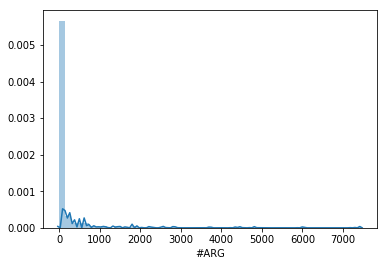

In [178]:
sns.distplot(deep.groupby(["#ARG"])["#ARG"].count().sort_values(ascending=False), hist=True, kde=True)
plt.show()

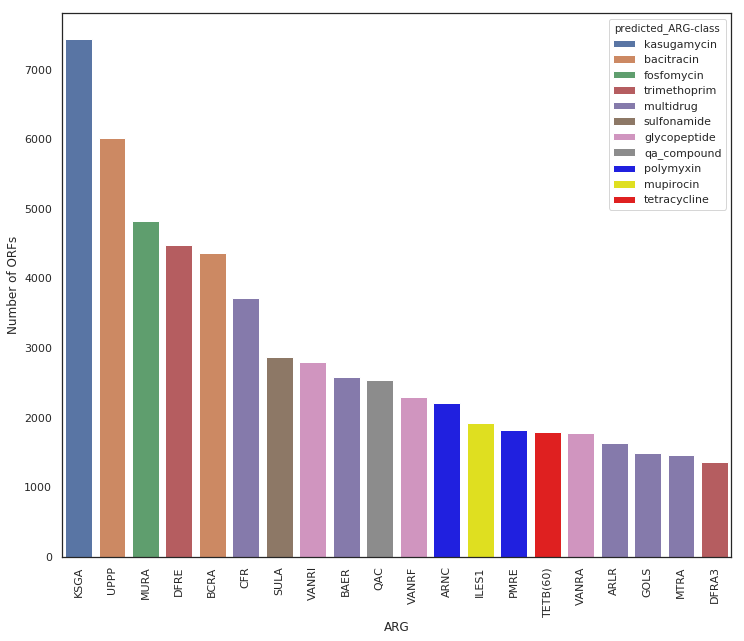

In [181]:
sns.set(style="white")
plt.figure(figsize=(12,10))

sns.barplot(data=argcount[0:20], y="counts",x="#ARG",hue="predicted_ARG-class",dodge=False,palette=["C0", "C1", "C2","C3","C4","C5","C6","C7","blue","yellow","red","k","green"])
plt.xticks(rotation=90)

plt.ylabel("Number of ORFs")
plt.xlabel("ARG")

plt.show()

In [ ]:
# I WILL HAVE TO REMOVE THE TRASH GENES FROM HERE AND FOLLOW THE STATS (from deepARG and RPKG)

In [182]:
all_RPKG=pd.read_table("../TSV/RPKG_all.tsv")

/home/rcuadrat/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

read_table is deprecated, use read_csv instead, passing sep='\t'.



In [183]:
all_results=pd.merge(deep_yes,all_RPKG,on=["ORF_ID"])


In [184]:
ARGS_RPKG=all_results.groupby(["#ARG"])[[x for x in all_results.columns if "ERR" in x]].sum()


In [185]:
ARGS_CLASS_RPKG=pd.merge(ARGS_RPKG.reset_index(),deep[["#ARG","predicted_ARG-class"]],on="#ARG")


In [186]:
class_RPKG=all_results.groupby(["predicted_ARG-class"])[[x for x in all_results.columns if "ERR" in x]].sum()
new_classes_RPKG=class_RPKG.T
new_classes_RPKG.reset_index(inplace=True)
new_classes_RPKG["run_id"]=new_classes_RPKG["index"]#.str.replace("_FPKM","")
new_classes_RPKG.drop("index",axis=1,inplace=True)

In [187]:
meta=pd.read_table("../TSV/meta_runs.tsv")
meta.rename(columns={"value":"run_id"},inplace=True)
#meta["Environmental_Feature"]=meta["Environmental Feature"].str.split(")",expand=True)[0].str.split("(",expand=True)[1]
meta["Environmental_Feature"]=meta["Environmental Feature"].str.split(")",expand=True)[1].str.split("(",expand=True)[0]
meta["fraction"]=meta["Size fraction lower threshold [micrometre]"].astype(str)+" - "+ meta["Size fraction upper threshold [micrometre]"].astype(str)
meta.rename(columns={"Biogeographic biomes (Longhurst 2007)":"Biogeographic_biomes"},inplace=True)
meta["Ocean_sea_regions"]=meta["Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]"].str.split(")",expand=True)[1].str.split("[",expand=True)[0]
#meta["Marine_provinces"]=meta["Marine provinces  (Longhurst 2007)"].str.split(")",expand=True)[0].str.split("(",expand=True)[1]
meta["Marine_provinces"]=meta["Marine provinces  (Longhurst 2007)"].str.split(")",expand=True)[1].str.split("[",expand=True)[0]
meta2=pd.read_table("../TSV/meta2.tsv")
meta2.rename(columns={"PANGAEA Sample ID":"PANGAEA sample identifier"},inplace=True)
meta=pd.merge(meta,meta2,on="PANGAEA sample identifier")

/home/rcuadrat/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

read_table is deprecated, use read_csv instead, passing sep='\t'.

/home/rcuadrat/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

read_table is deprecated, use read_csv instead, passing sep='\t'.



In [188]:
classes_RPKG_env=pd.merge(new_classes_RPKG,meta[["run_id","Marine_provinces","Environmental_Feature","Ocean_sea_regions","fraction","Biogeographic_biomes"]],on="run_id")


In [189]:
classes_RPKG_env_novirus=classes_RPKG_env[(classes_RPKG_env["fraction"]!="< - 0.22")&(classes_RPKG_env["fraction"]!="0.1 - 0.22")]

In [190]:
classes_RPKG_env_novirus.head()

aminoglycoside  bacitracin  beta_lactam  bleomycin  chloramphenicol  \
0        0.282903    1.127046     3.963082        0.0         0.186538   
1        0.106133    1.152943     4.359501        0.0         0.479386   
2        0.378437    0.917222     1.964179        0.0         0.135554   
3        0.036411    1.507609     3.884049        0.0         0.081460   
4        0.159820    1.132001     3.587549        0.0         0.101867   

   fosfomycin  fosmidomycin  macrolide-lincosamide-streptogramin  multidrug  \
0    0.039173      0.143550                             0.712873  14.914945   
1    0.031877      0.276274                             0.599497  15.136831   
2    0.022523      0.042590                             0.589470   7.844961   
3    0.010889      0.079724                             0.219694  14.260157   
4    0.001007      0.002764                             0.308320   7.167263   

    peptide  ...  rifampin  sulfonamide  tetracycline  triclosan     run_id  \
0  0.027541  ...  0.000000     0.131258     26.762616   0.544225  ERR599018   
1  0.101546  ...  0.000503     0.064727     32.659787   0.485005  ERR598955   
2  0.010069  ...  0.002042     0.062986     44.504099   0.185128  ERR594306   
3  0.188110  ...  0.000844     0.128784     27.033579   0.191685  ERR599173   
4  0.007724  ...  0.000000     0.146138     15.599981   0.163002  ERR594339   

                                    Marine_provinces  \
0                   Eastern Africa Coastal Province    
1         North Atlantic Subtropical Gyral Province    
2   South Pacific Subtropical Gyre Province, Nort...   
3                 Benguela Current Coastal Province    
4   South Pacific Subtropical Gyre Province, Nort...   

              Environmental_Feature       Ocean_sea_regions     fraction  \
0   deep chlorophyll maximum layer            Indian Ocean    0.22 - 3.0   
1              surface water layer    North Atlantic Ocean    0.22 - 1.6   
2              surface water layer     South Pacific Ocean    0.45 - 0.8   
3              surface water layer    South Atlantic Ocean    0.22 - 3.0   
4              surface water layer     South Pacific Ocean   0.22 - 0.45   

  Biogeographic_biomes  
0       Coastal Biome   
1     Westerlies Biome  
2         Trades Biome  
3       Coastal Biome   
4         Trades Biome  

[5 rows x 23 columns]

In [191]:
out="../no_virome_results_new/"

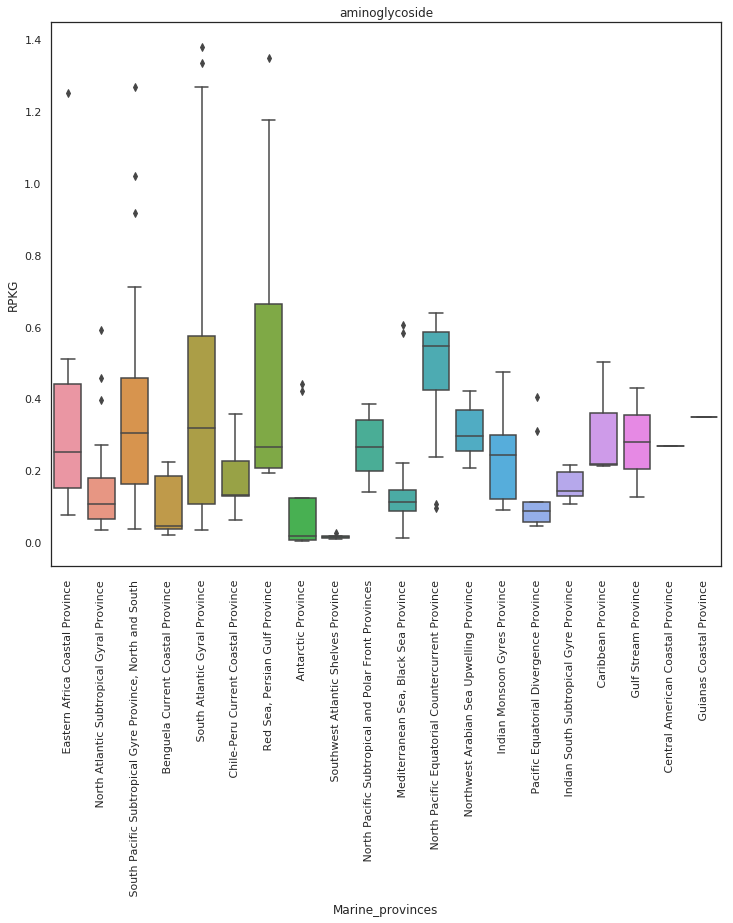

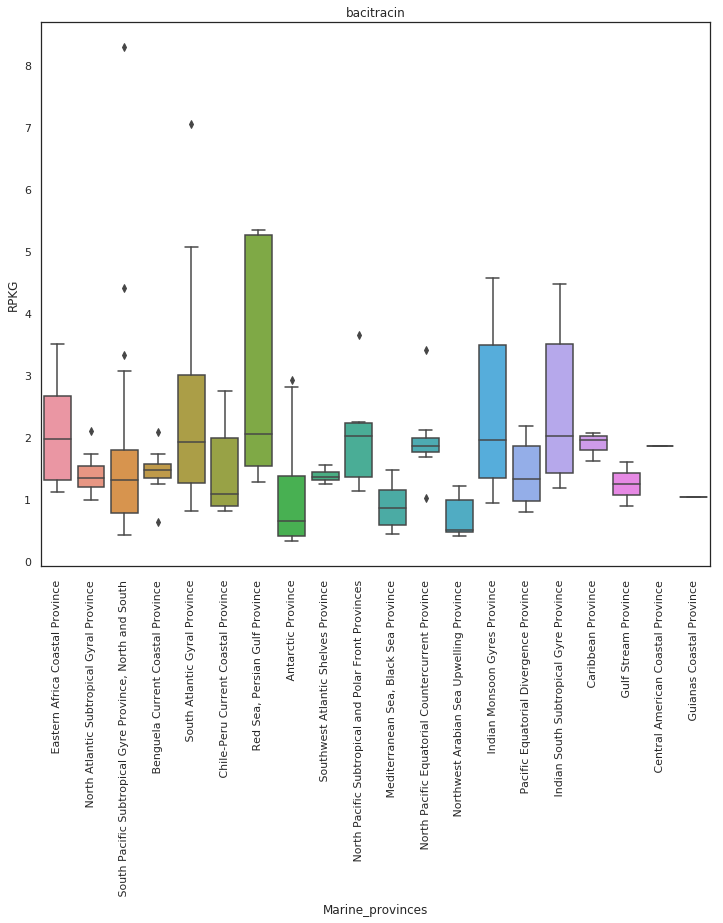

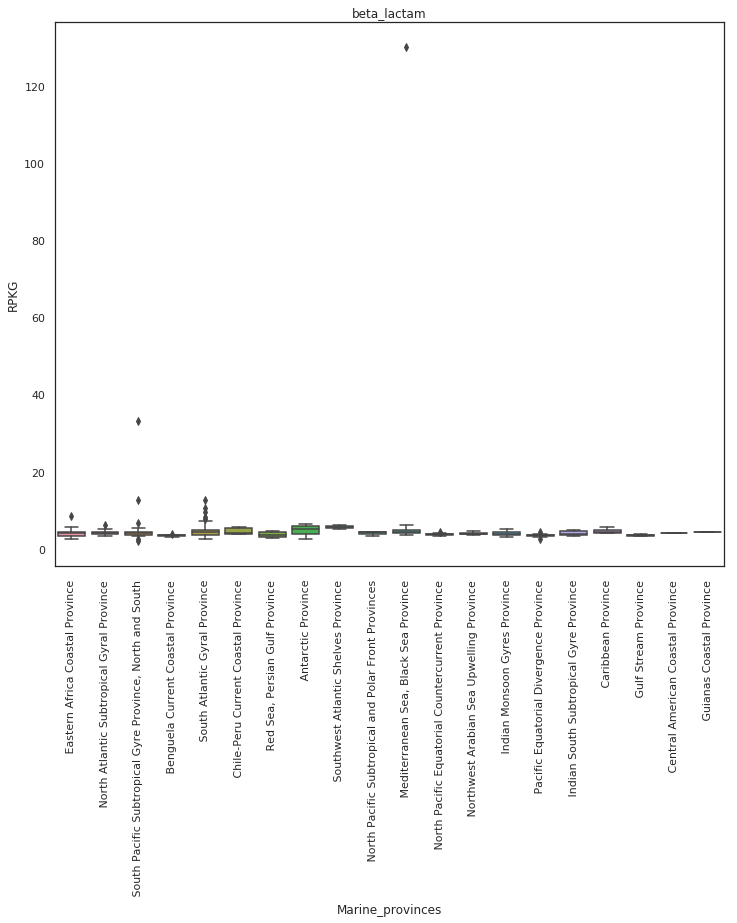

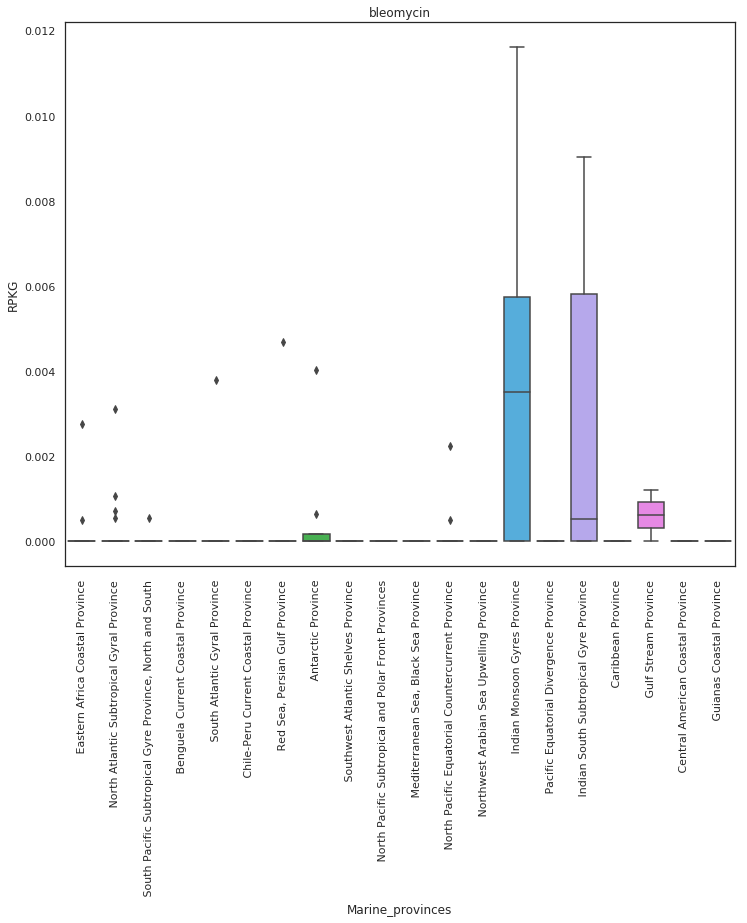

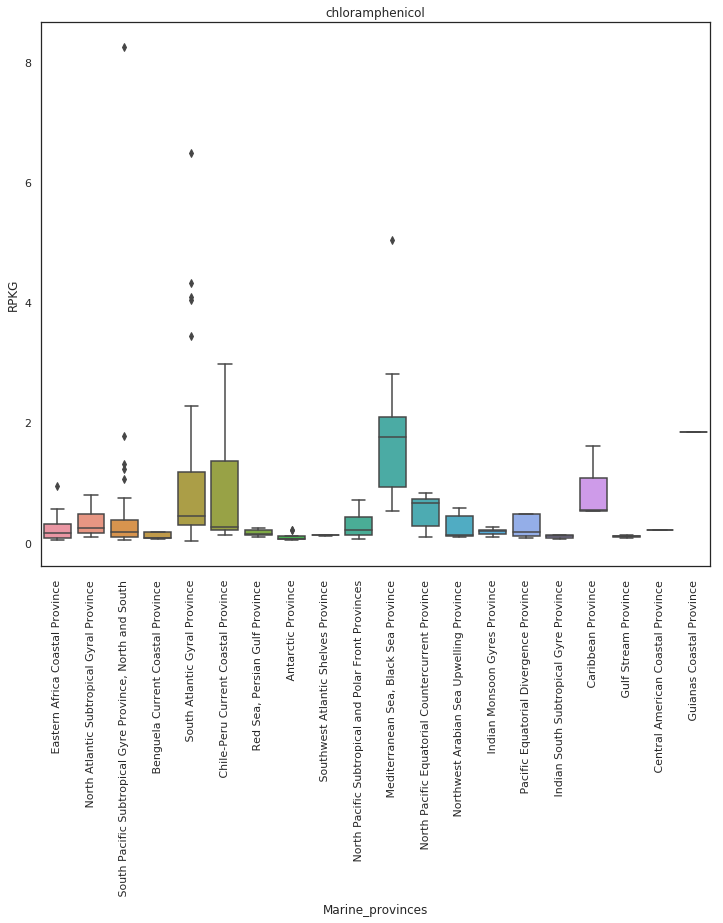

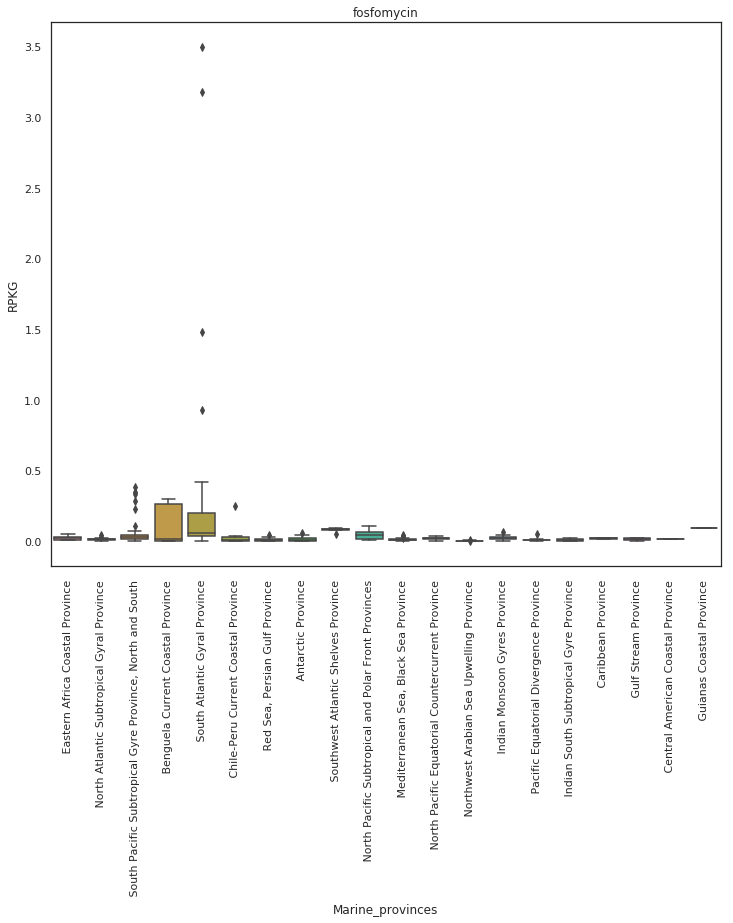

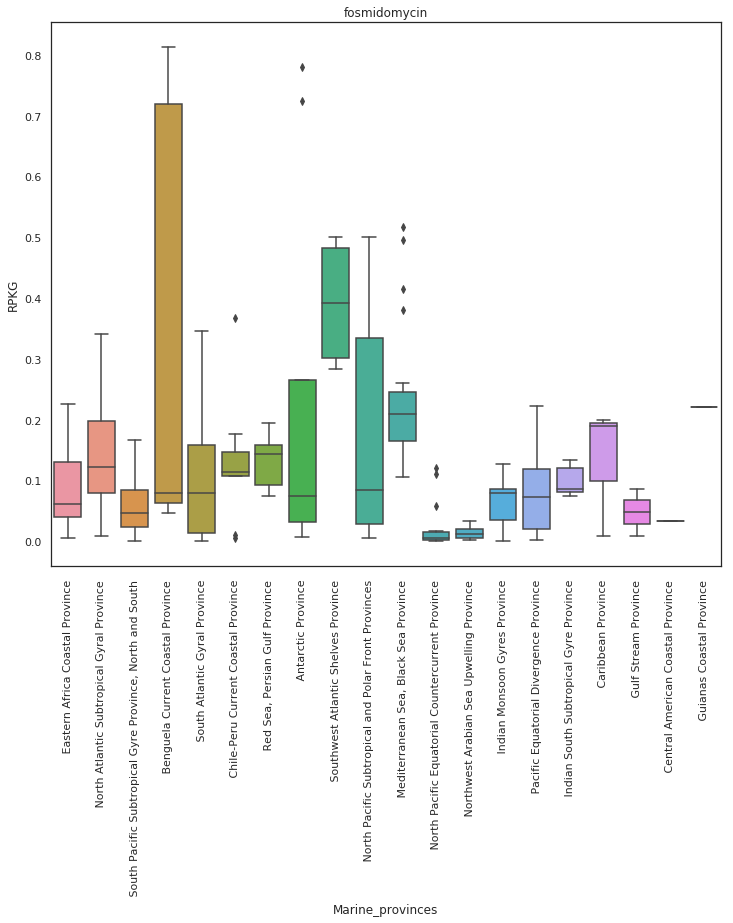

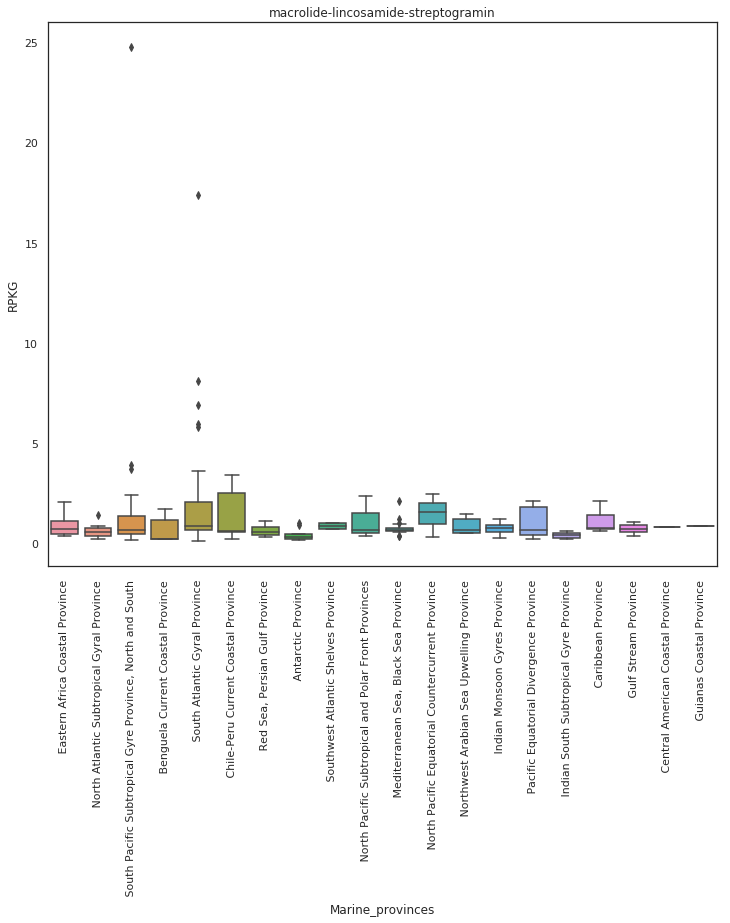

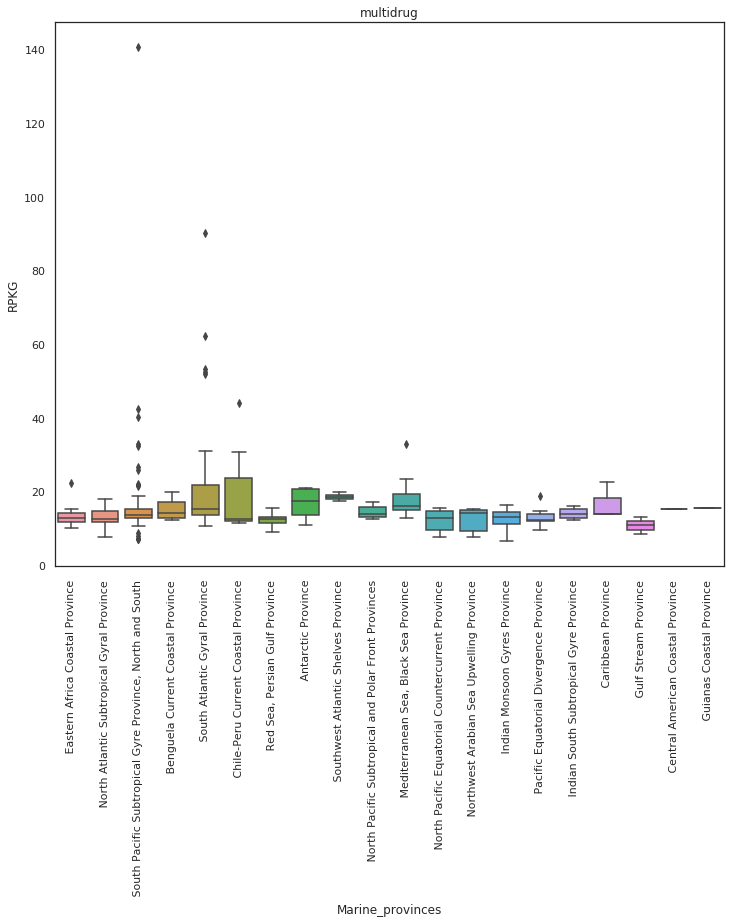

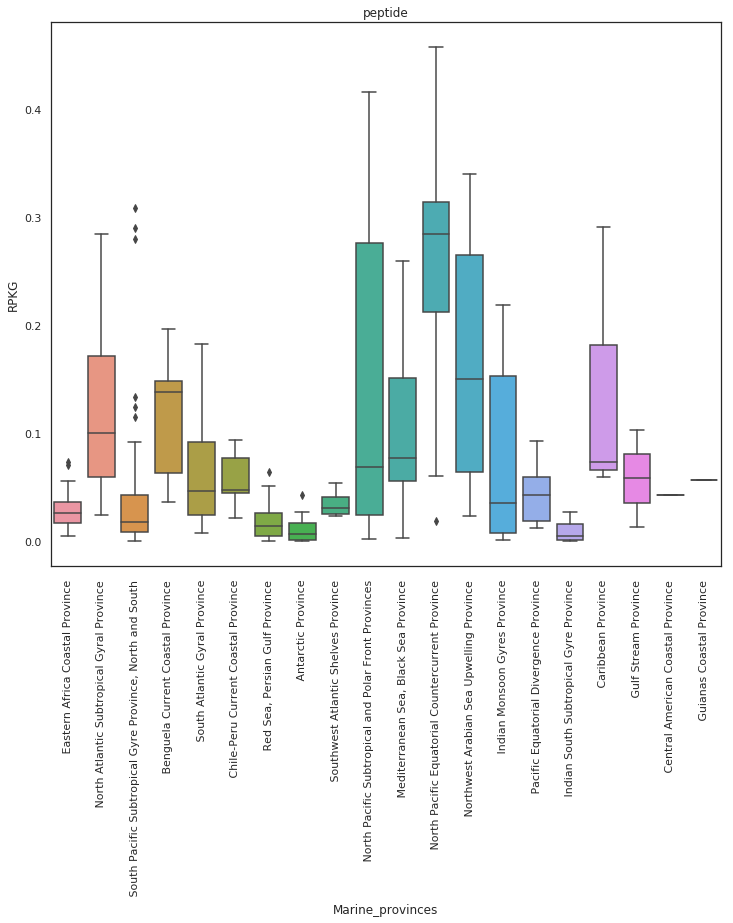

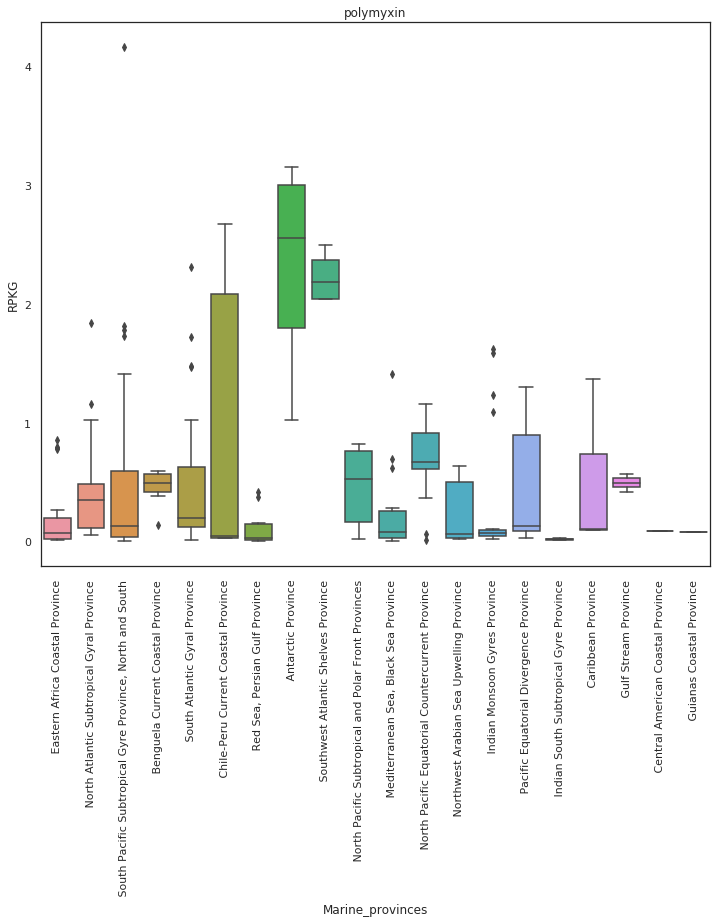

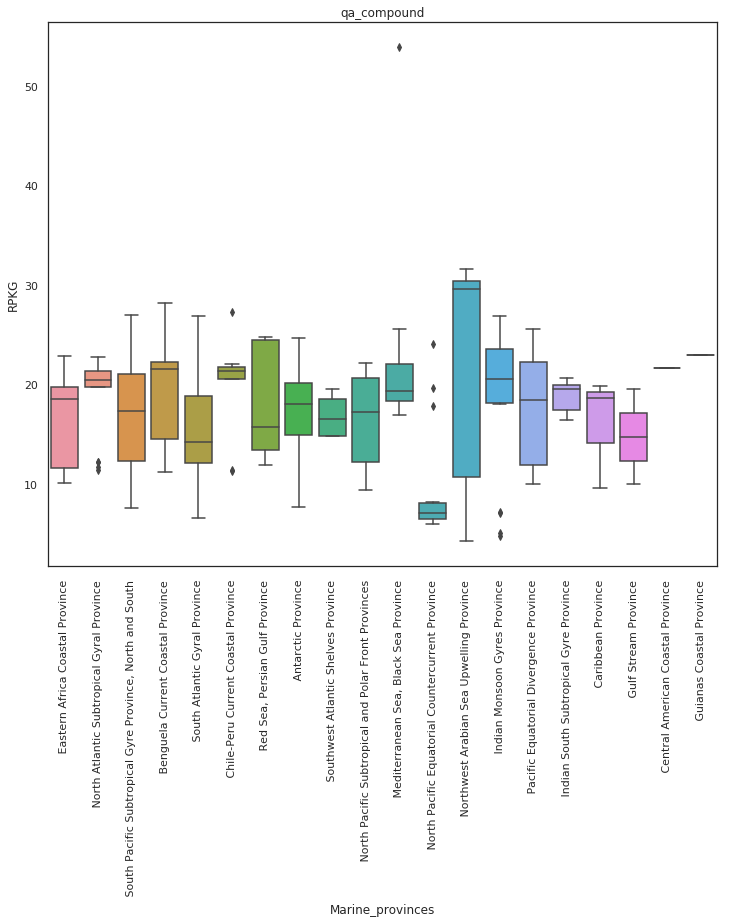

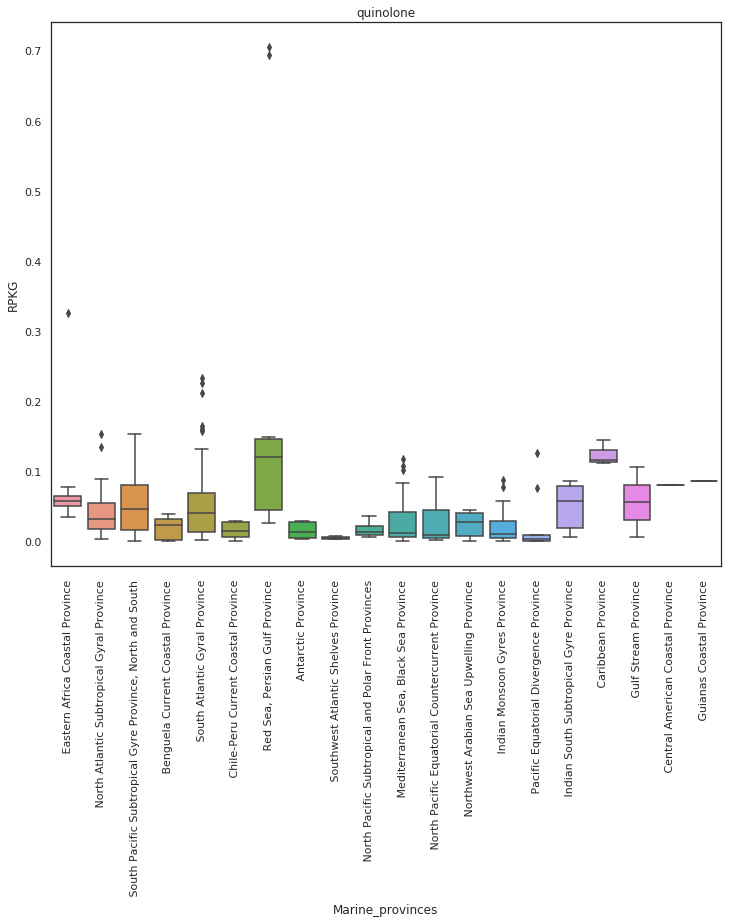

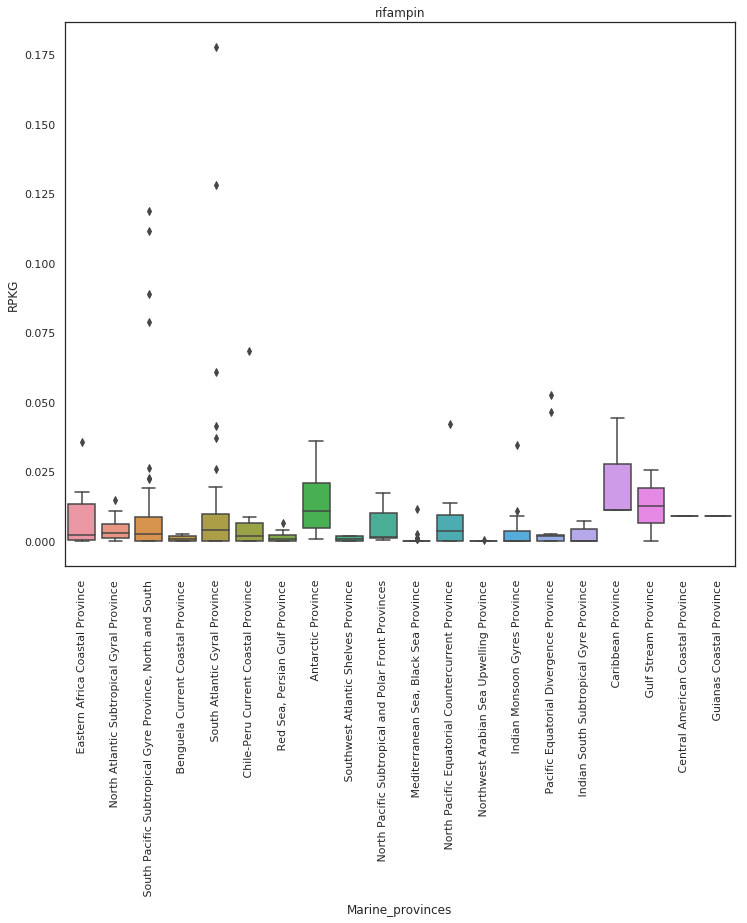

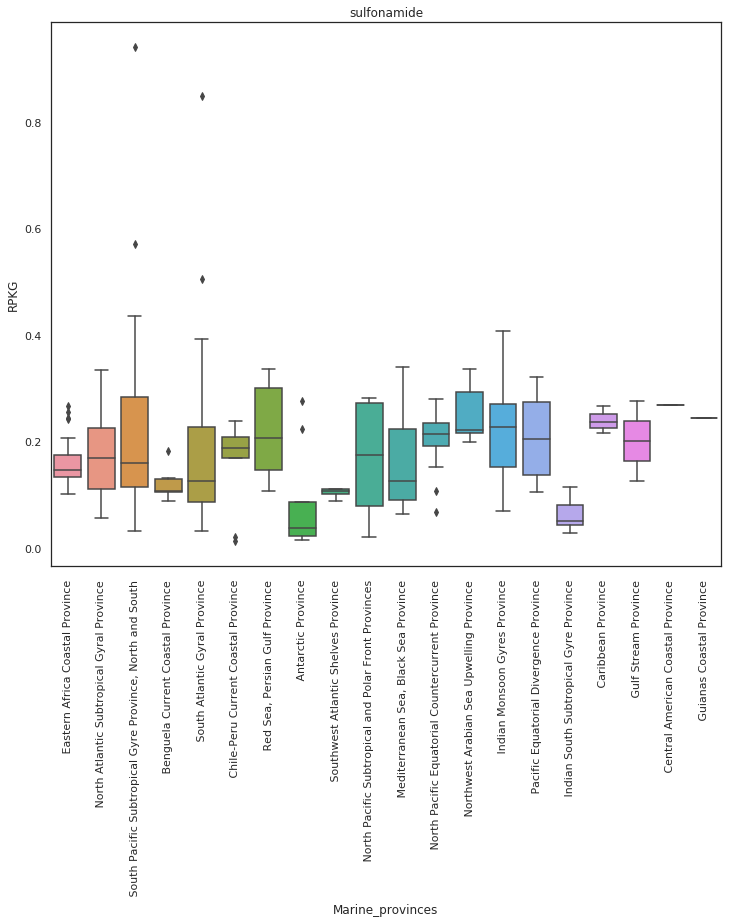

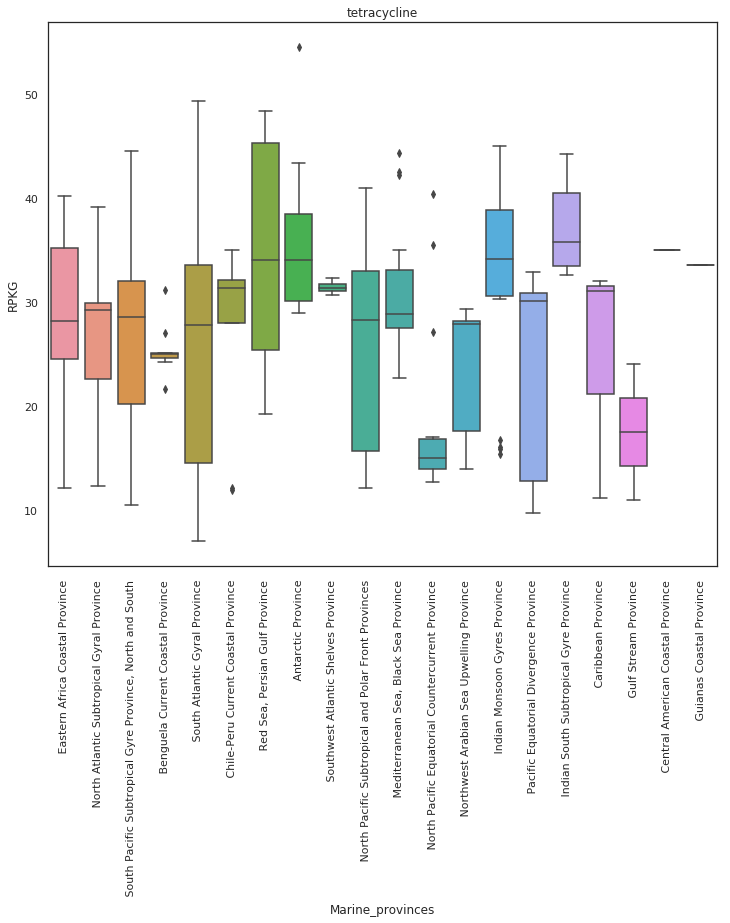

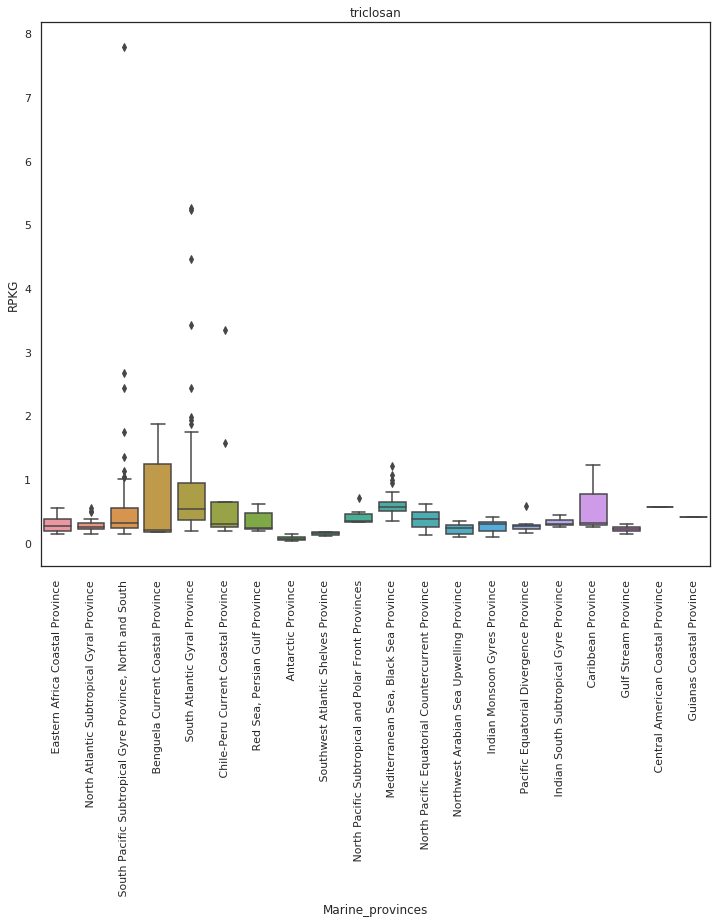

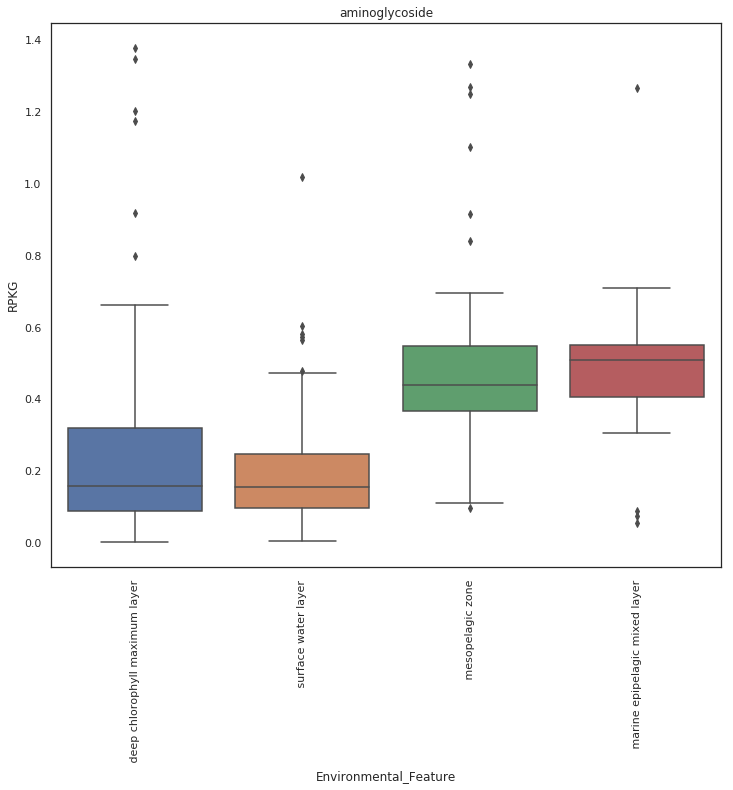

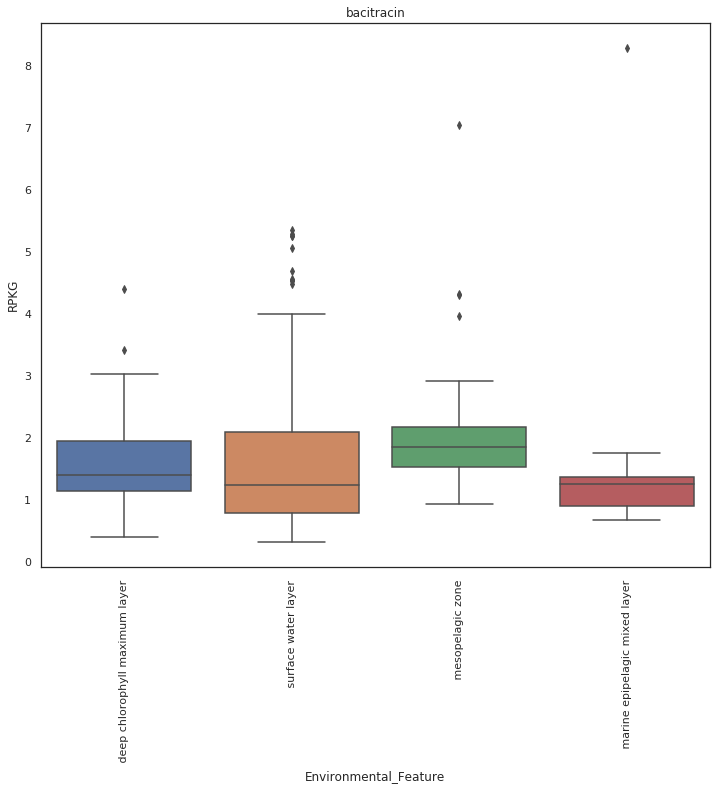

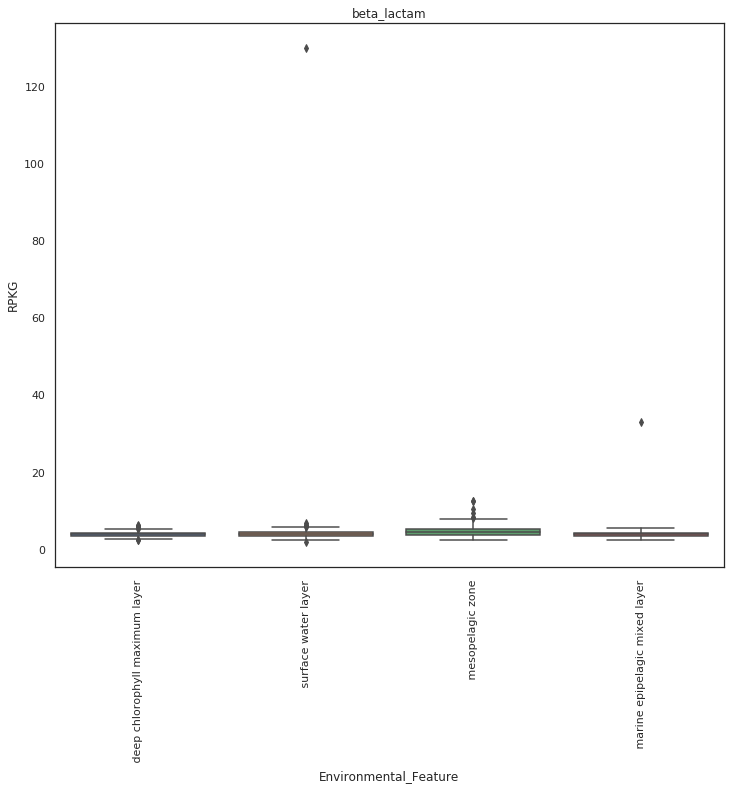

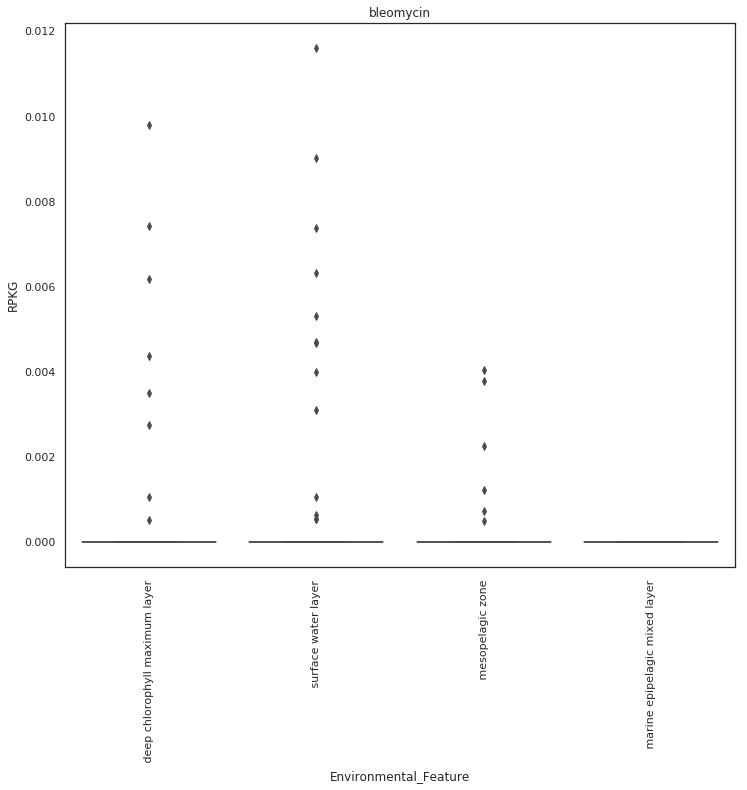

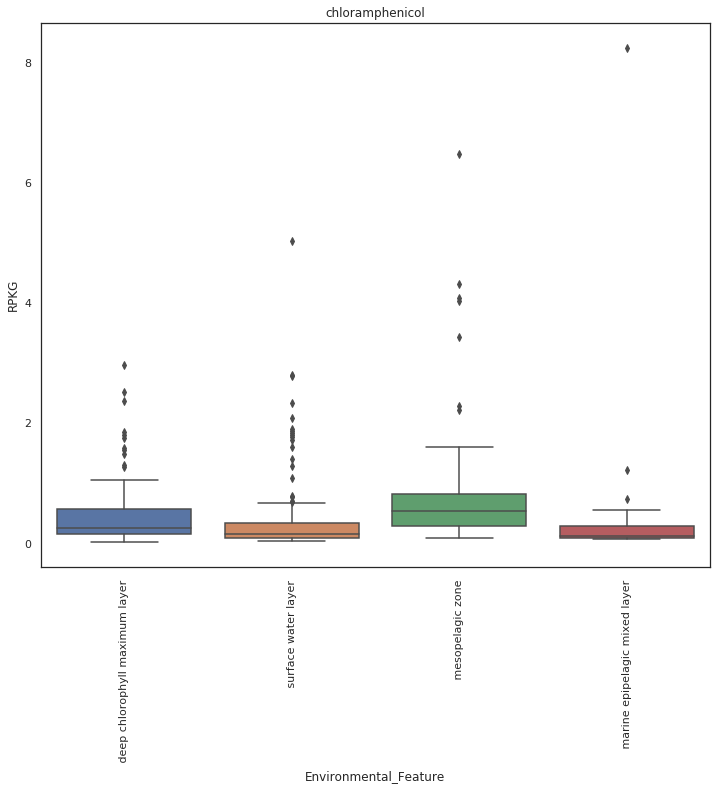

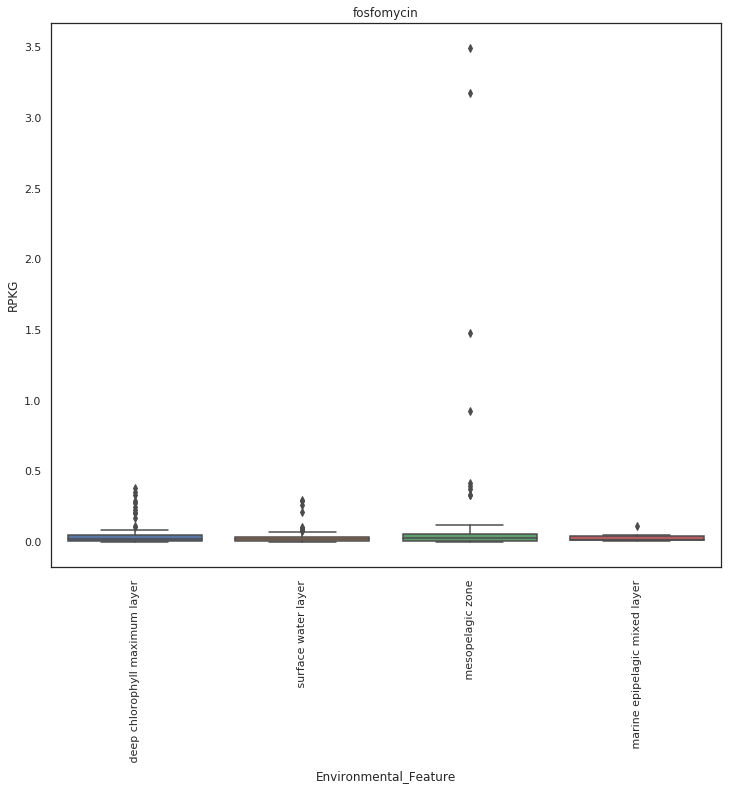

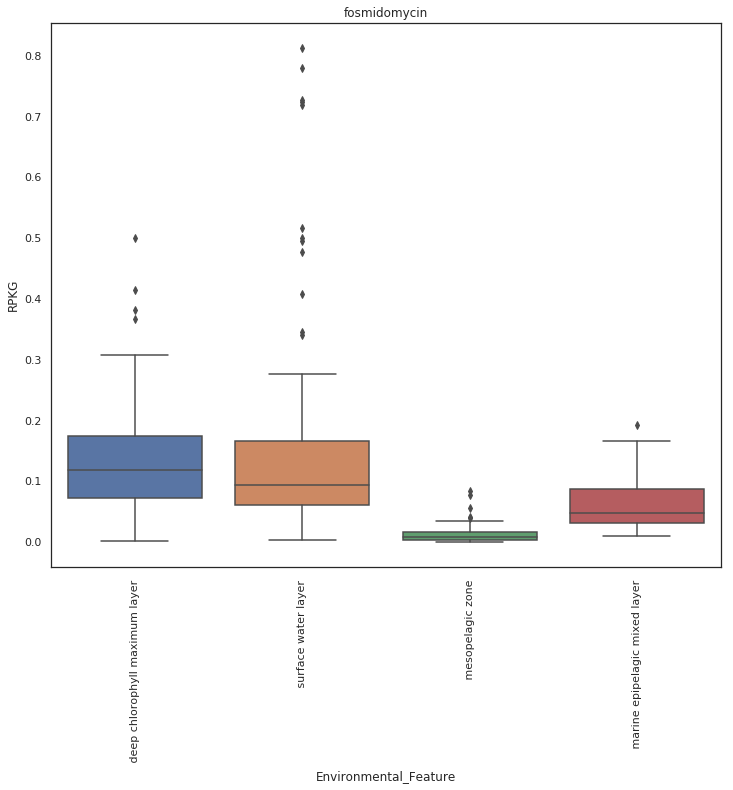

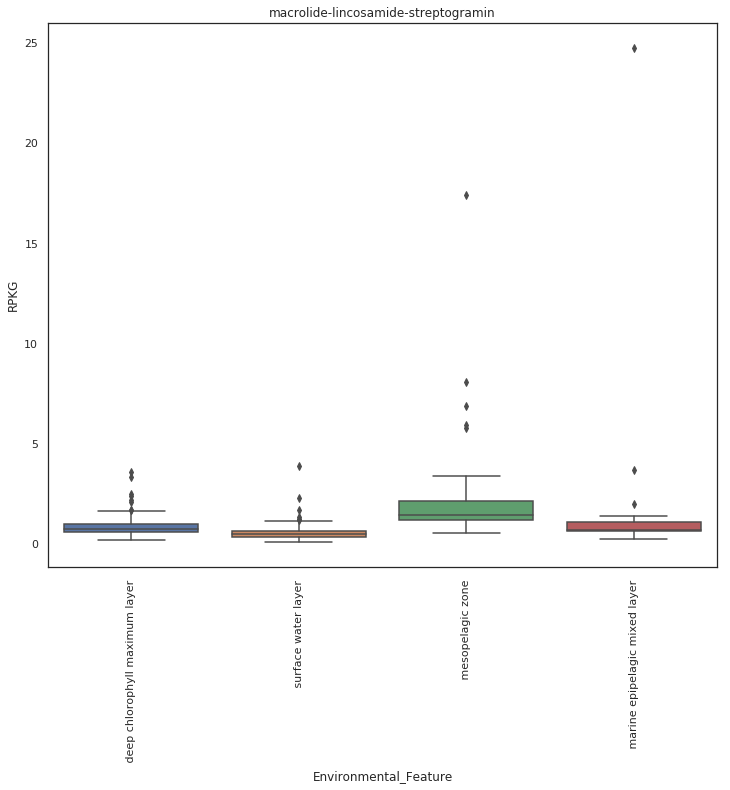

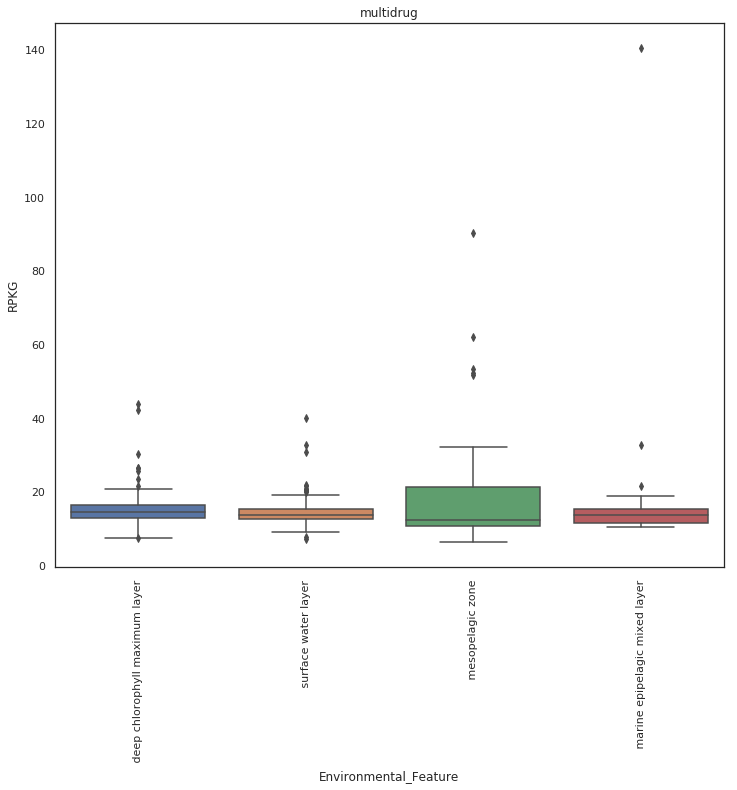

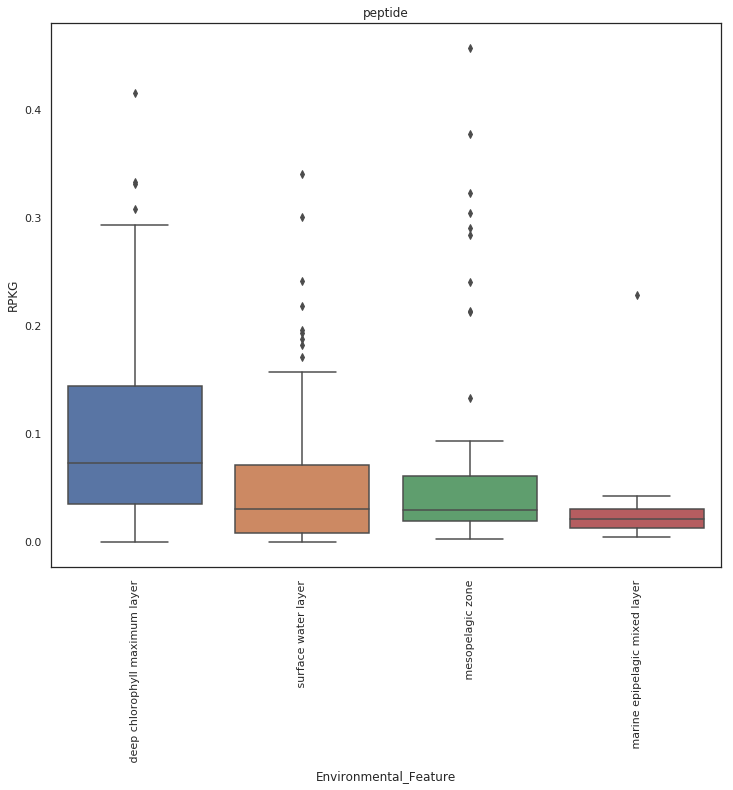

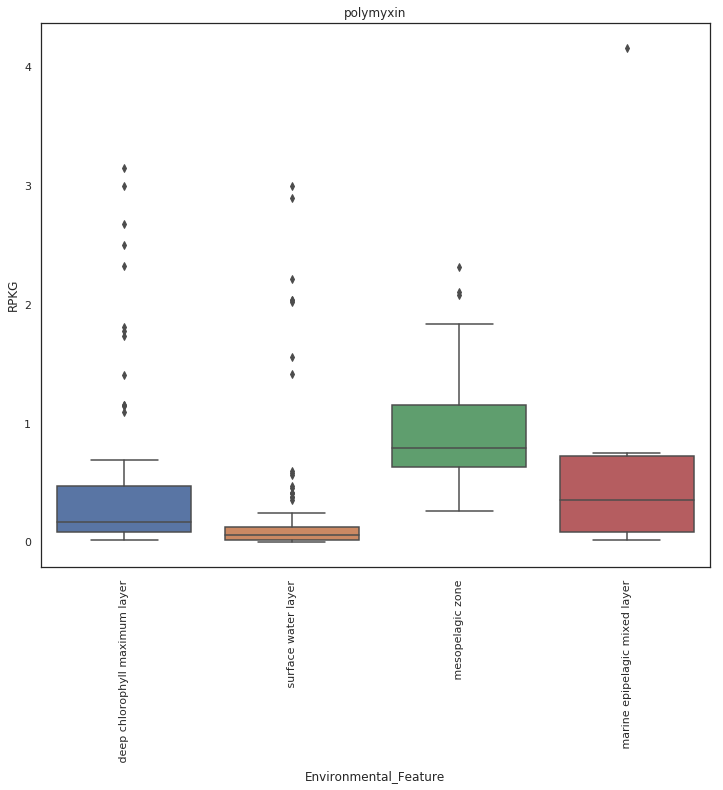

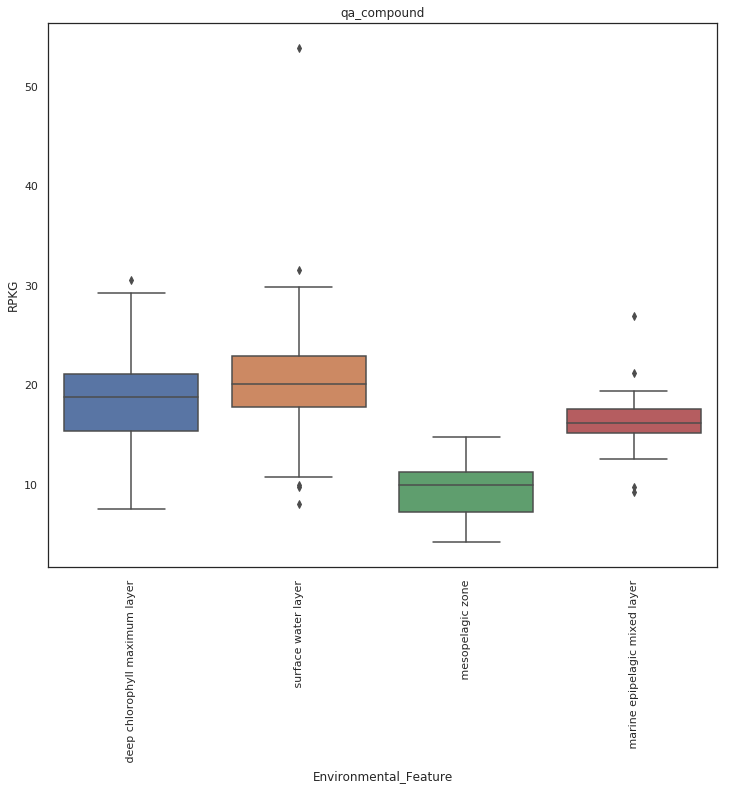

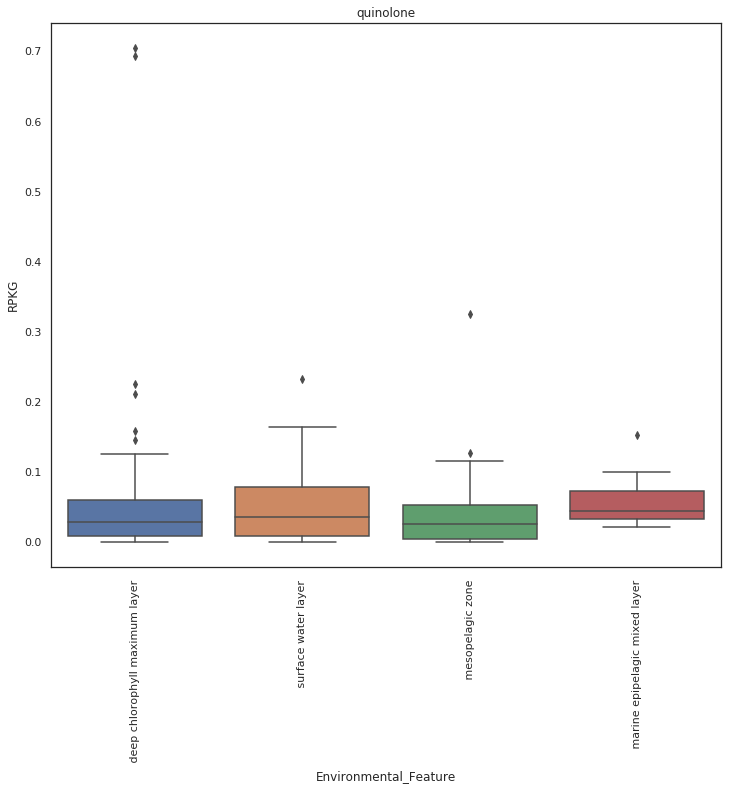

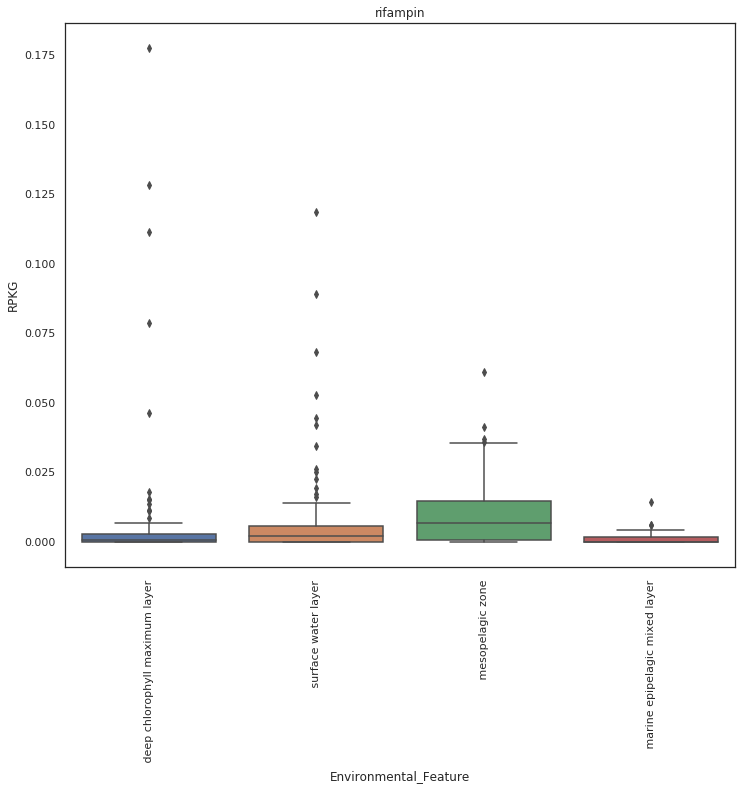

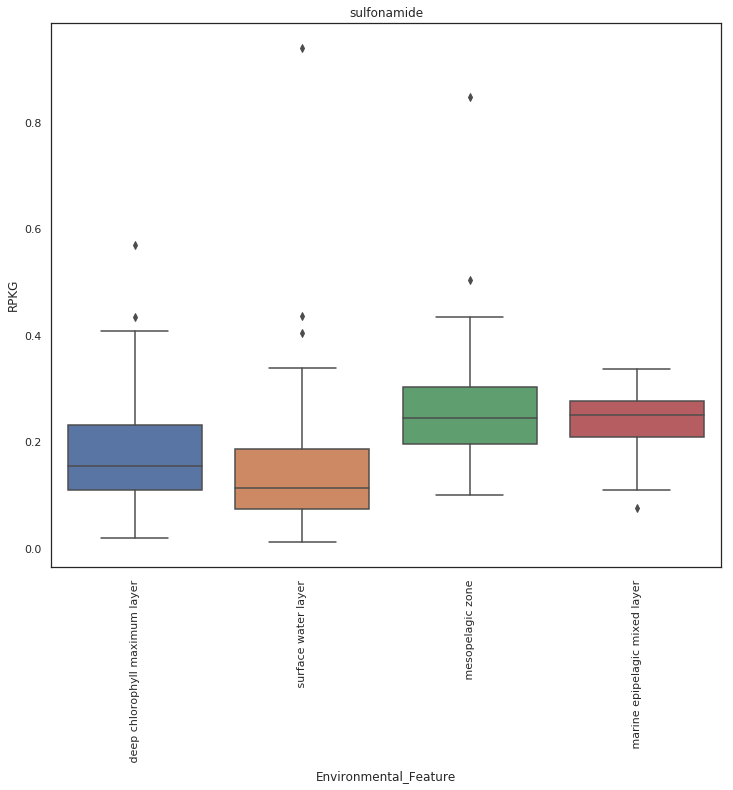

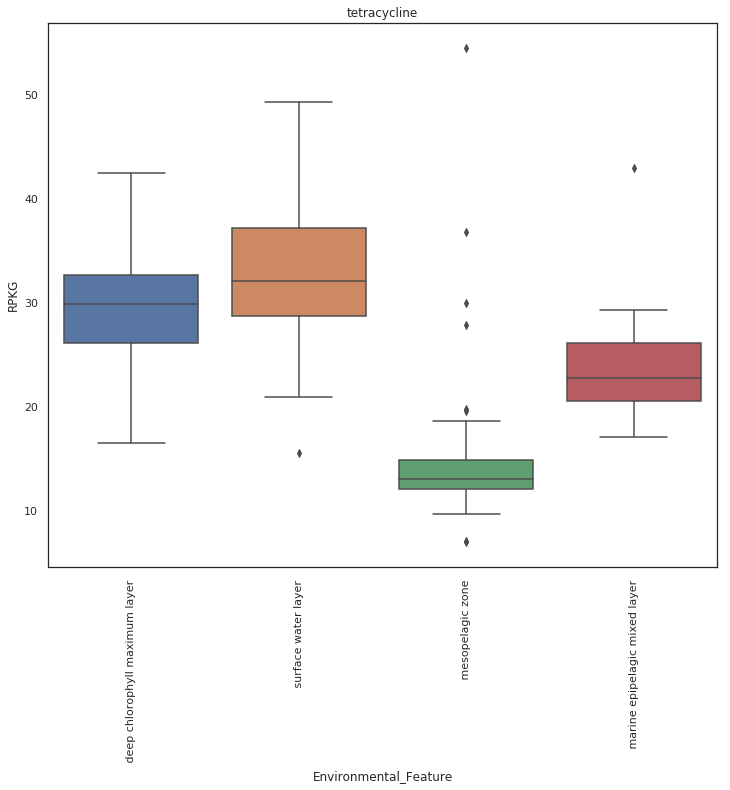

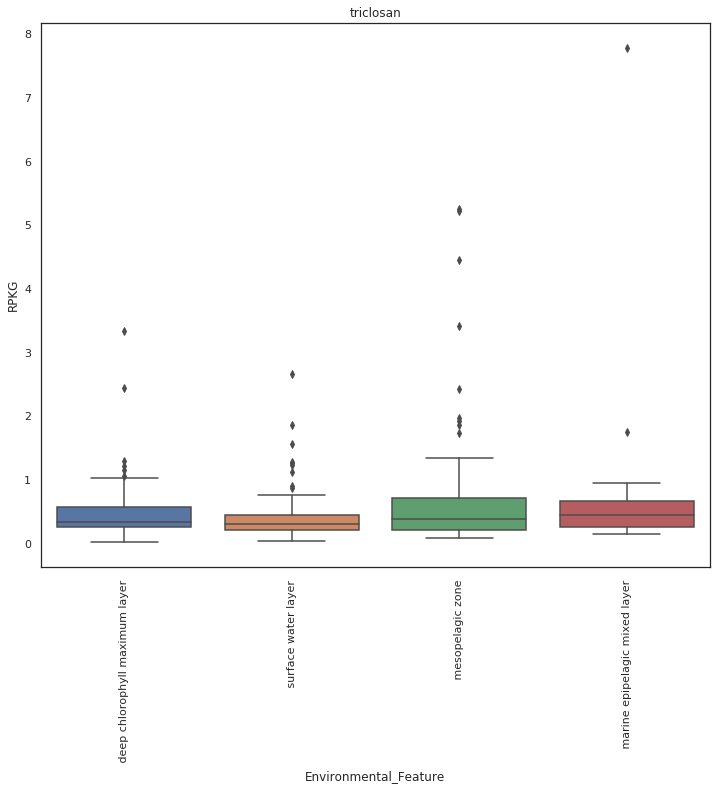

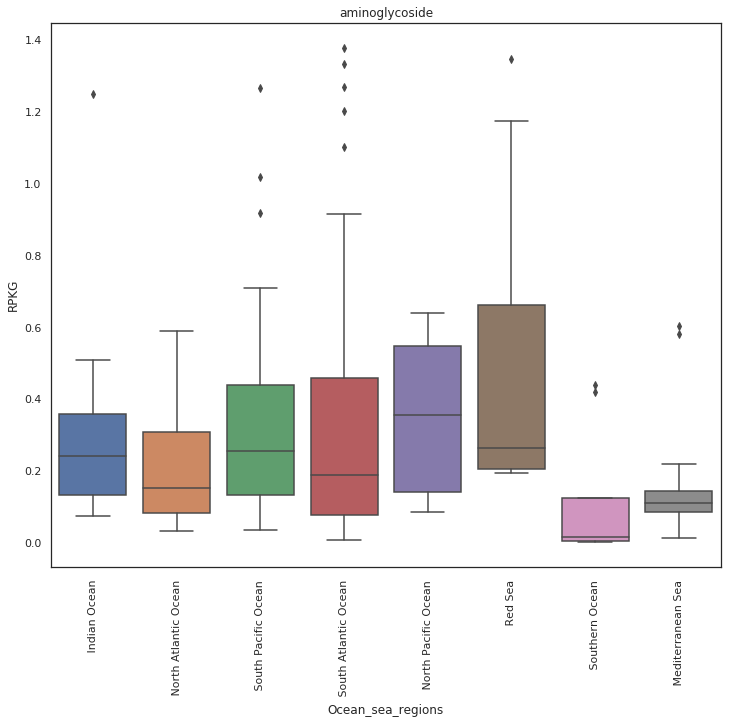

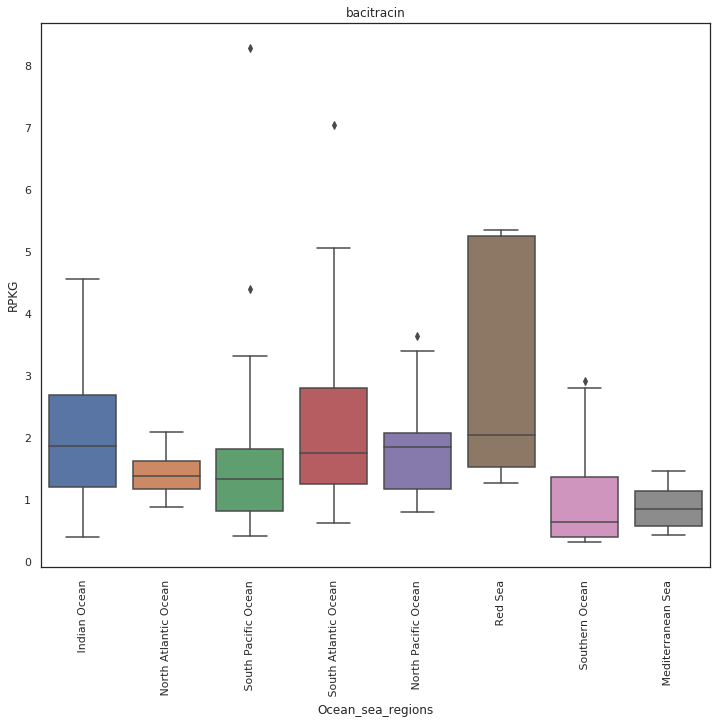

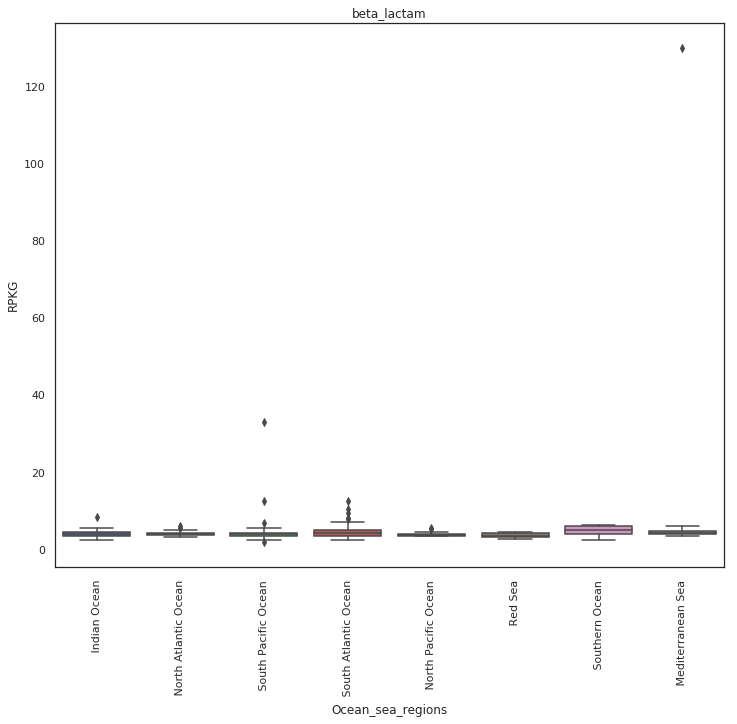

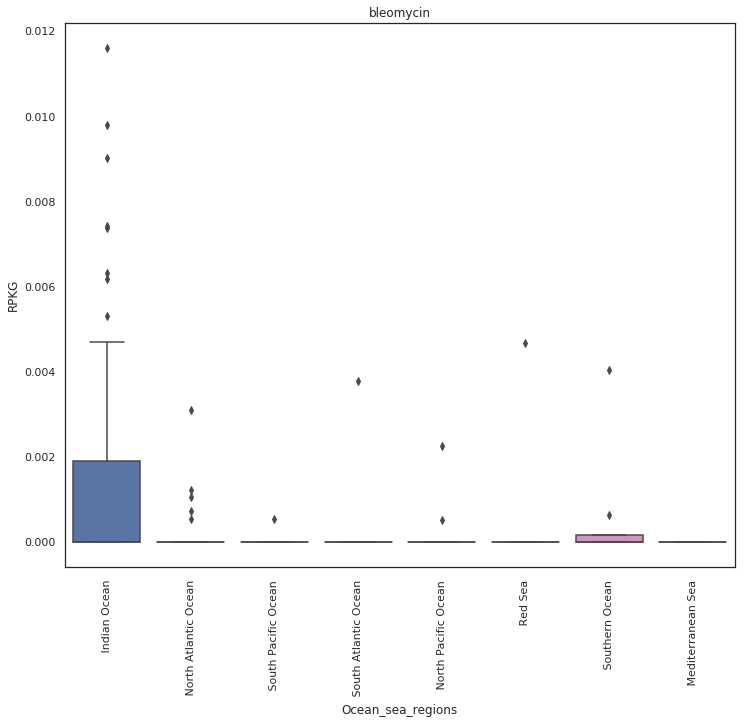

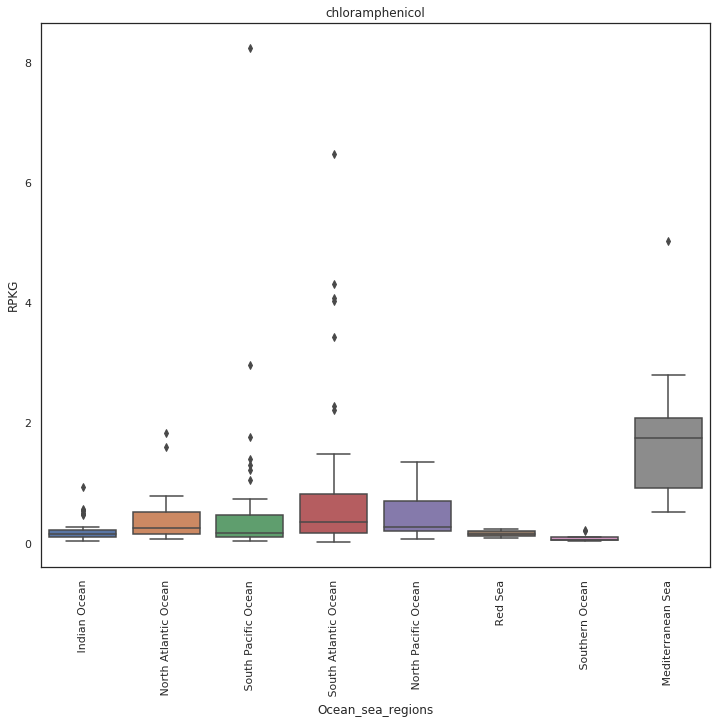

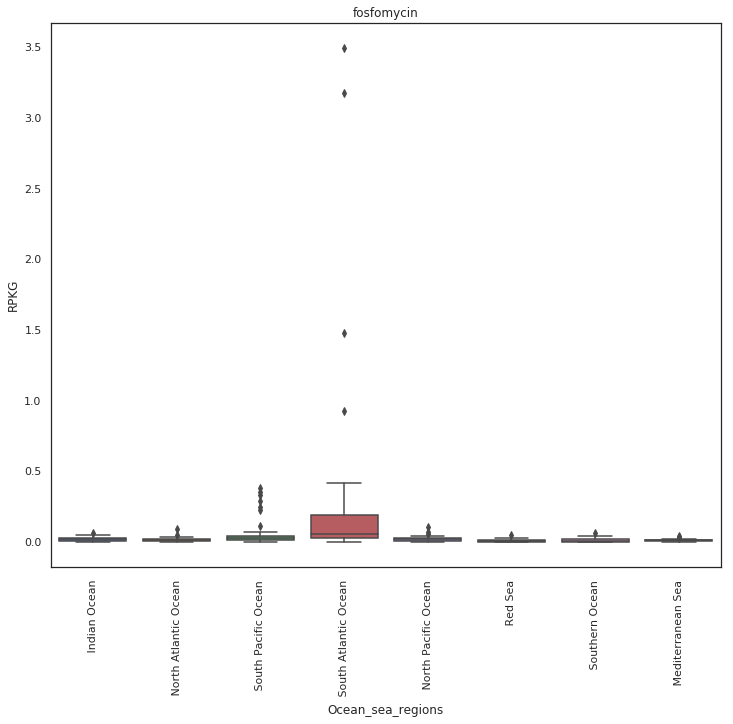

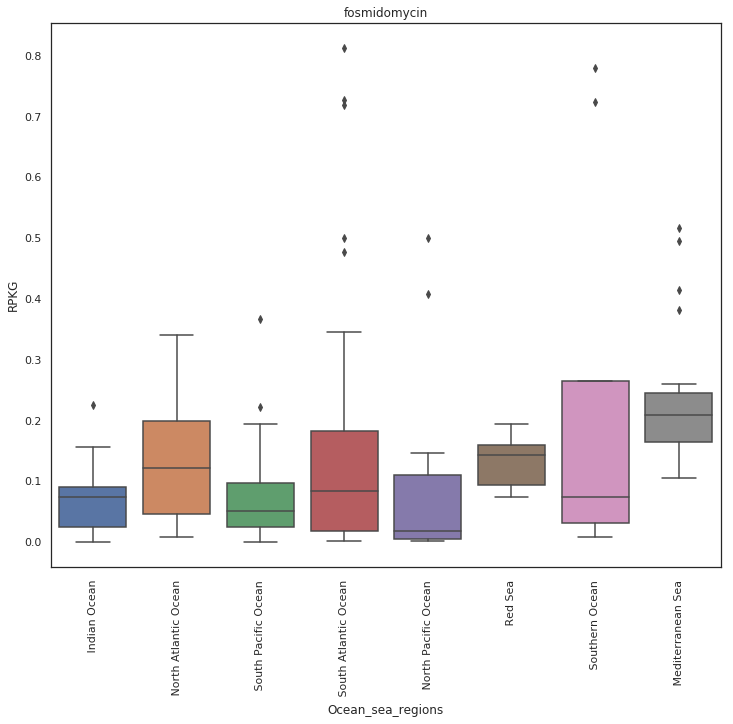

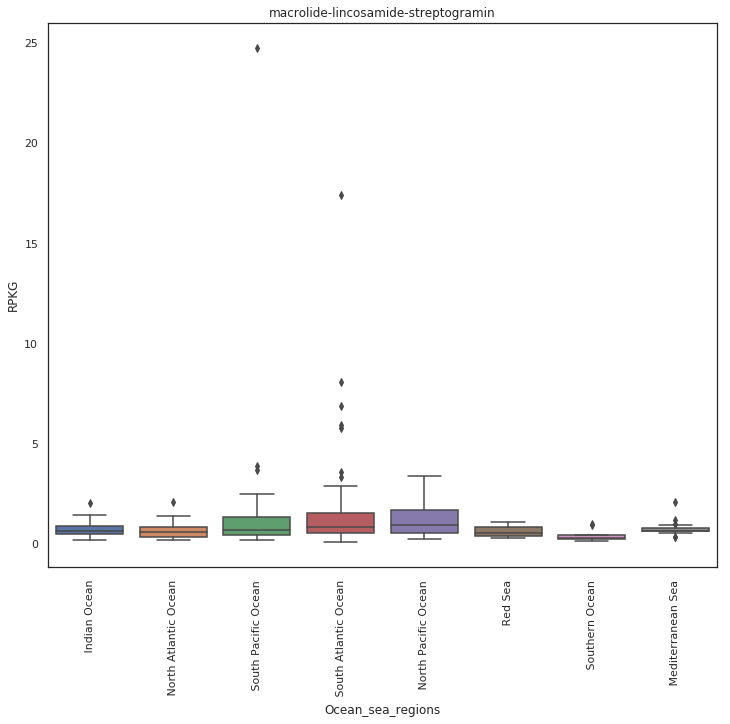

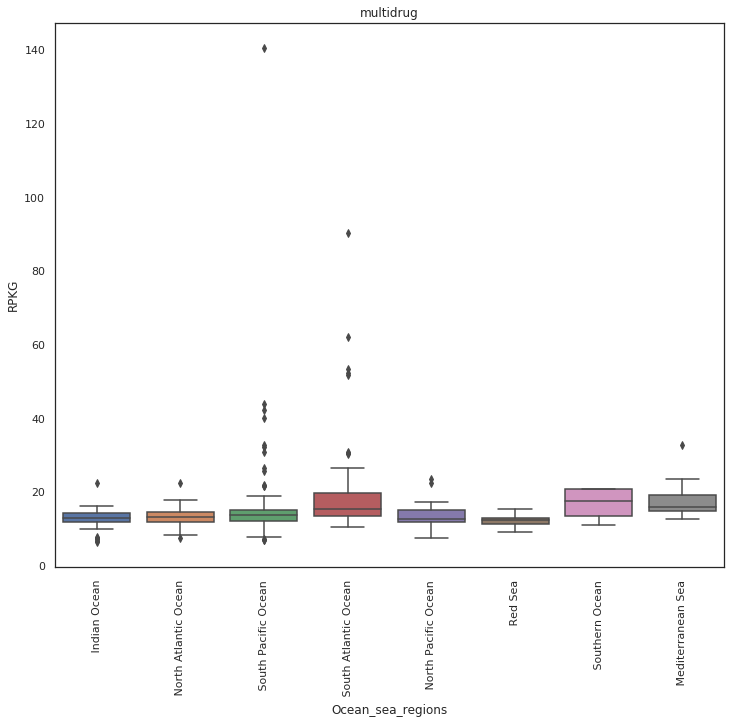

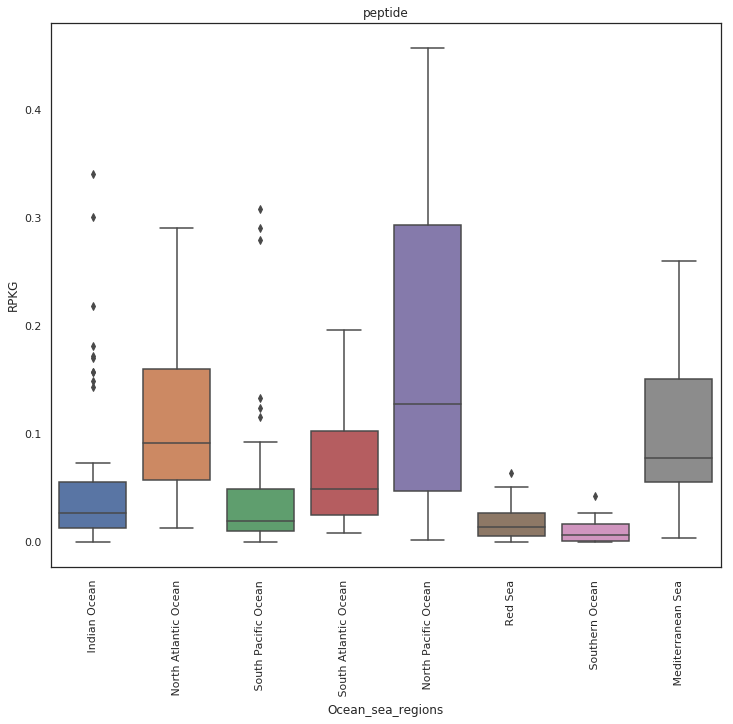

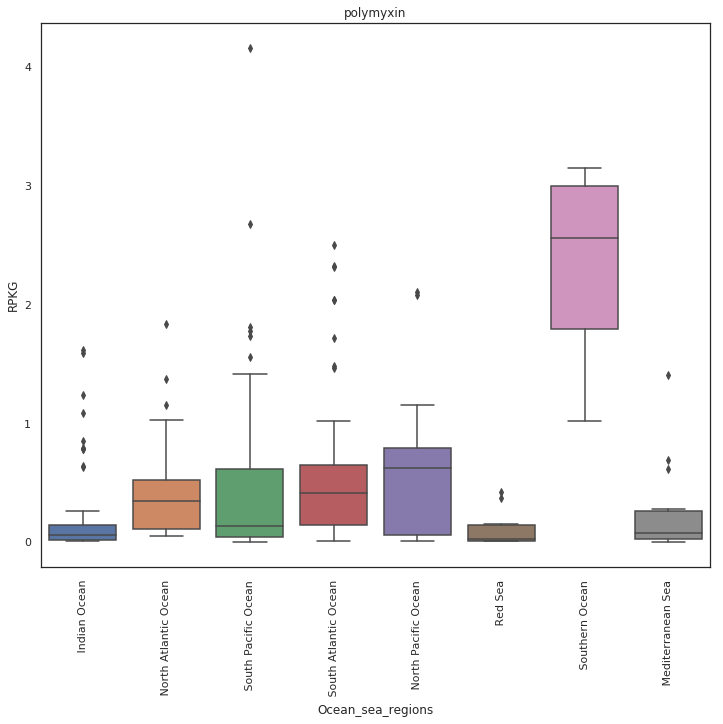

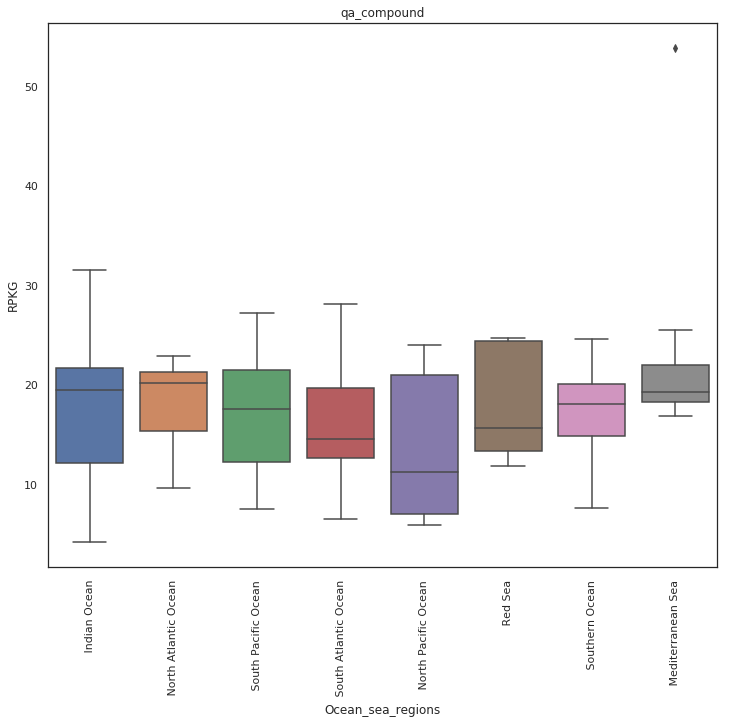

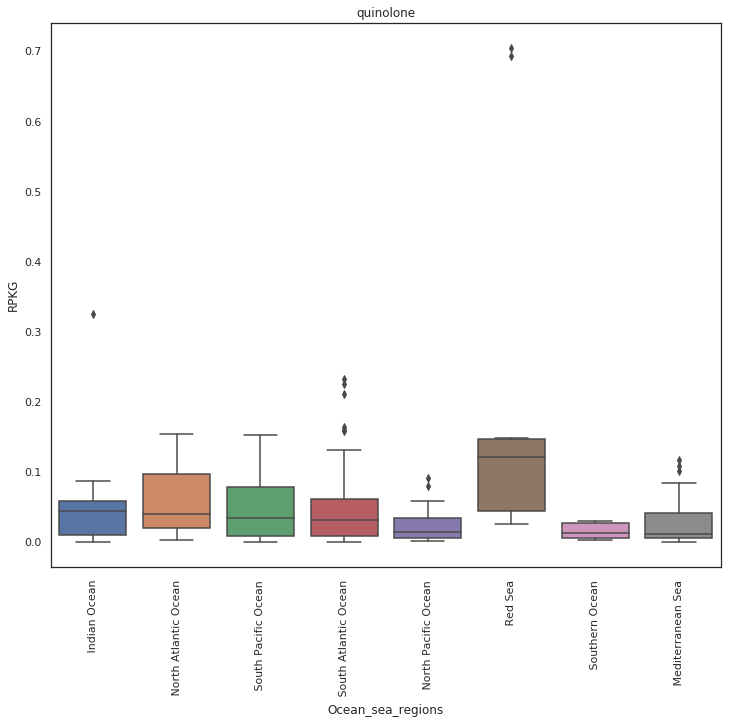

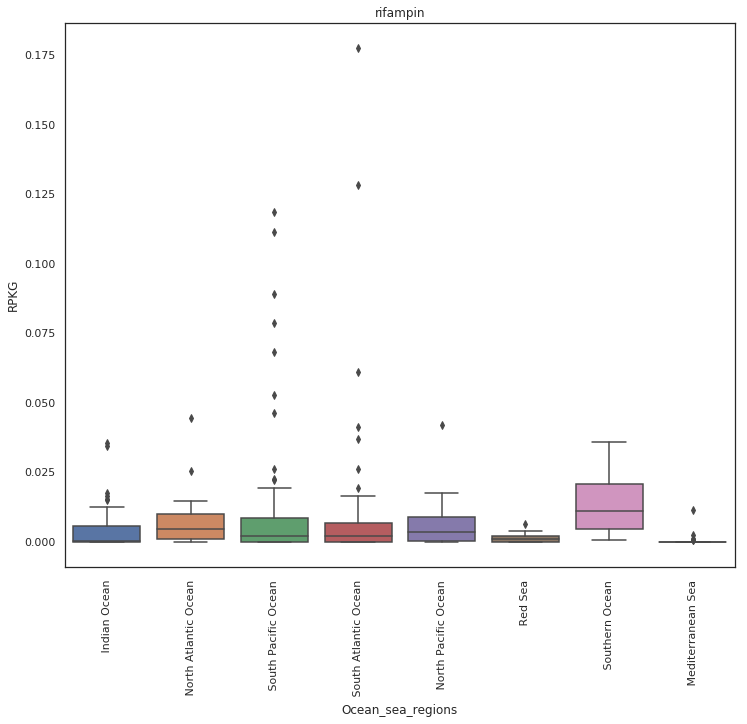

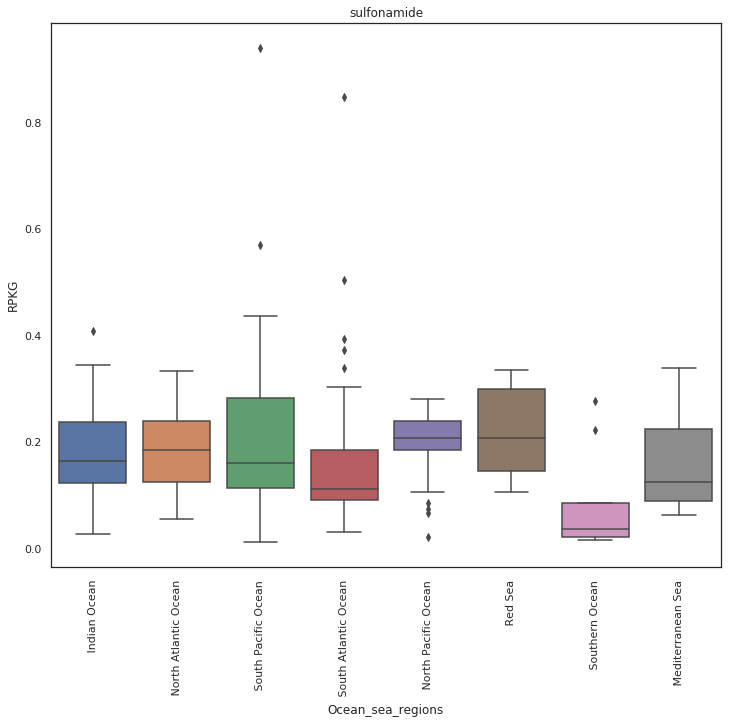

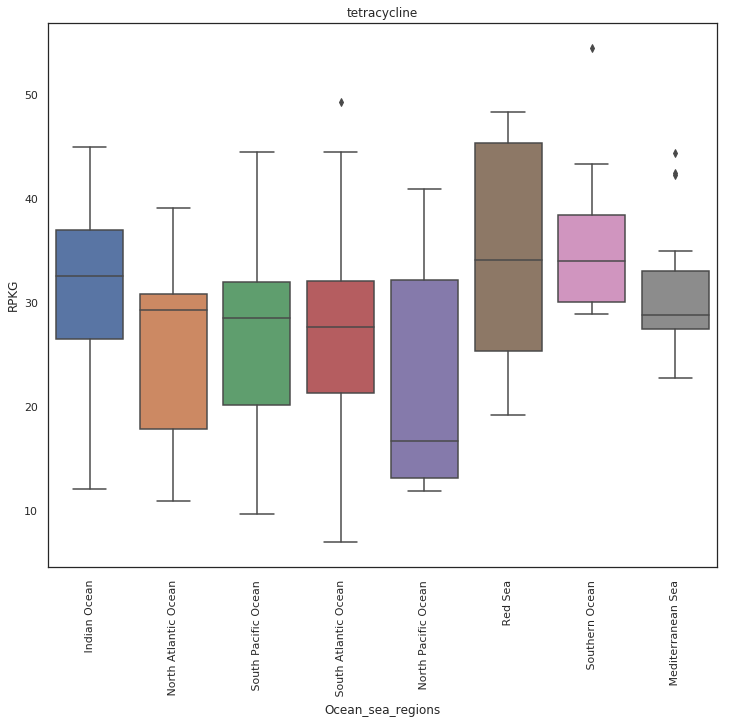

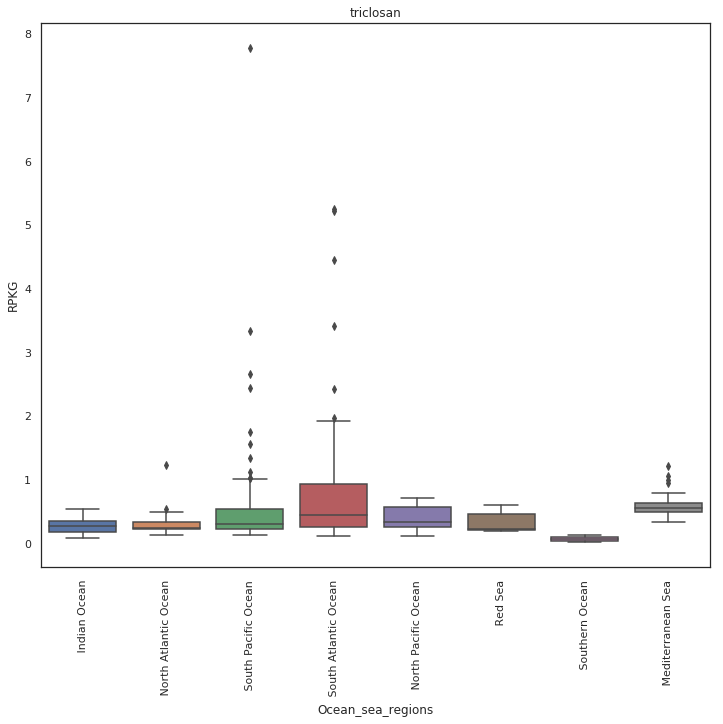

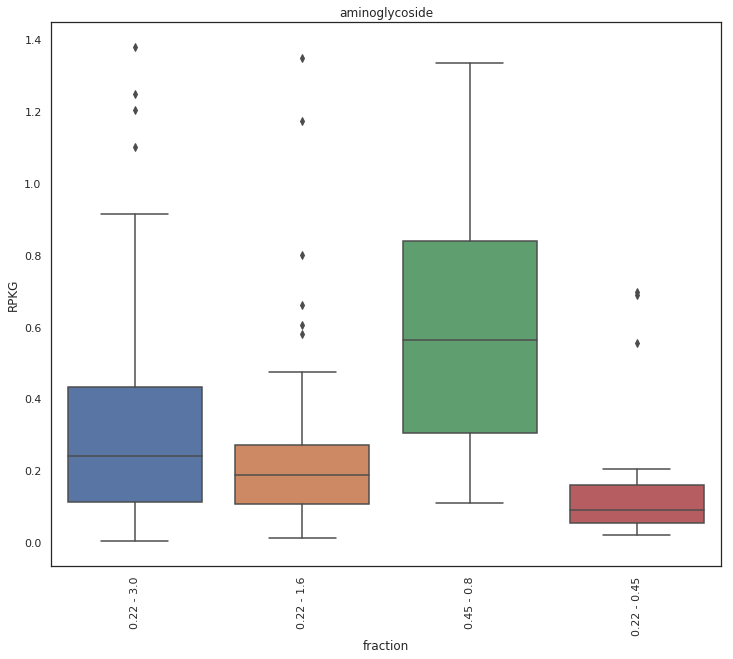

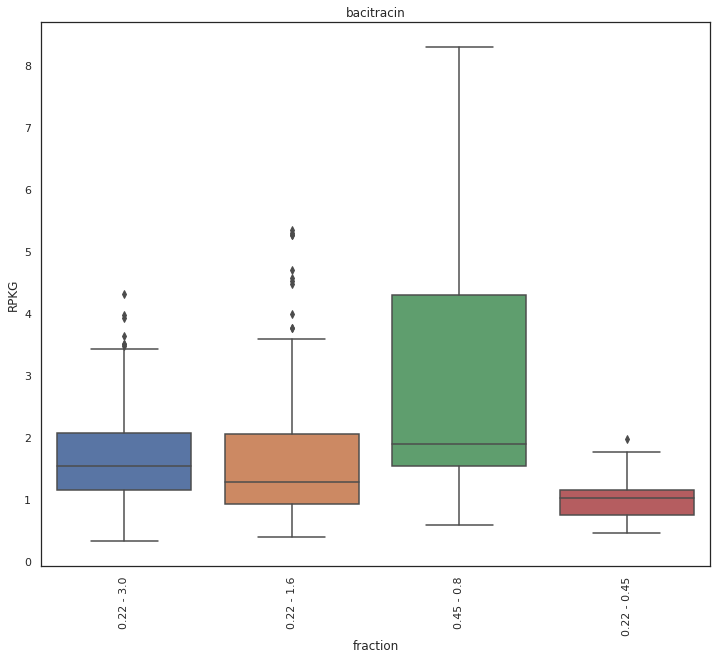

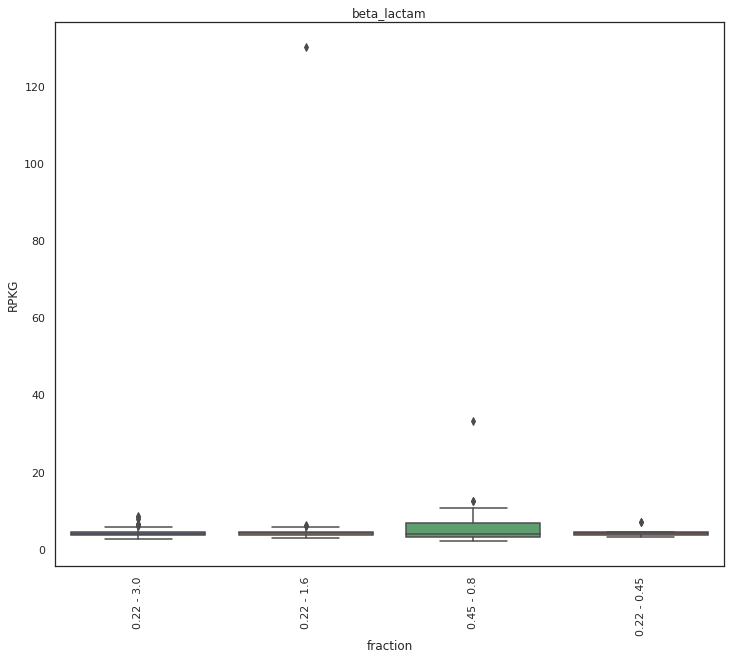

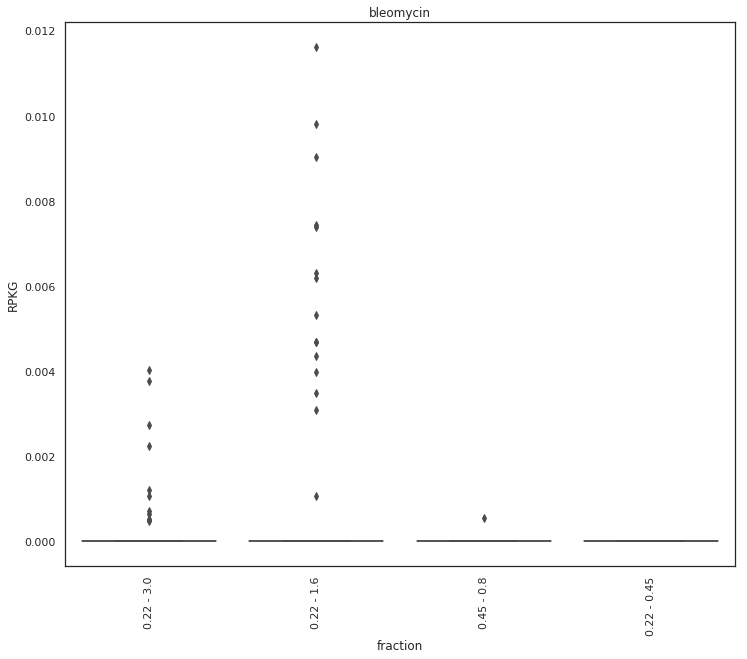

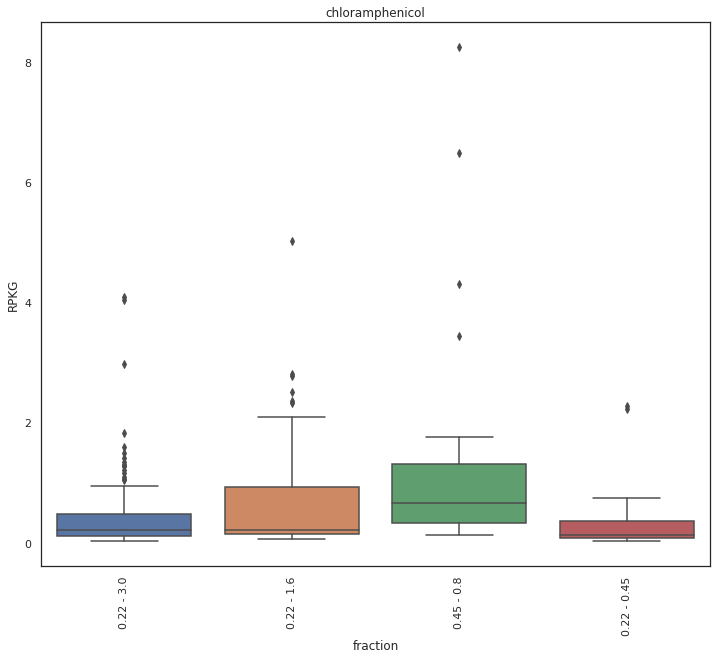

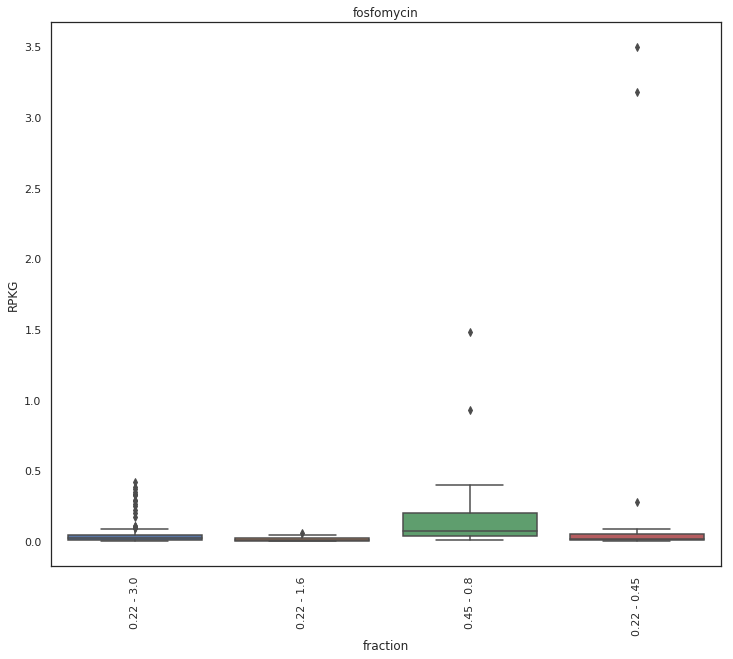

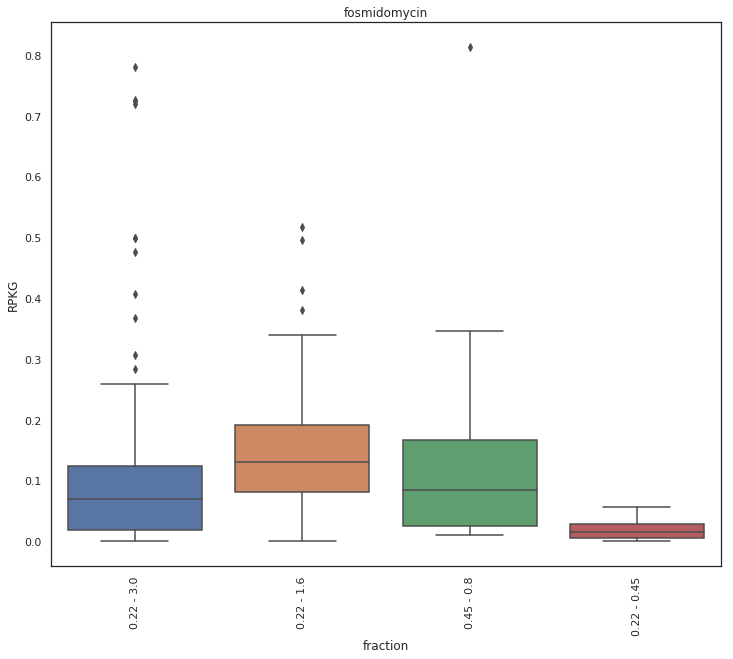

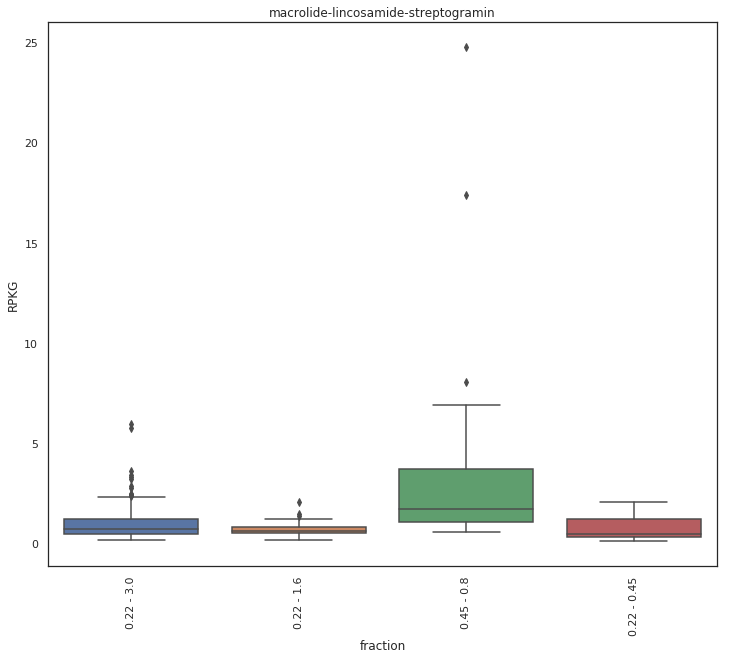

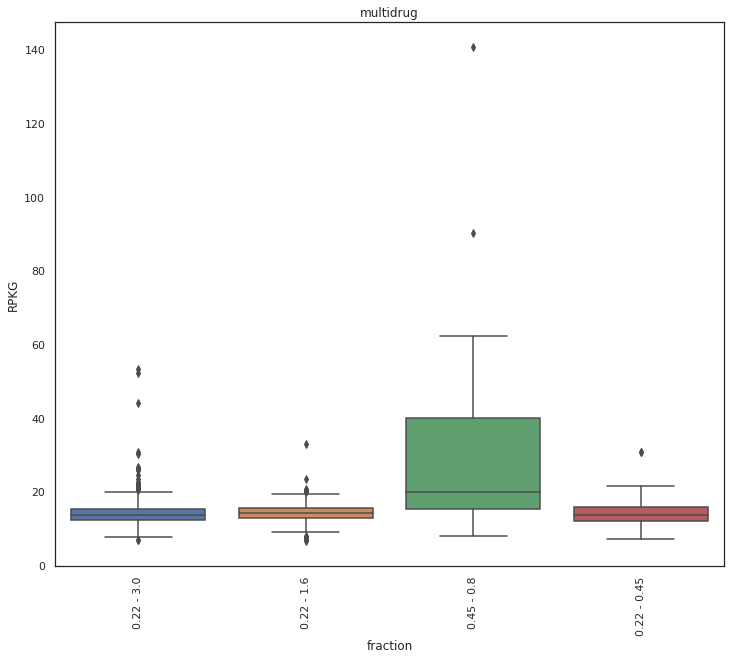

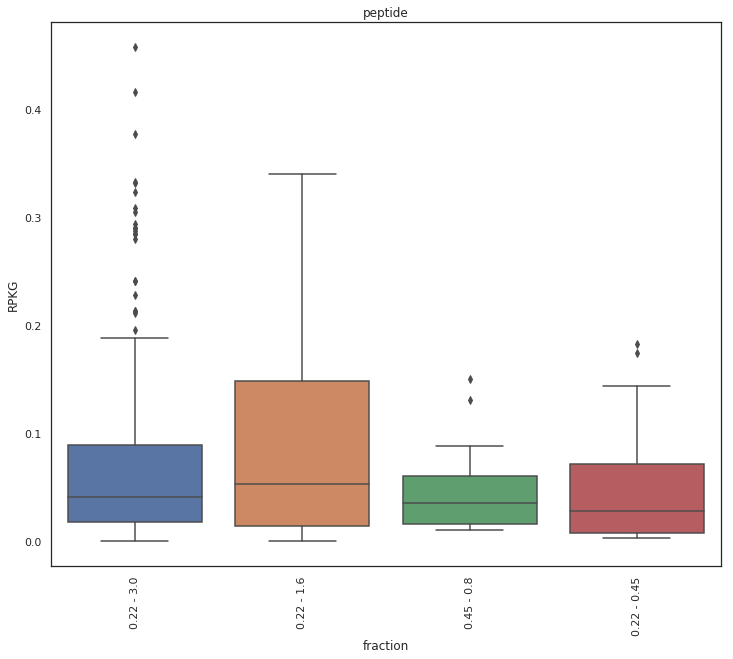

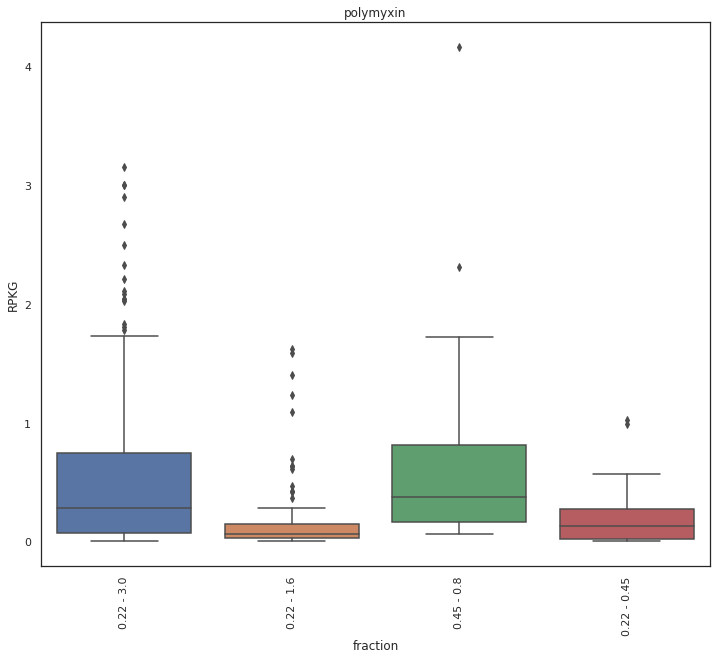

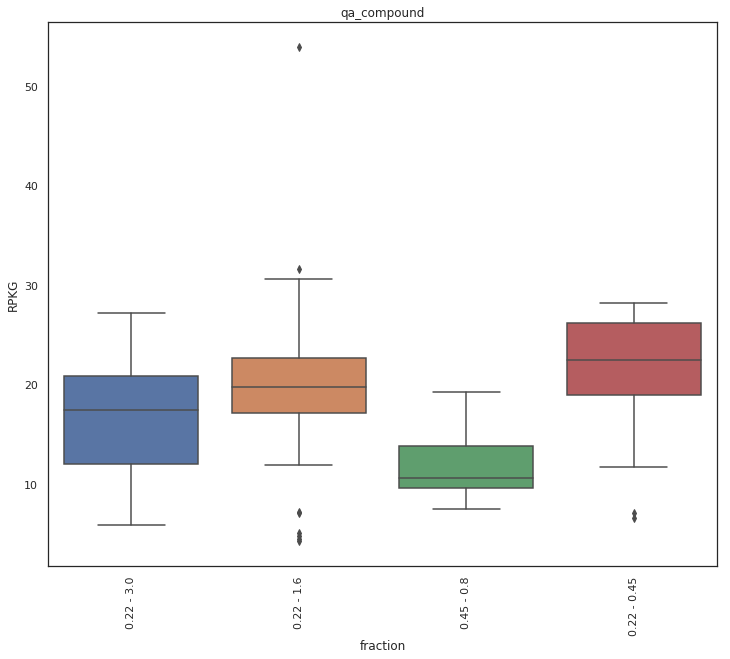

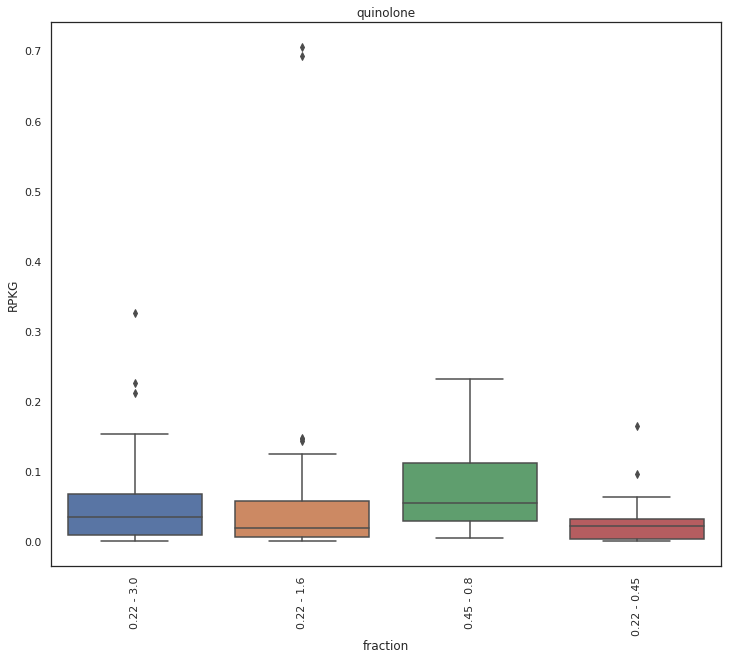

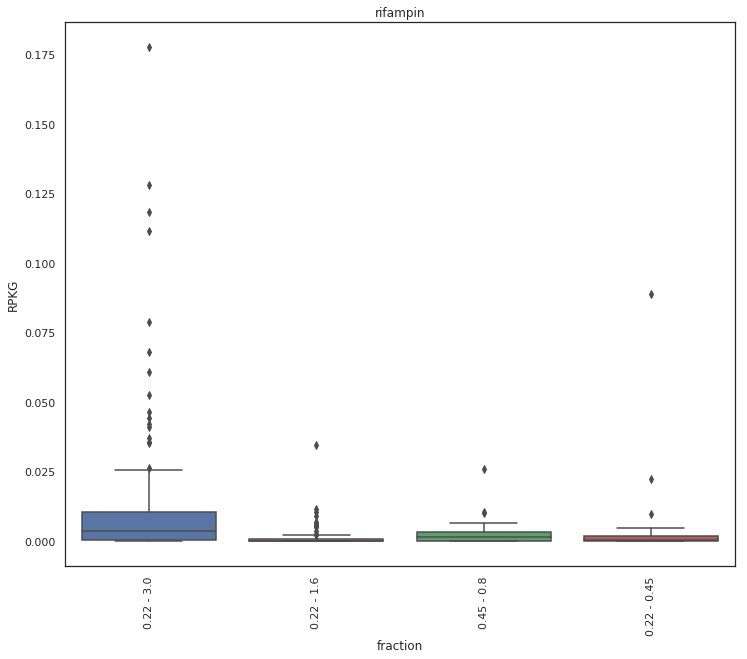

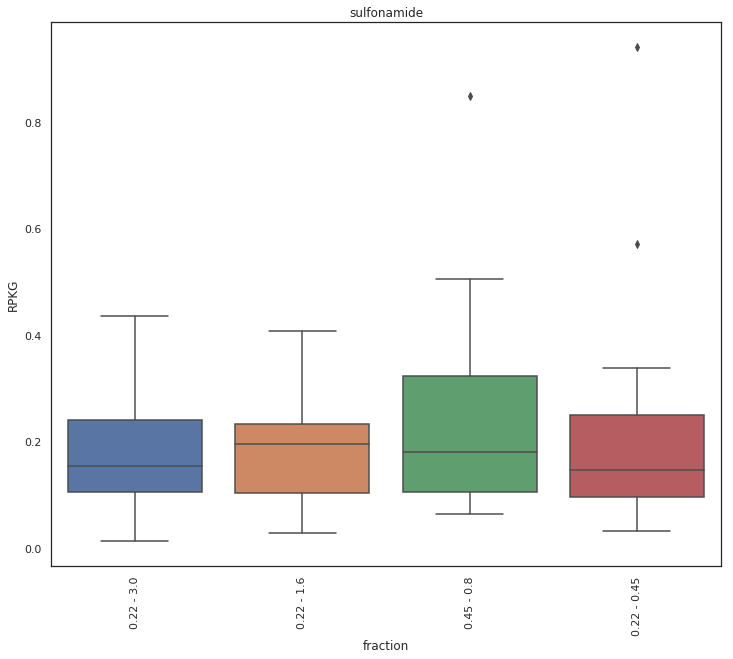

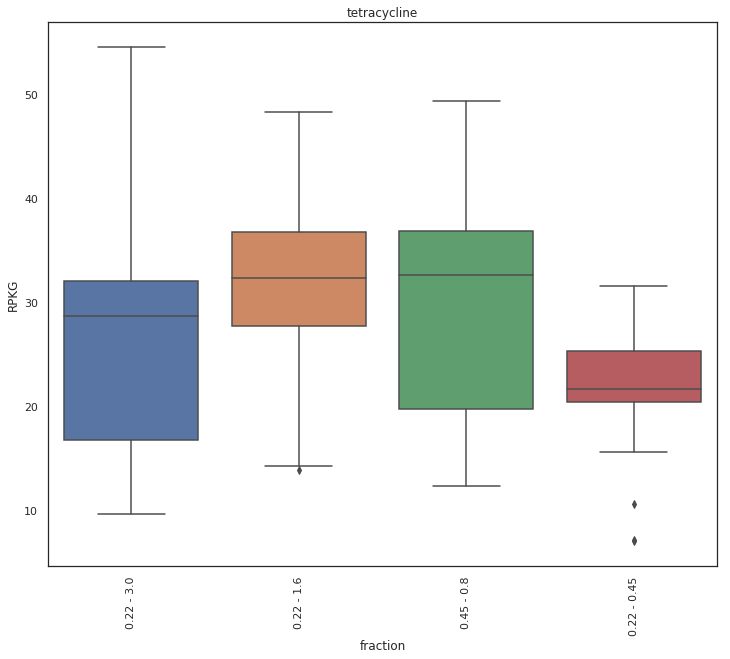

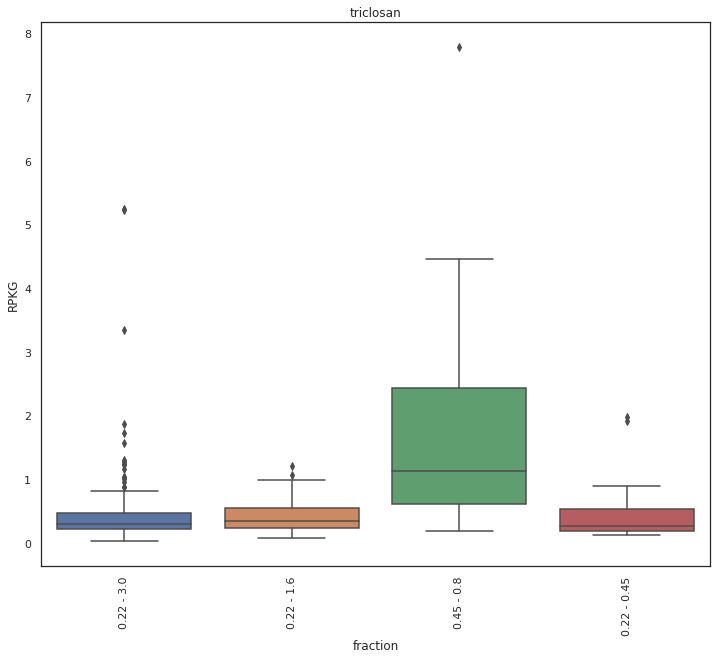

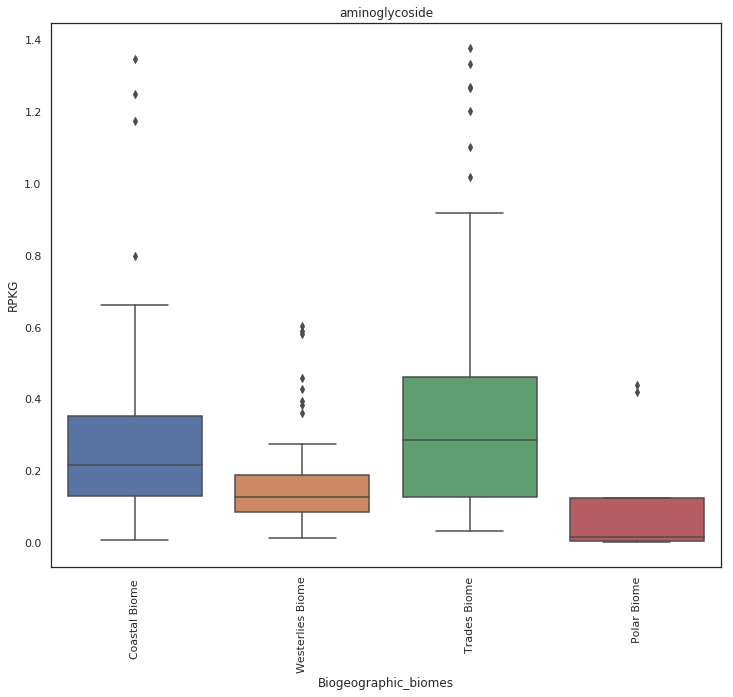

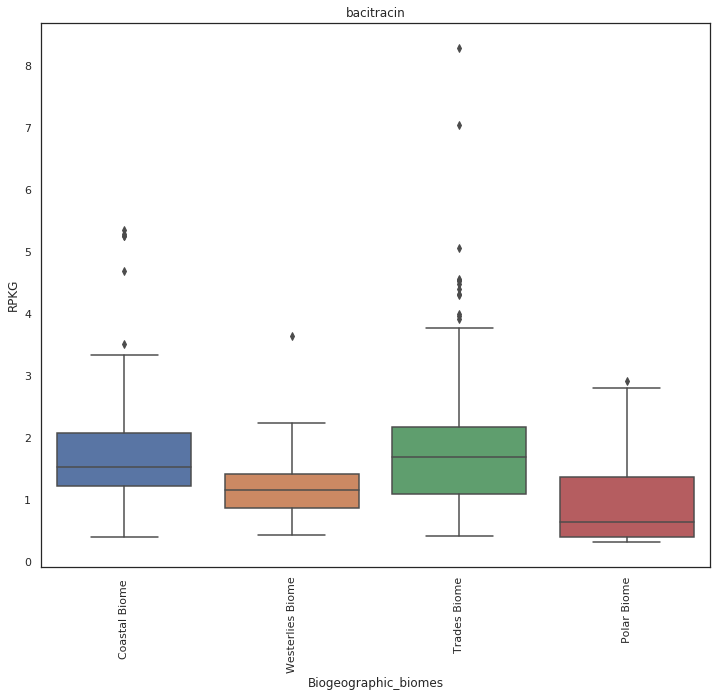

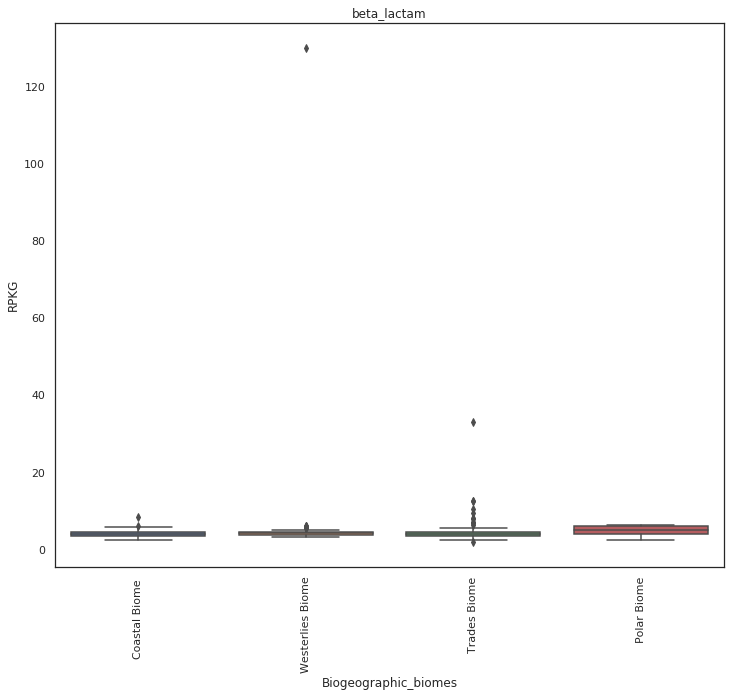

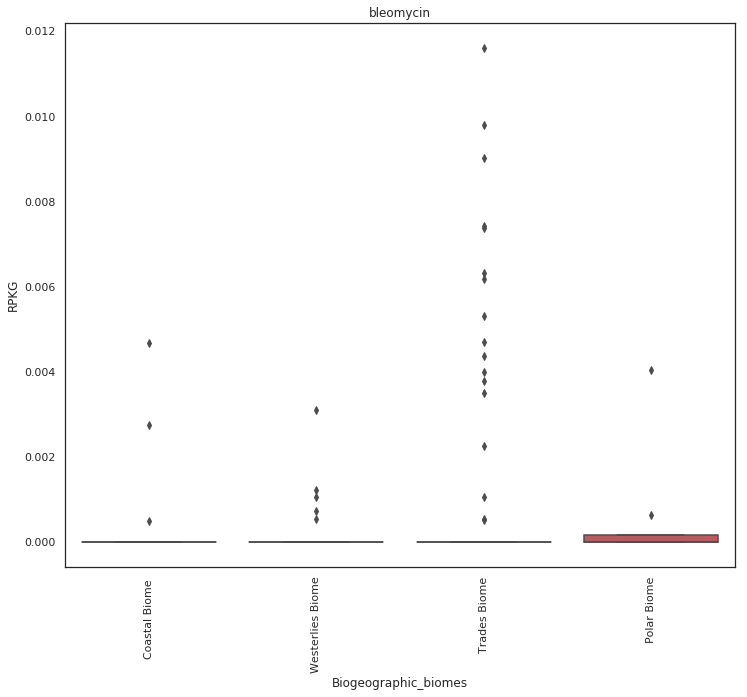

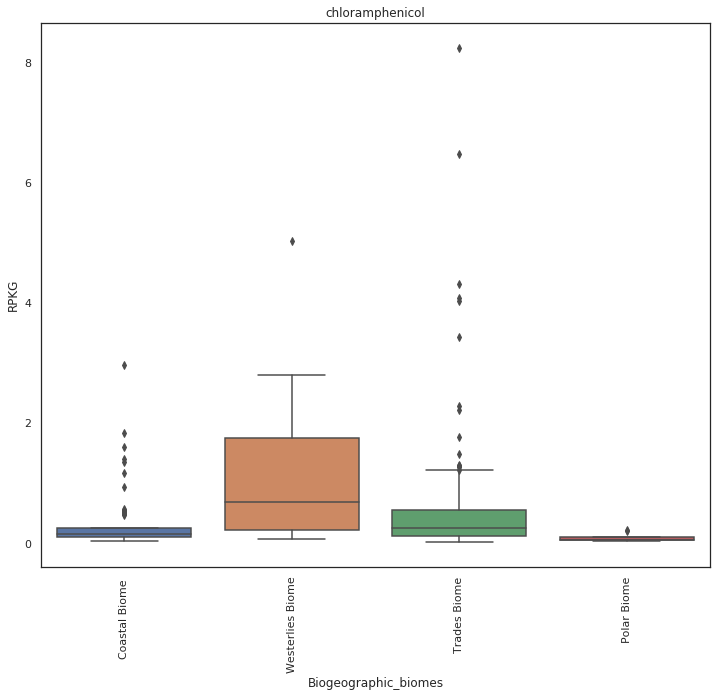

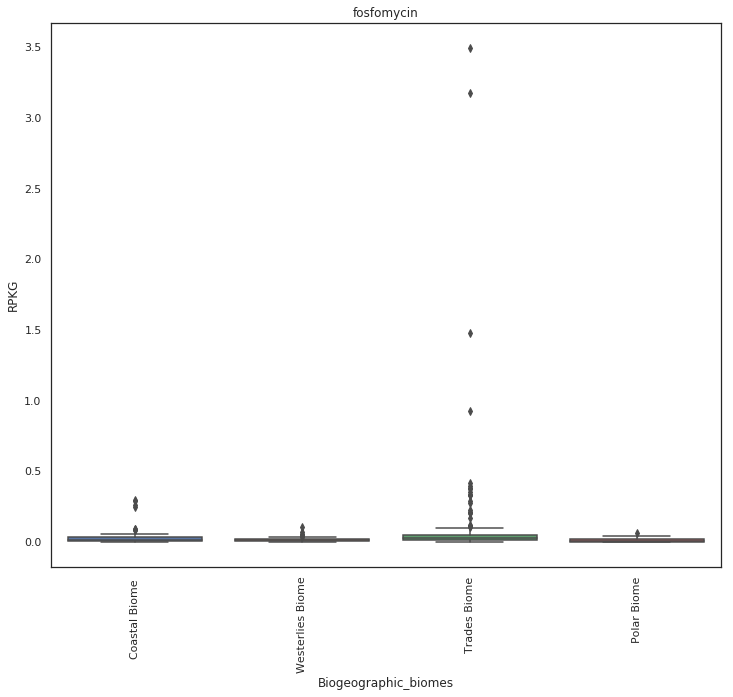

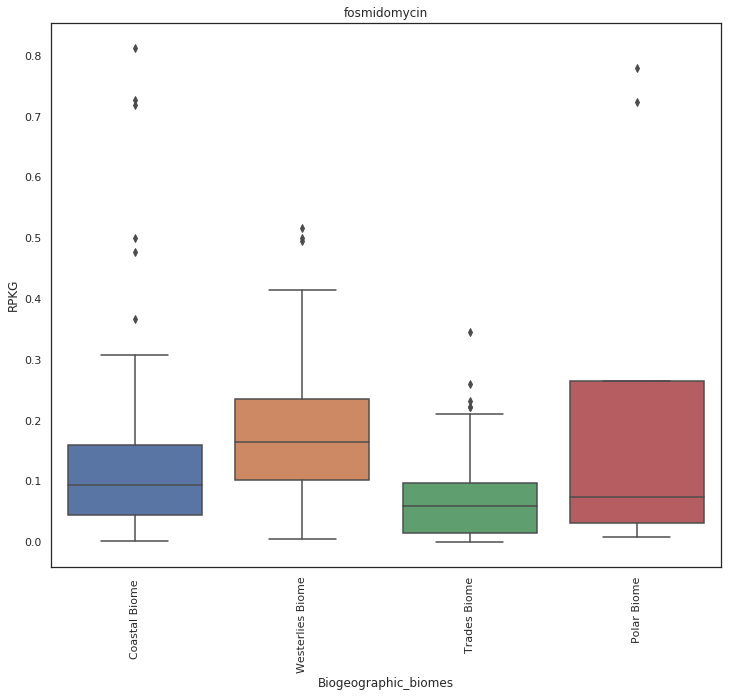

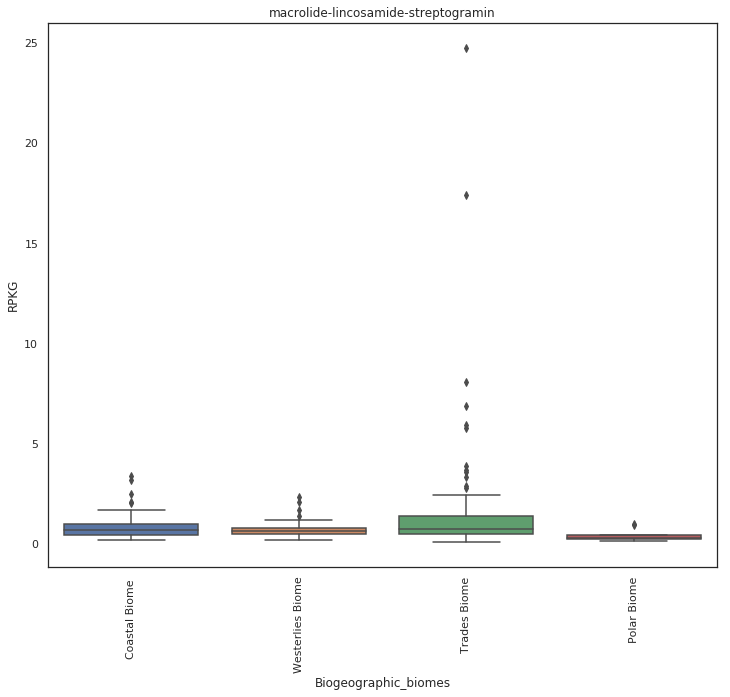

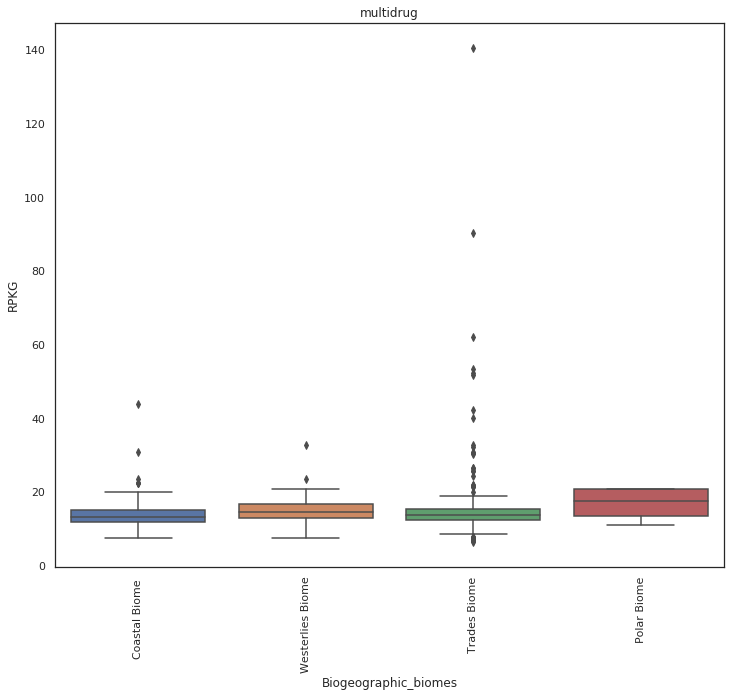

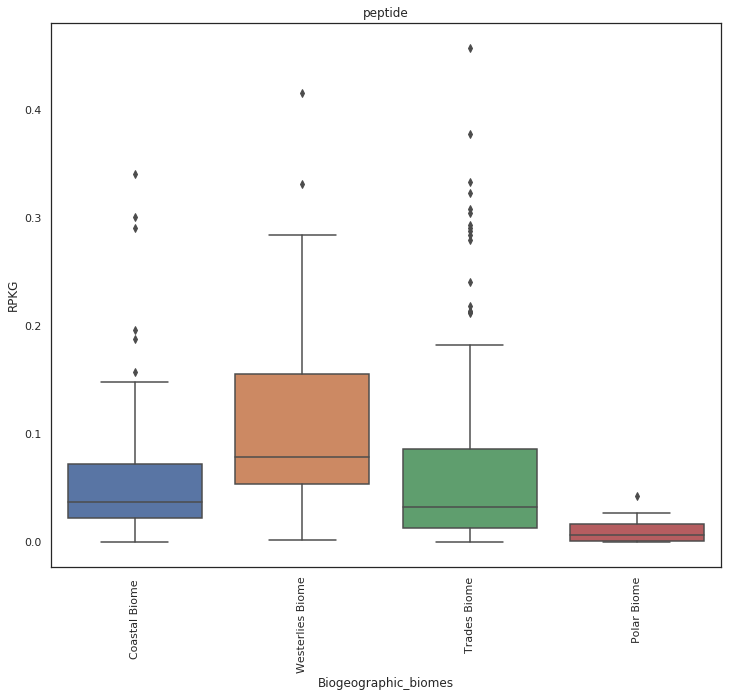

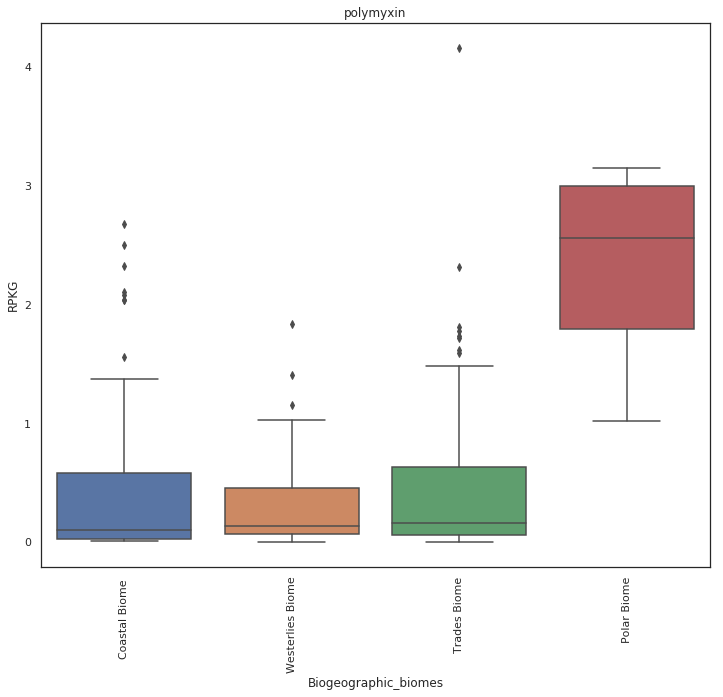

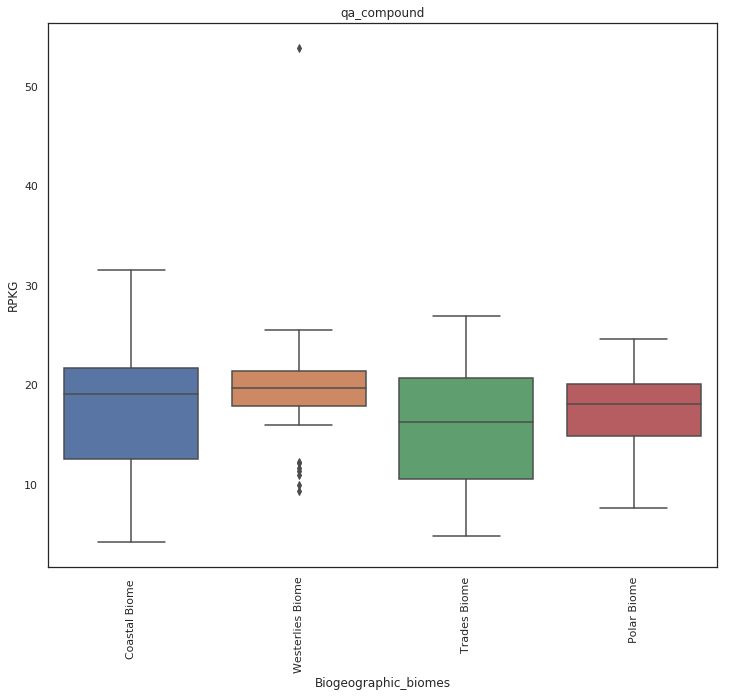

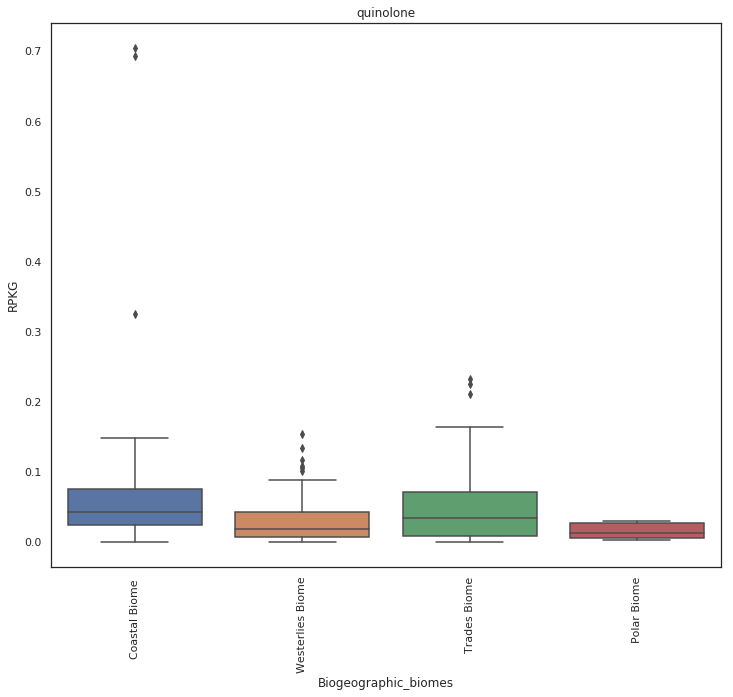

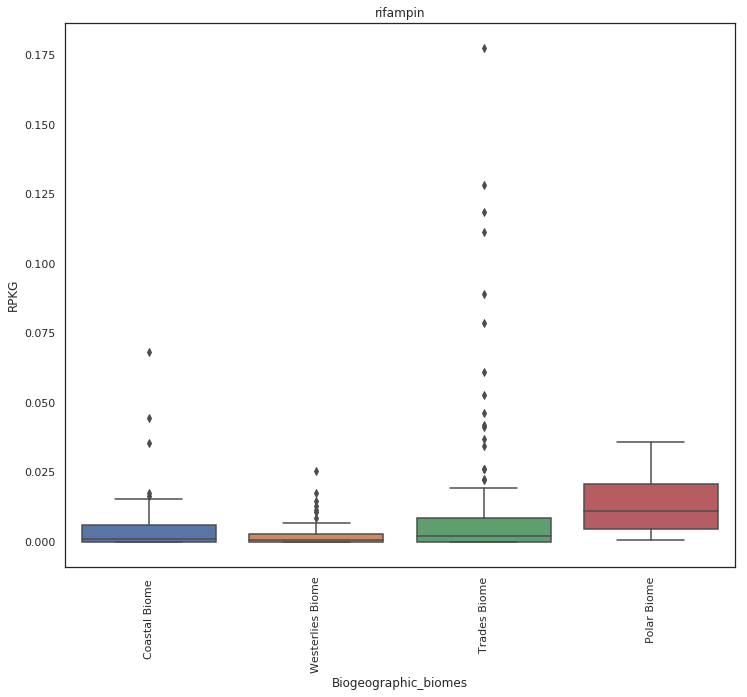

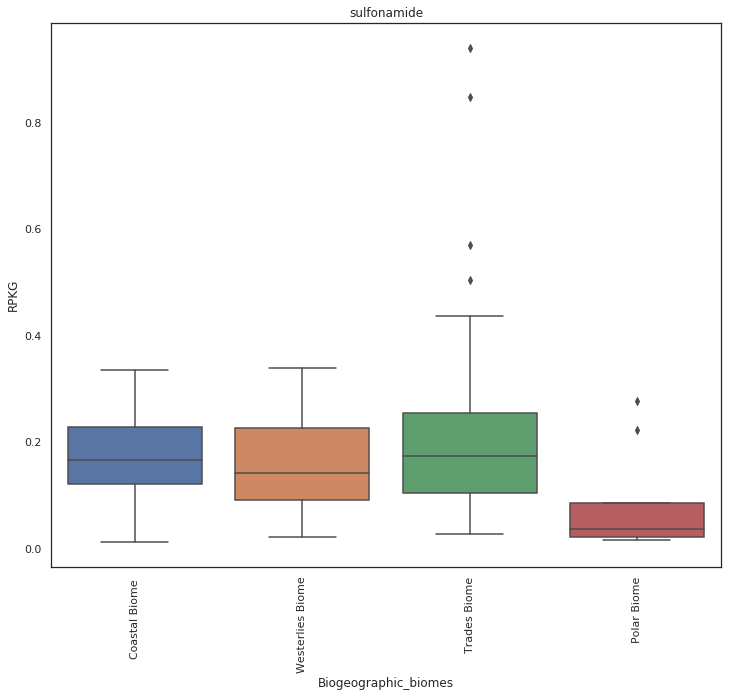

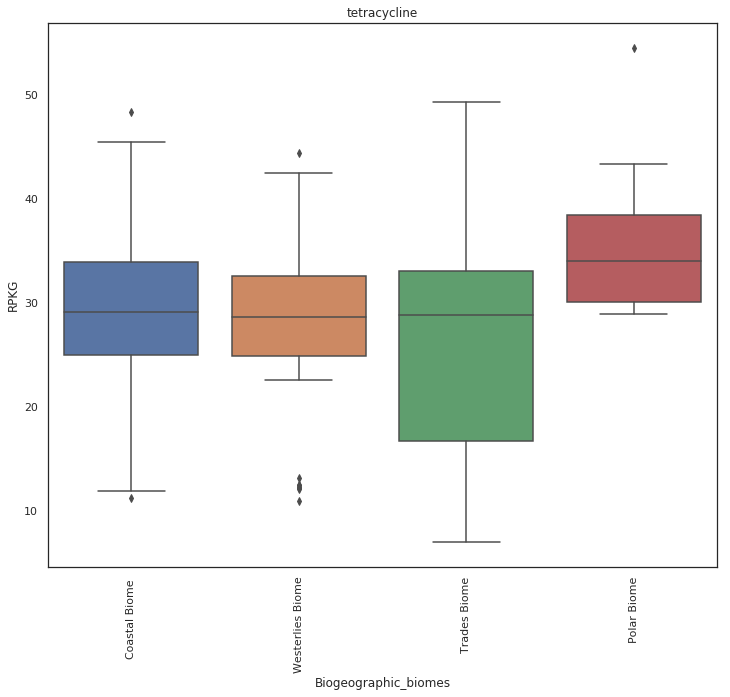

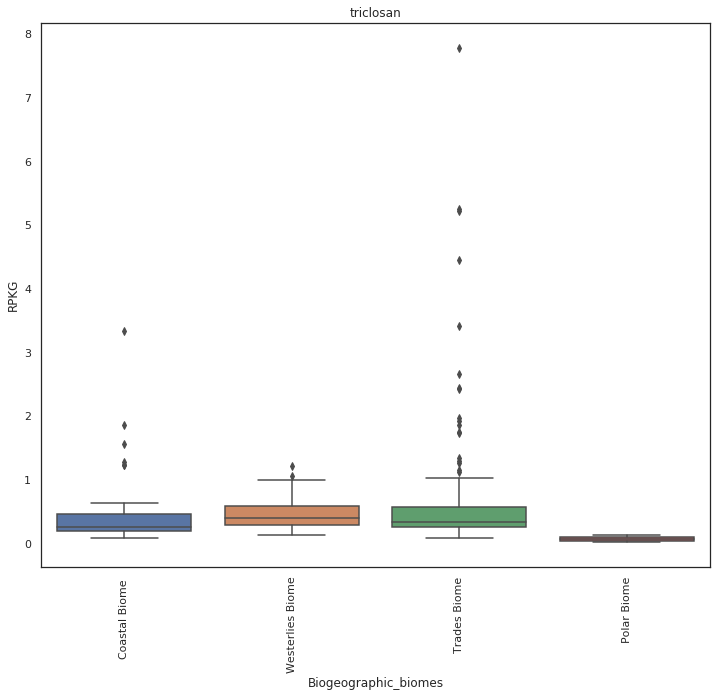

In [192]:
classes=list(classes_RPKG_env_novirus.columns)[0:-6]
env=list(classes_RPKG_env_novirus.columns)[-5:]
for e in env:
    pdf = matplotlib.backends.backend_pdf.PdfPages(out+"boxplots_RPKG_"+e +".pdf")
    for c in classes:
        fig=plt.figure(figsize=(12,10))
        sns.boxplot(classes_RPKG_env_novirus[e],classes_RPKG_env_novirus[c])
        plt.xticks(rotation=90)
        plt.ylabel("RPKG")
        plt.title(c)
        pdf.savefig( fig )
        plt.show()
    pdf.close()
    plt.close()

/home/rcuadrat/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



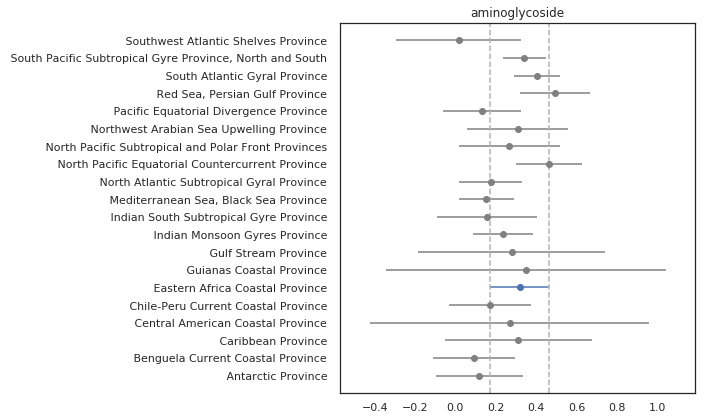

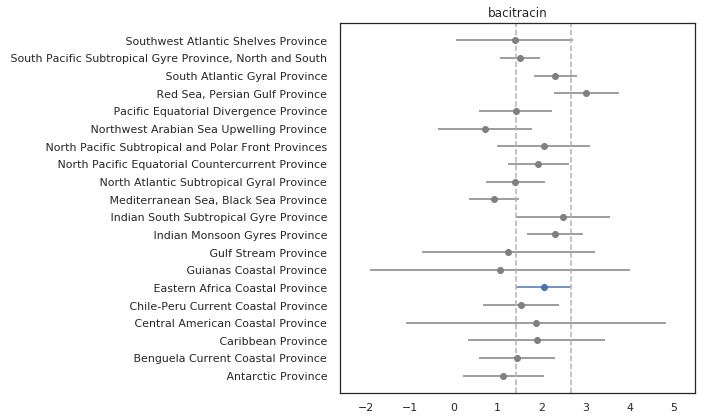

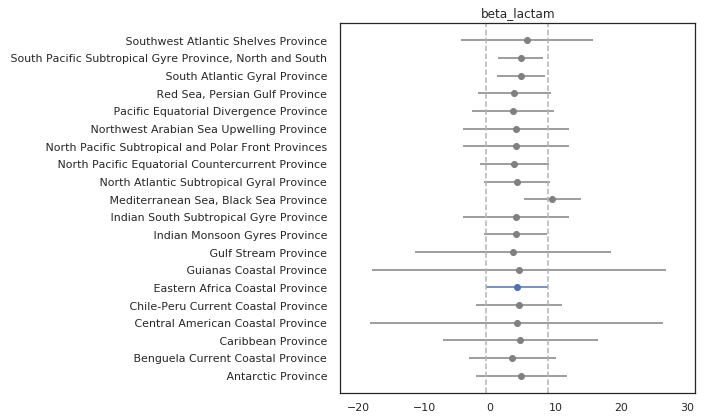

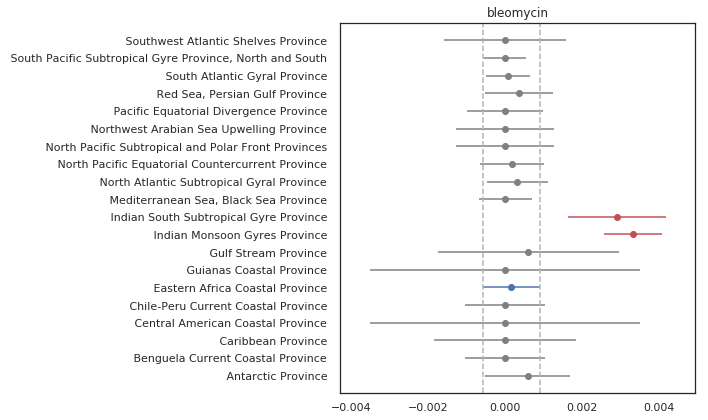

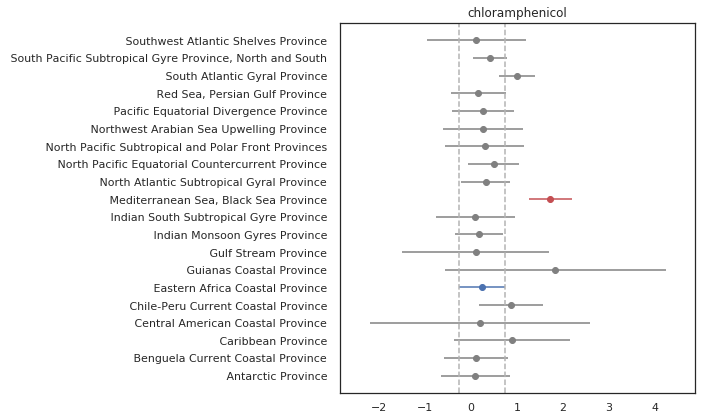

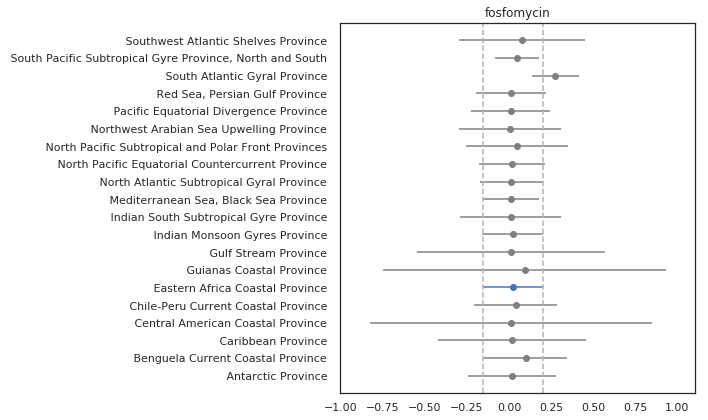

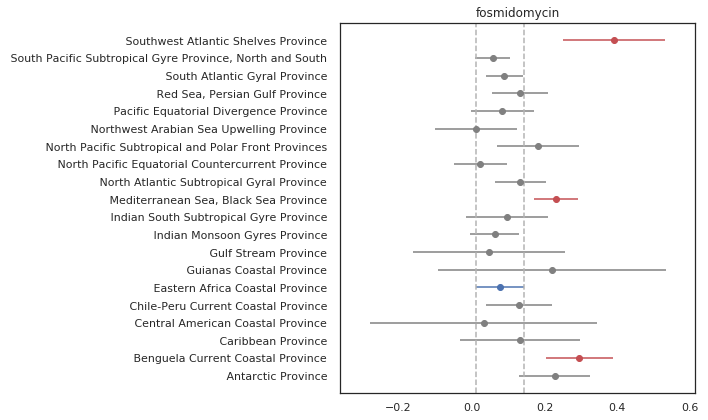

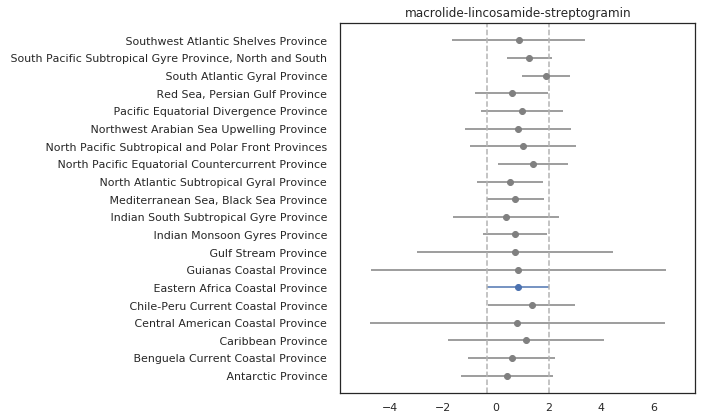

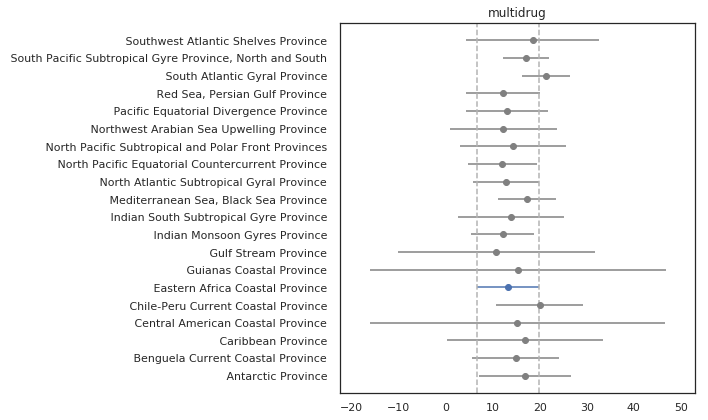

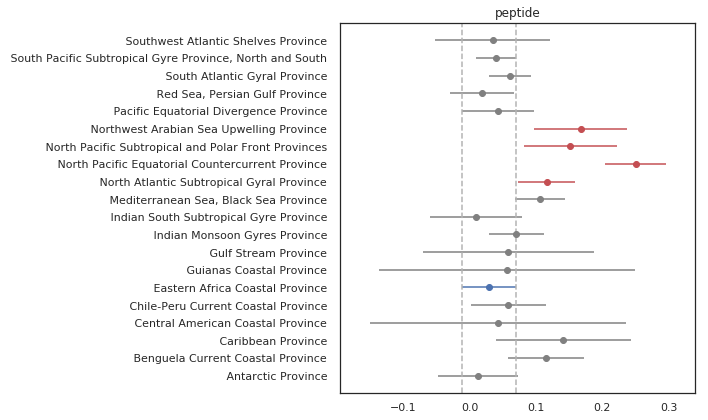

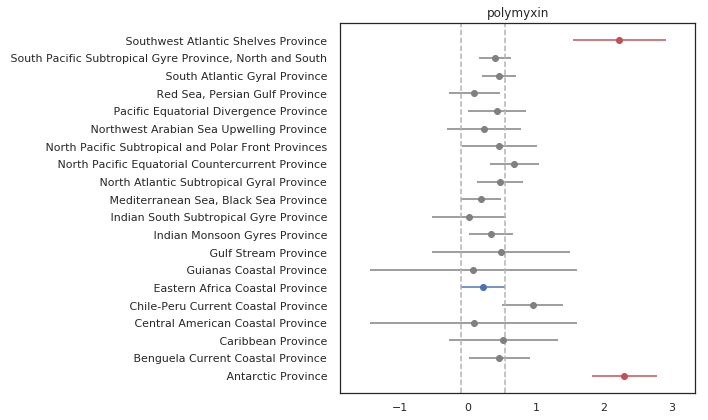

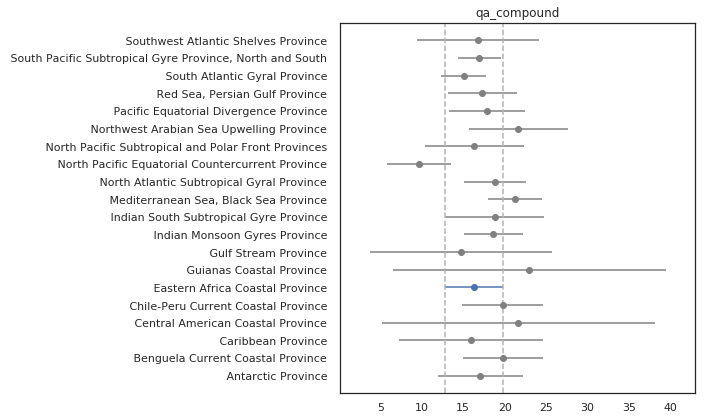

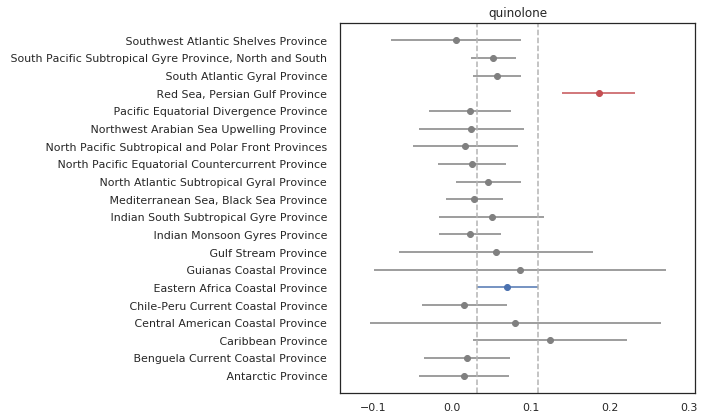

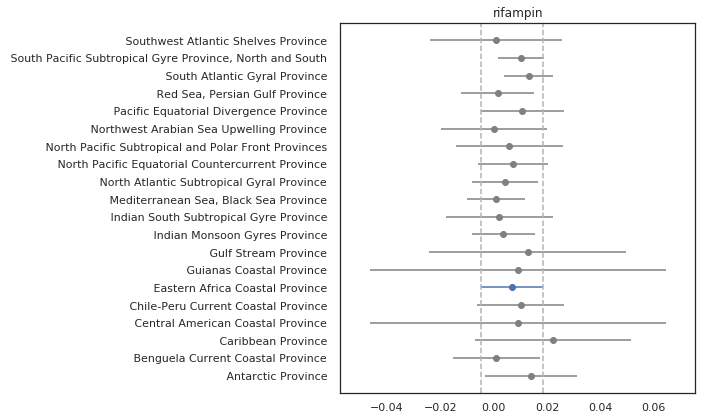

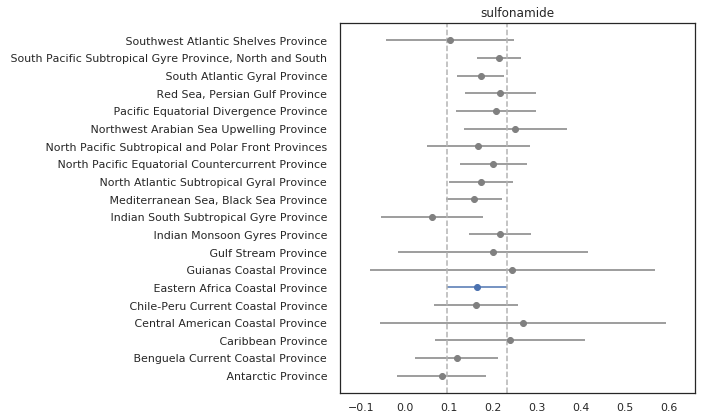

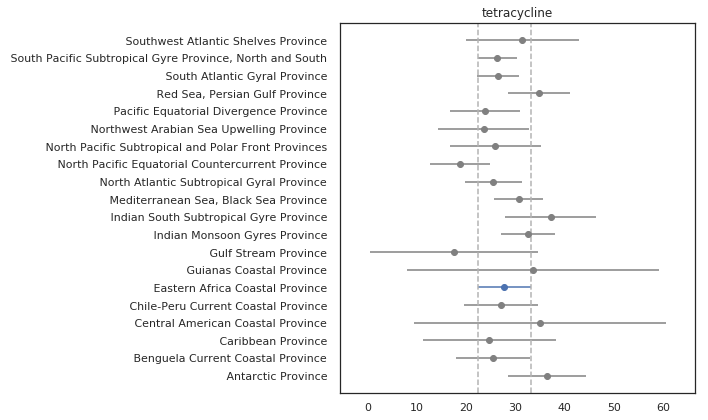

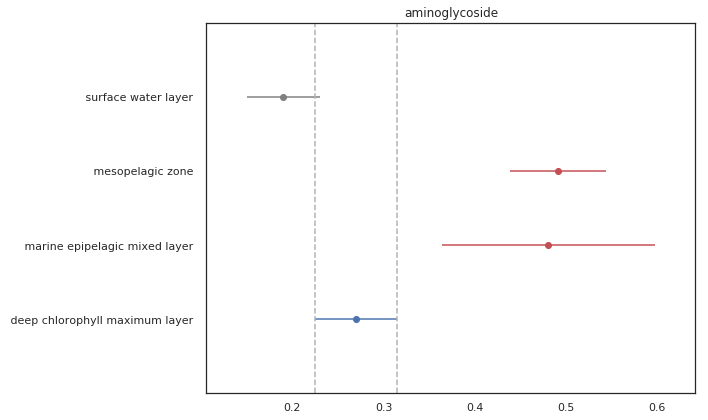

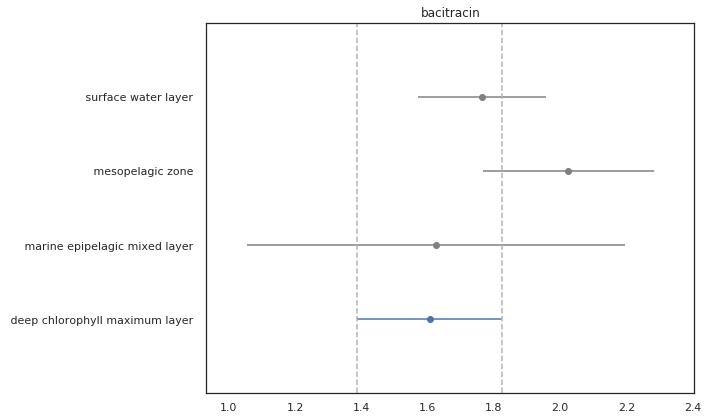

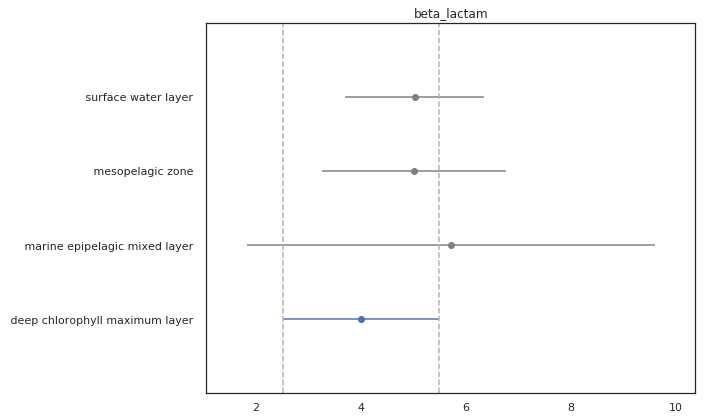

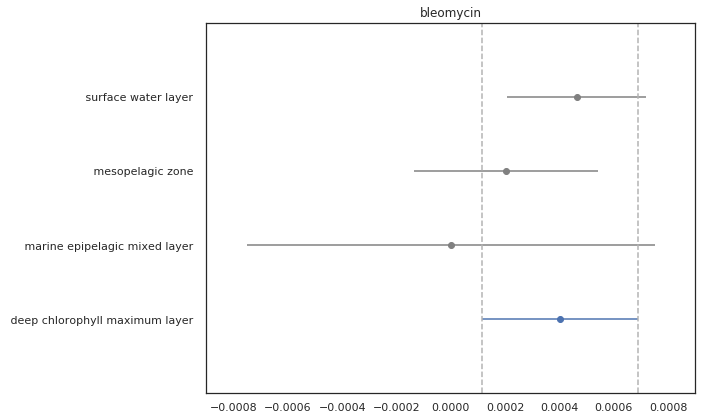

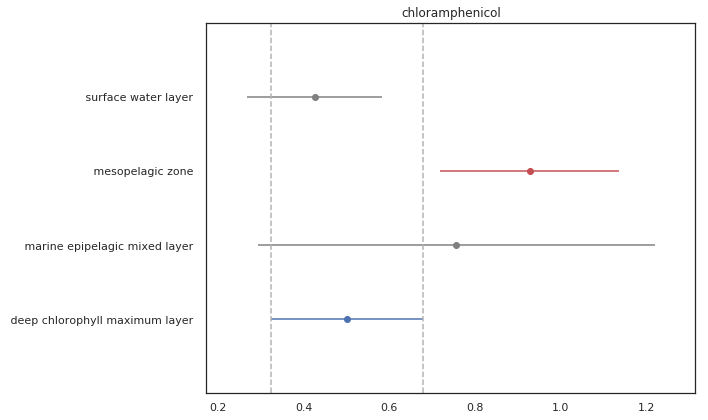

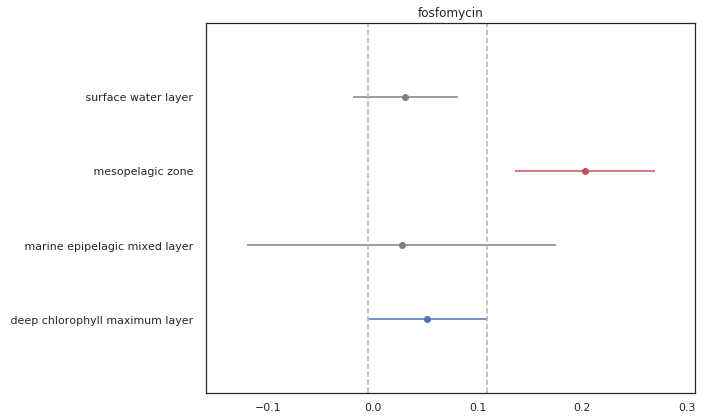

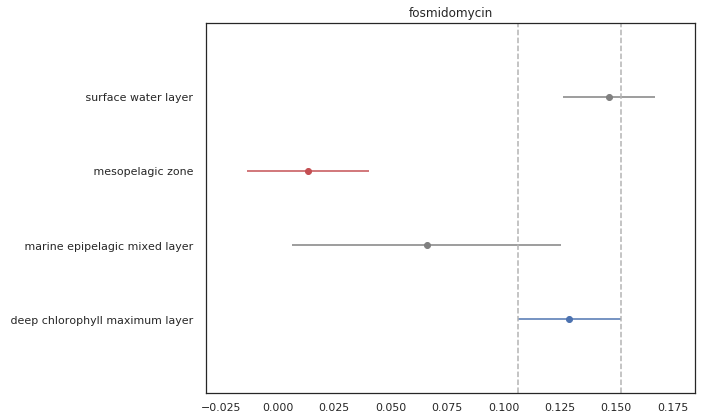

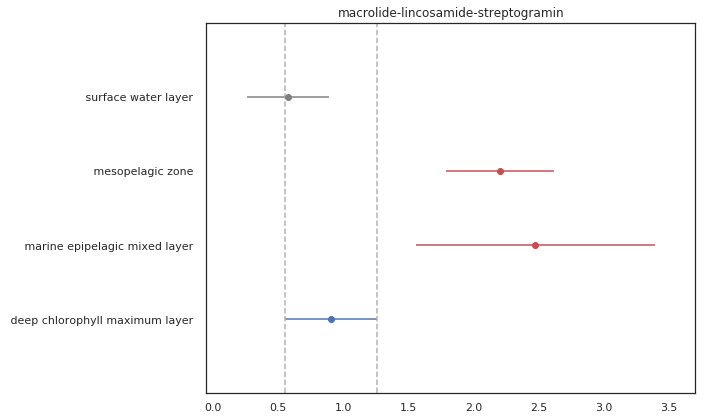

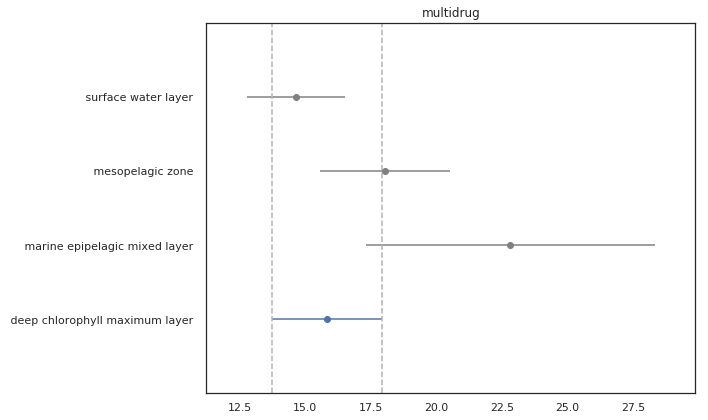

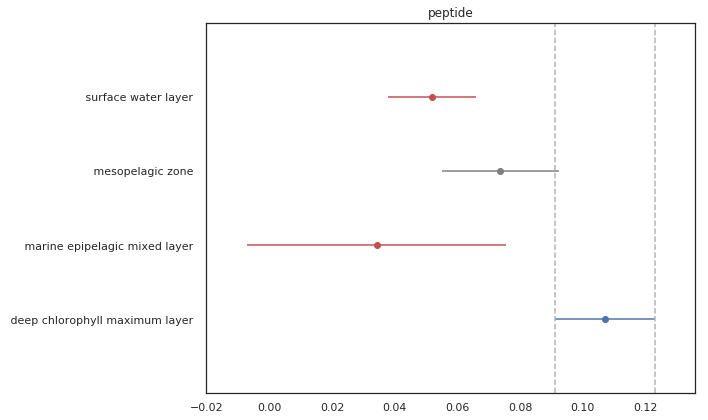

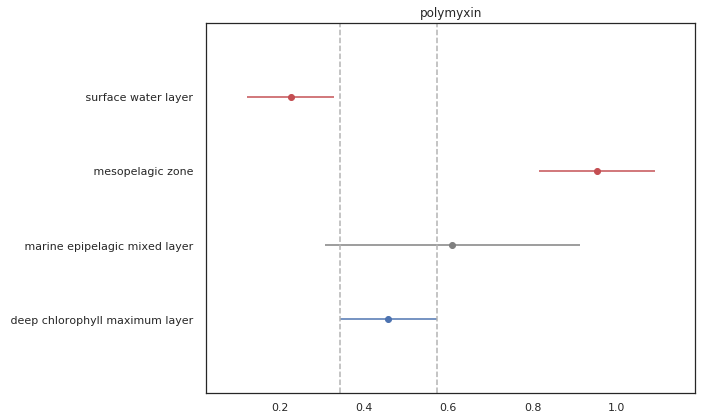

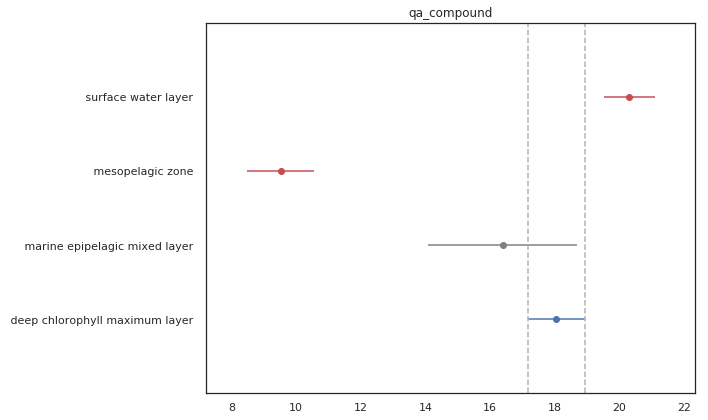

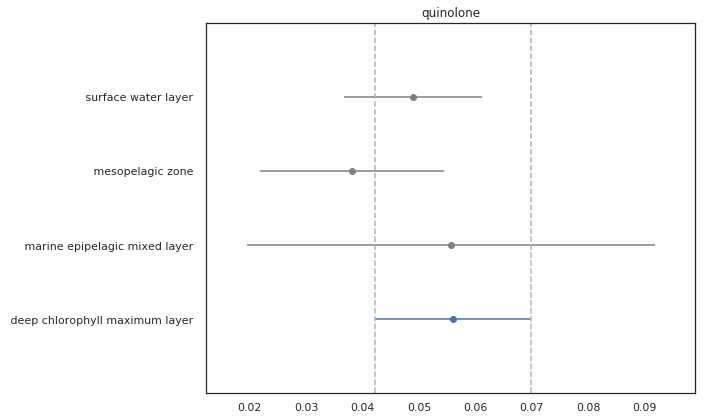

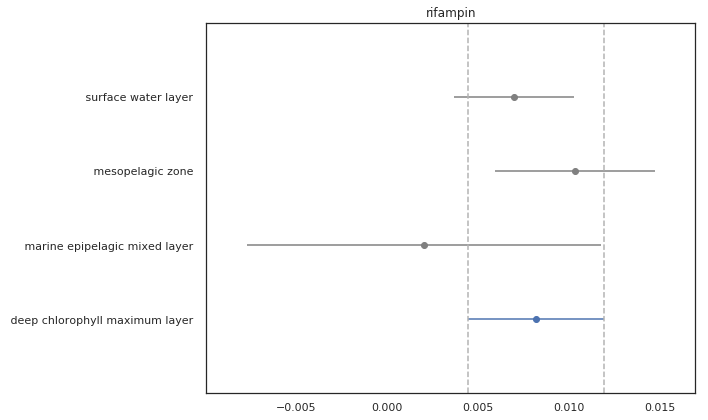

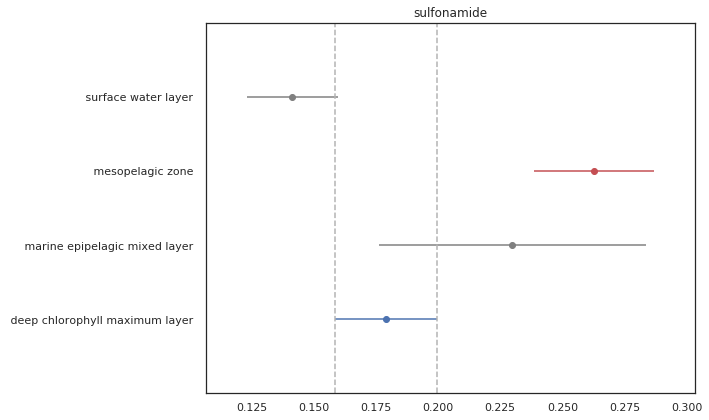

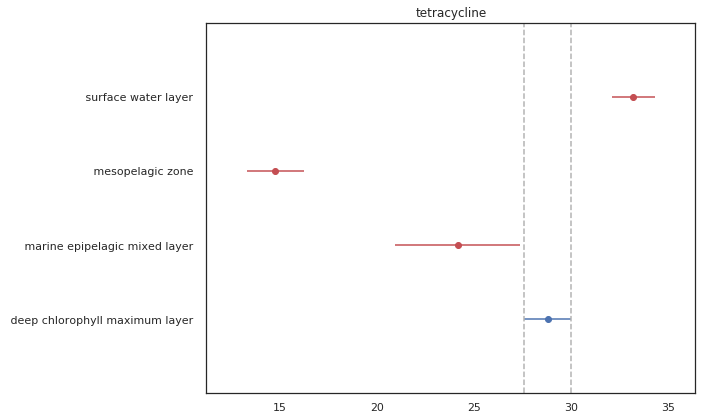

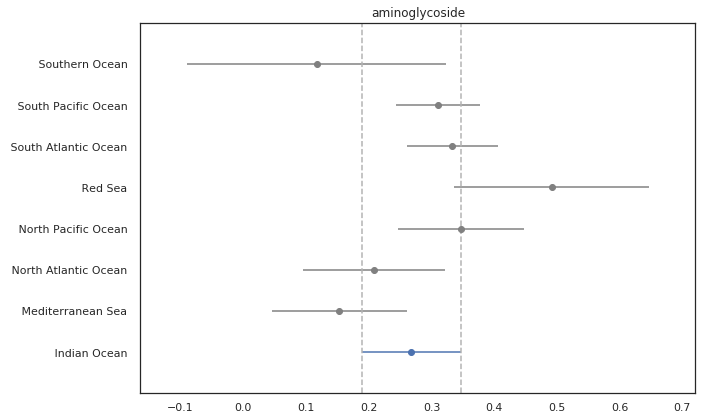

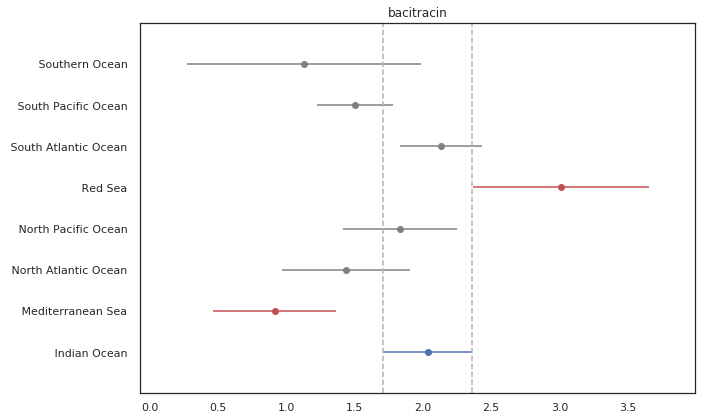

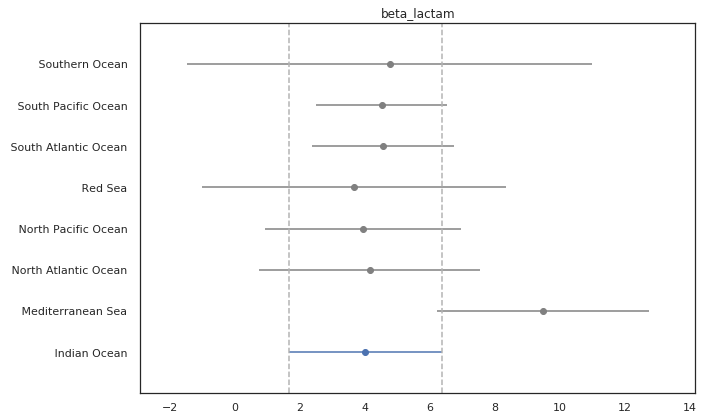

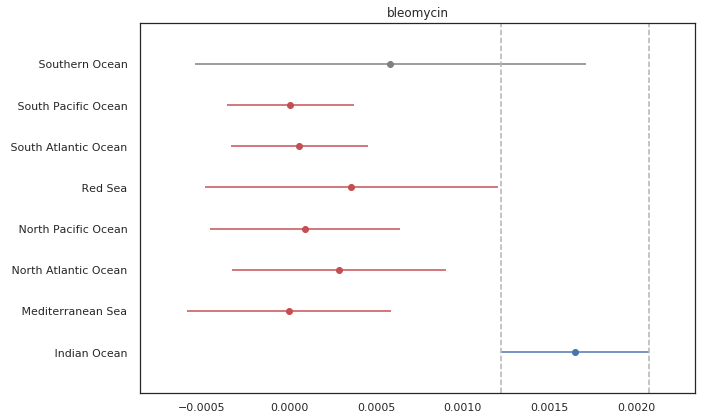

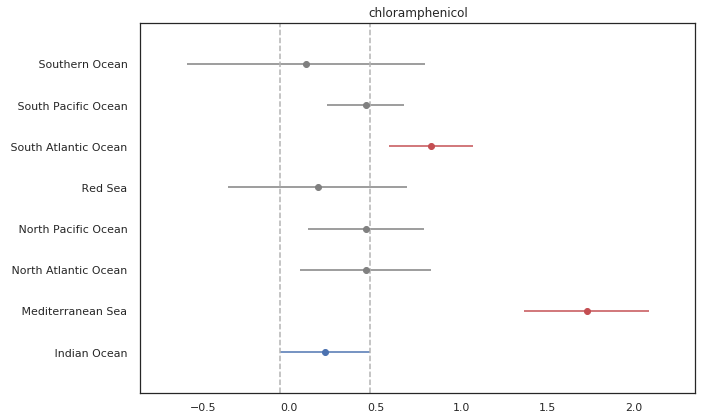

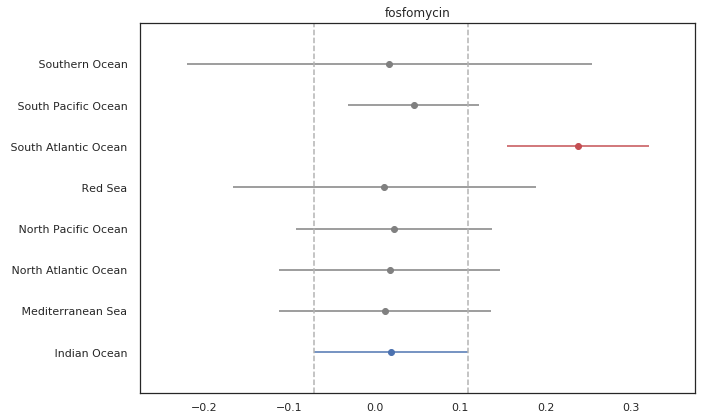

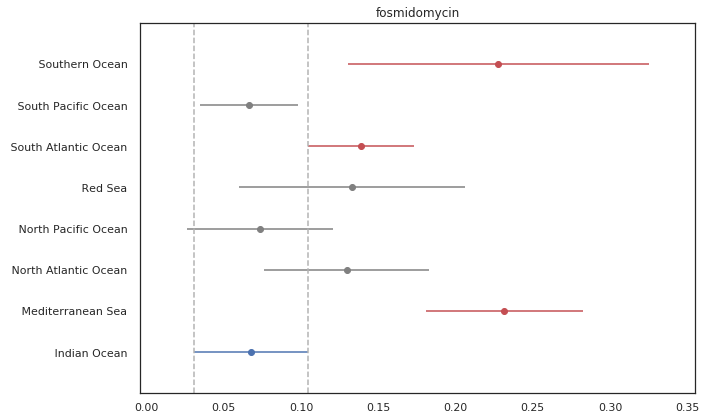

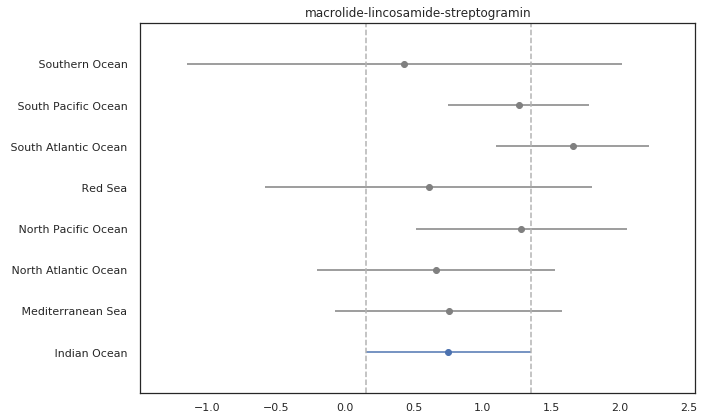

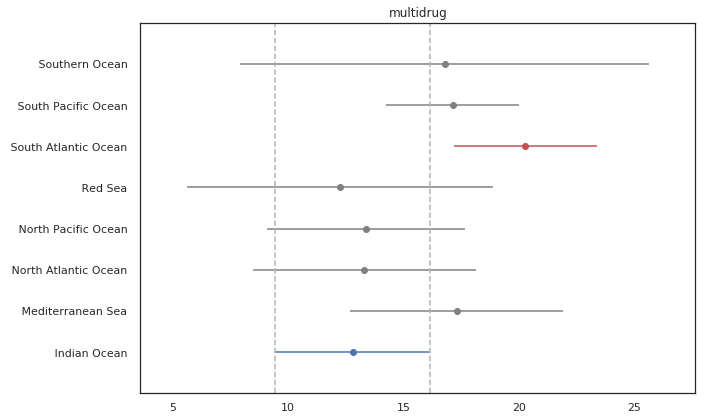

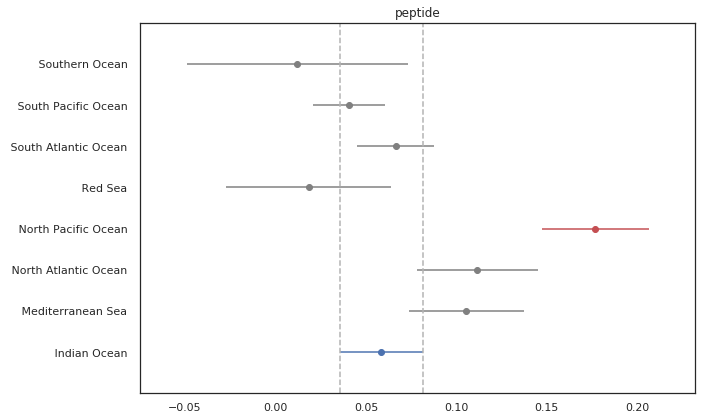

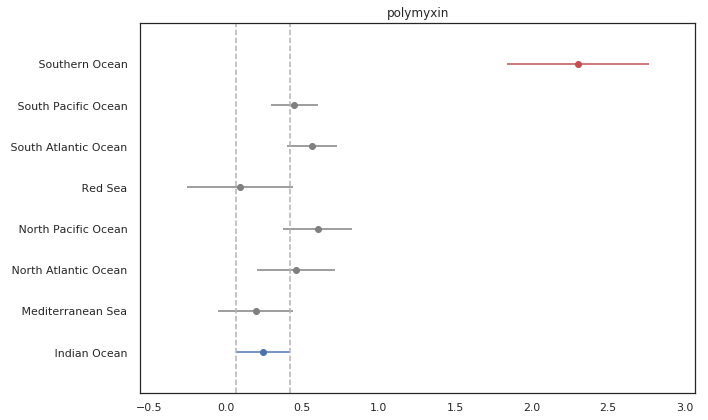

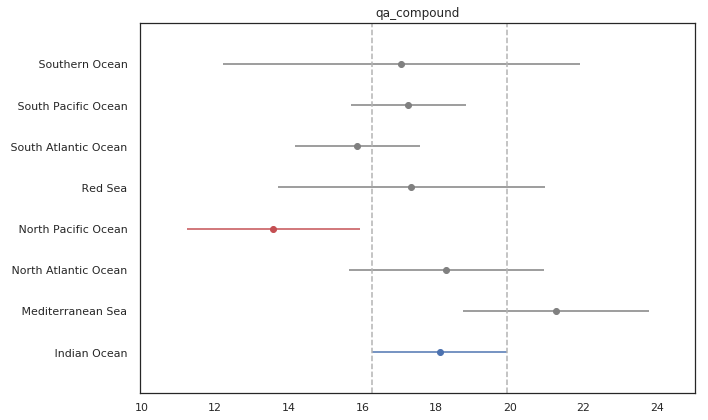

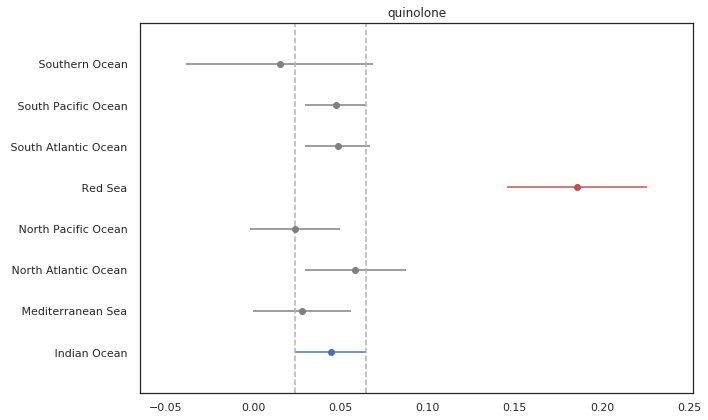

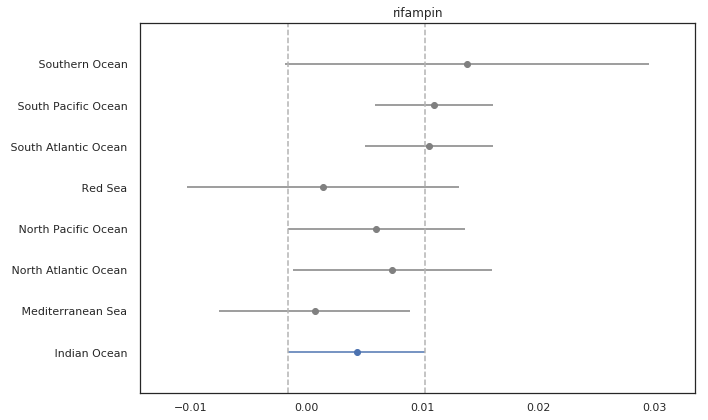

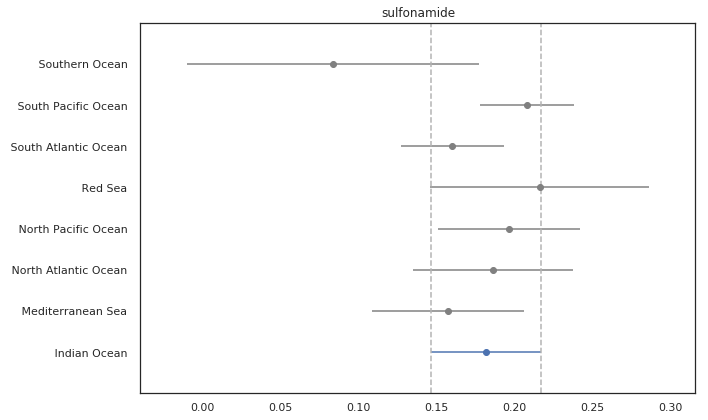

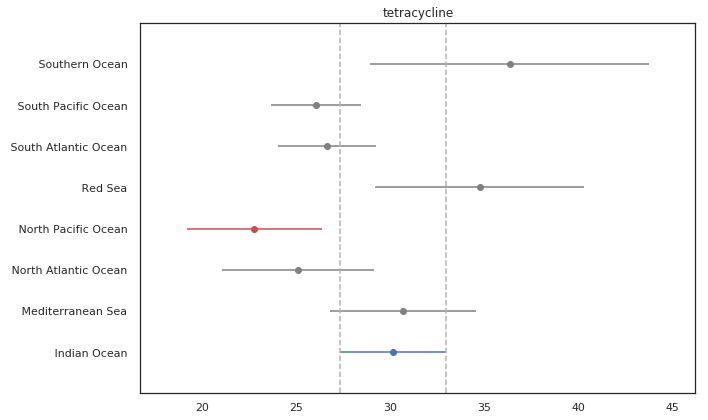

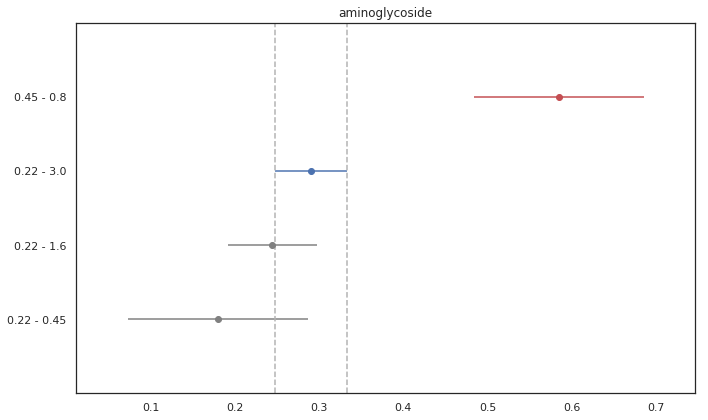

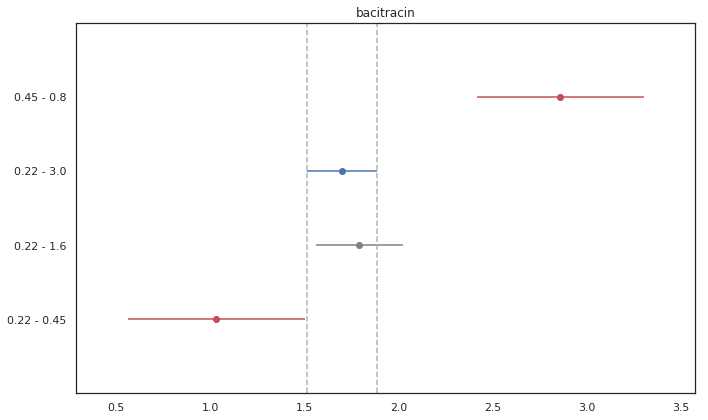

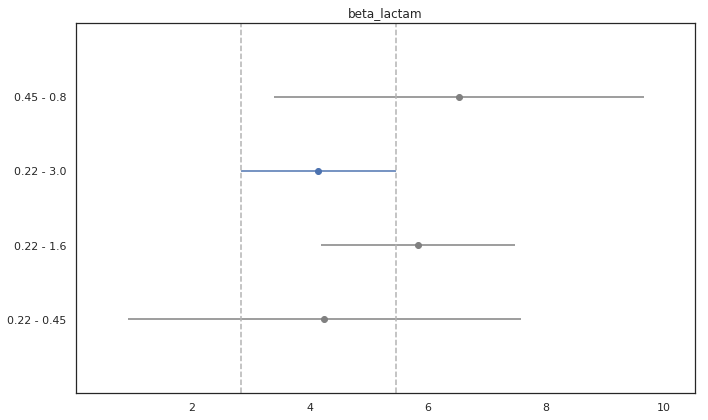

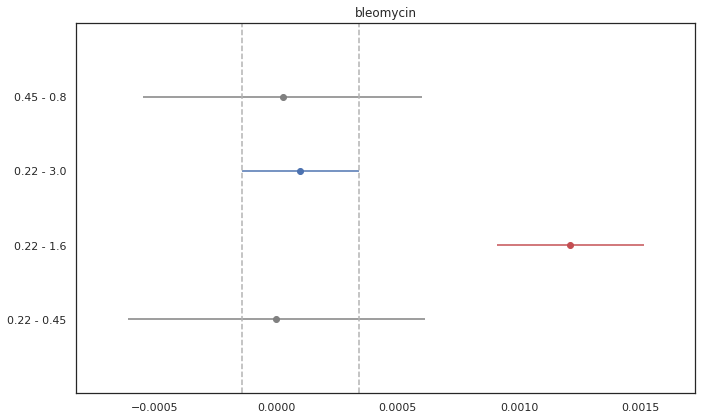

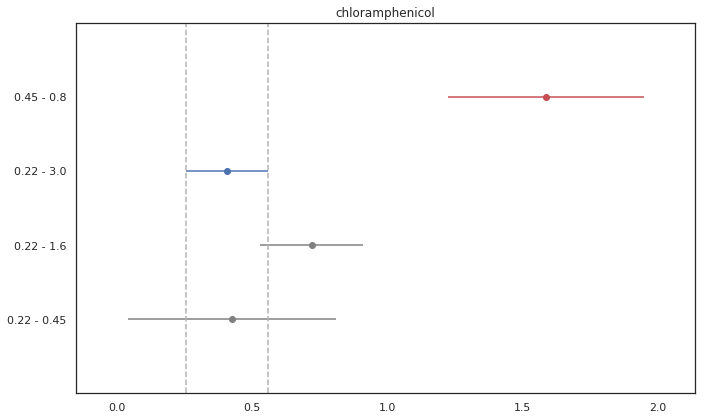

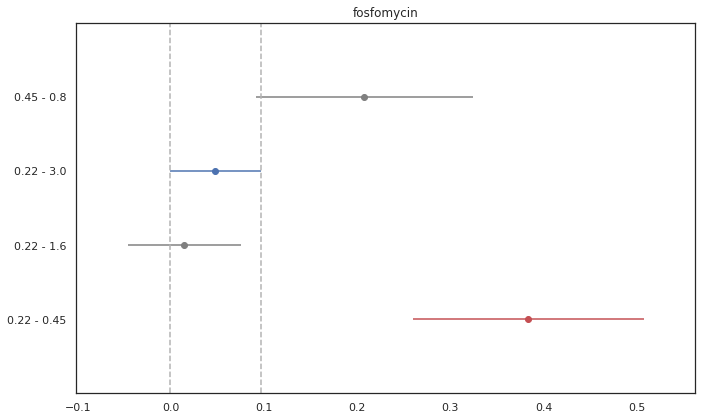

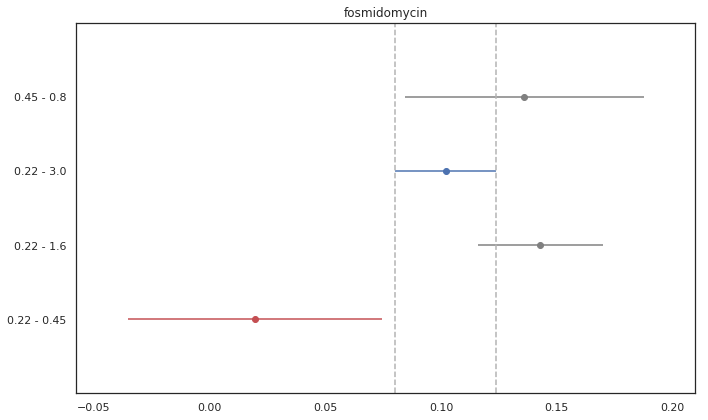

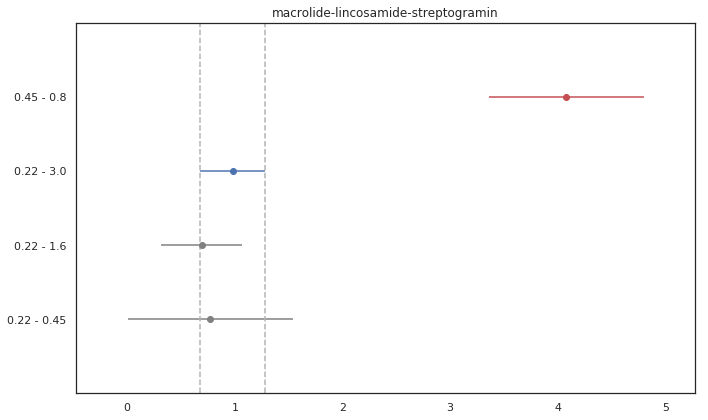

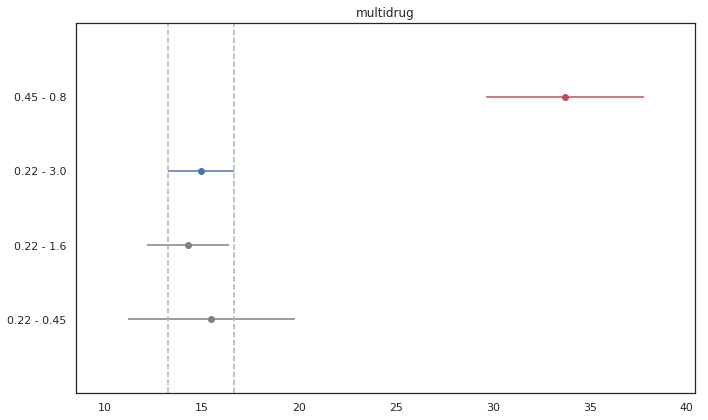

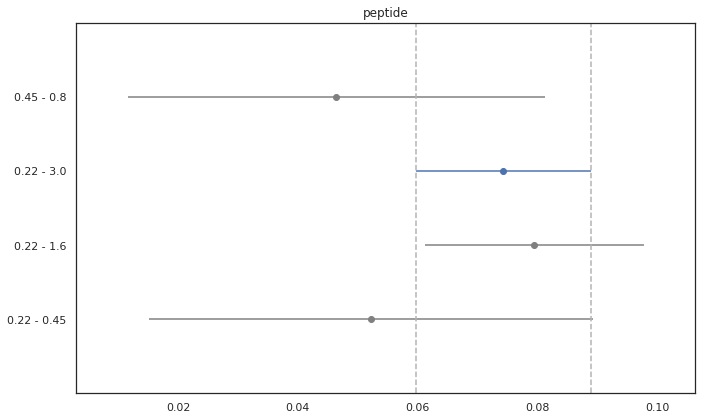

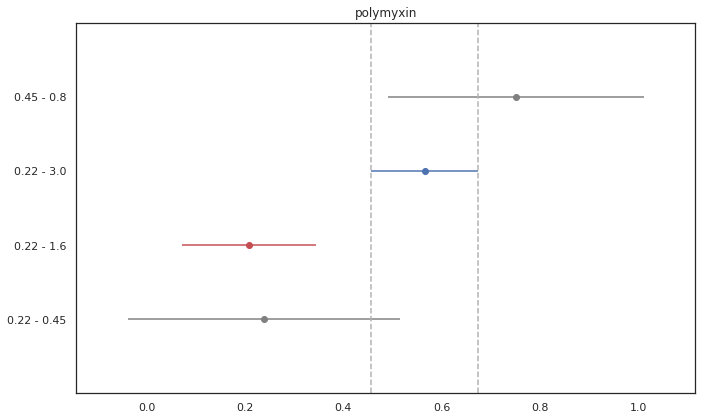

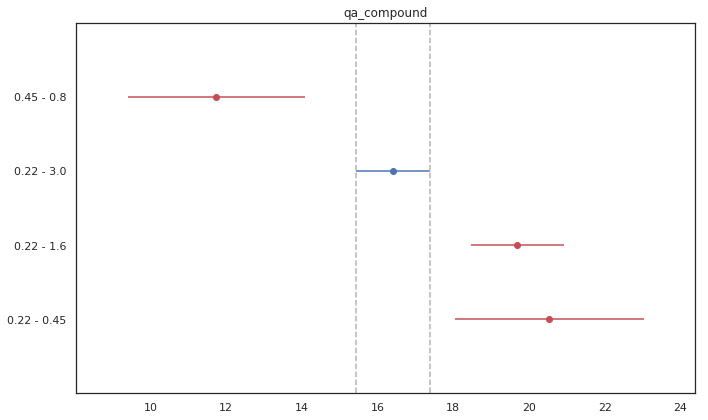

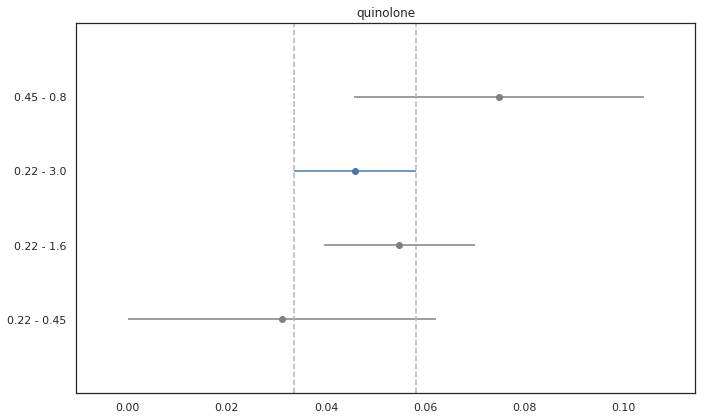

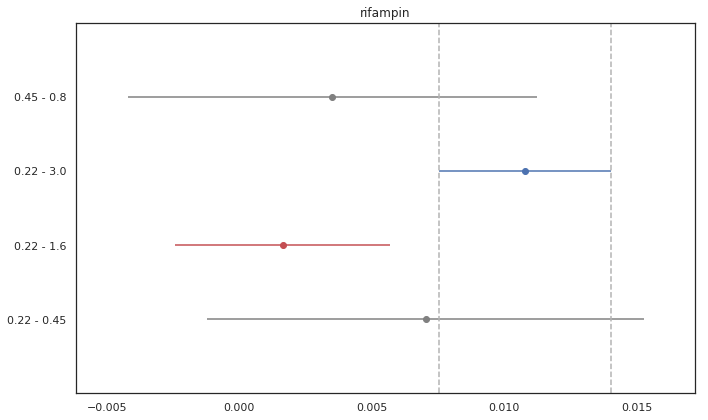

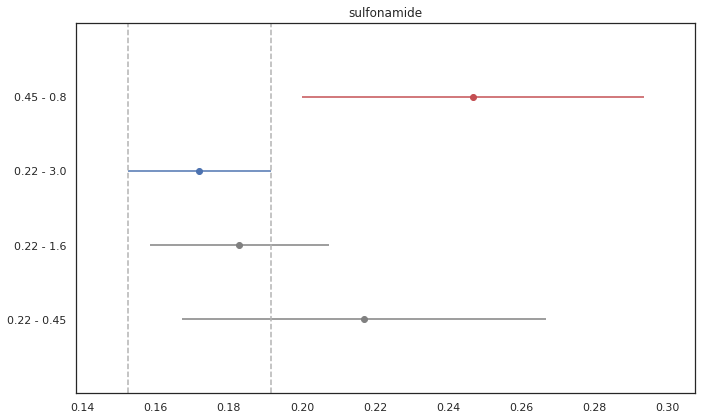

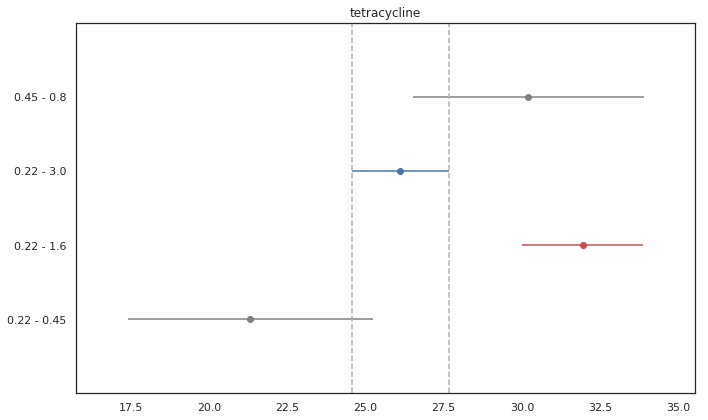

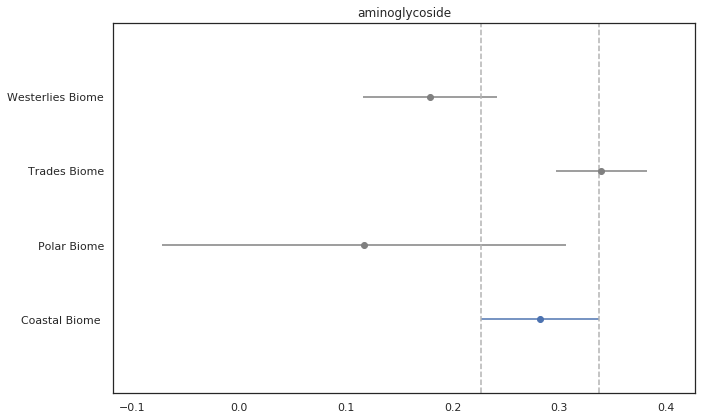

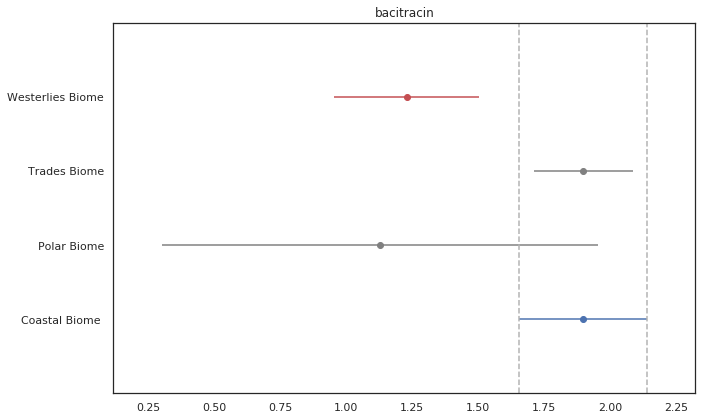

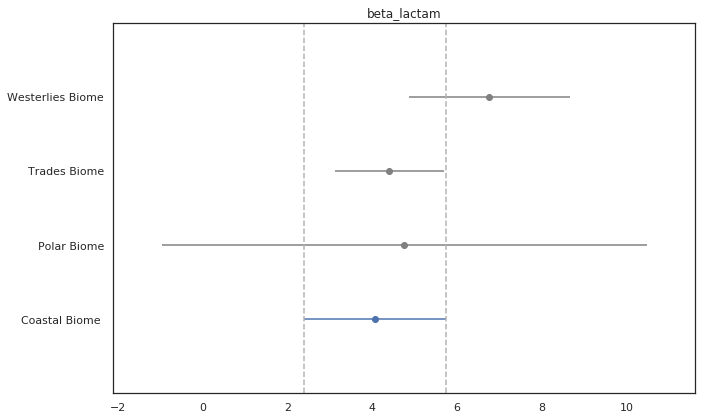

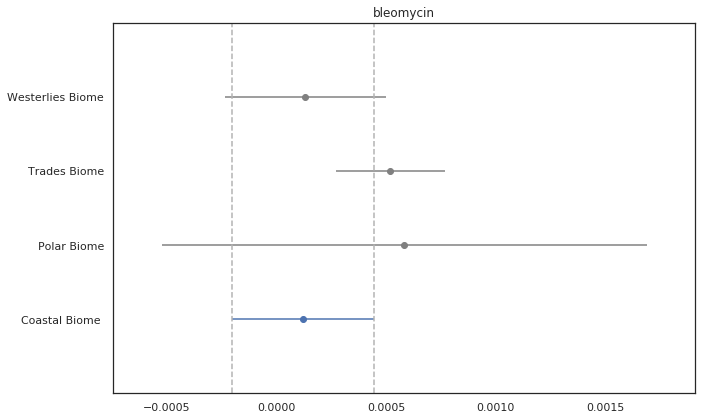

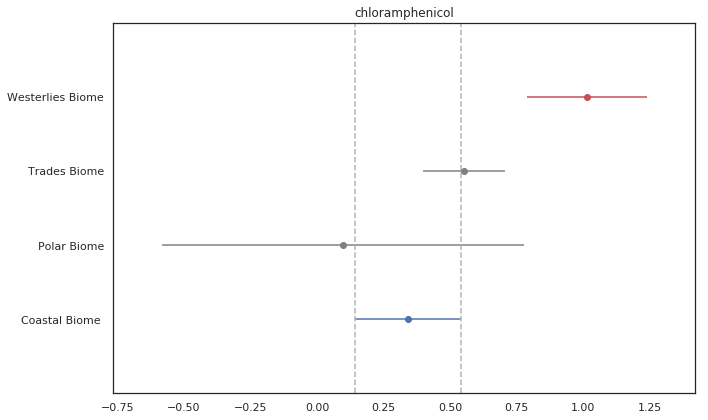

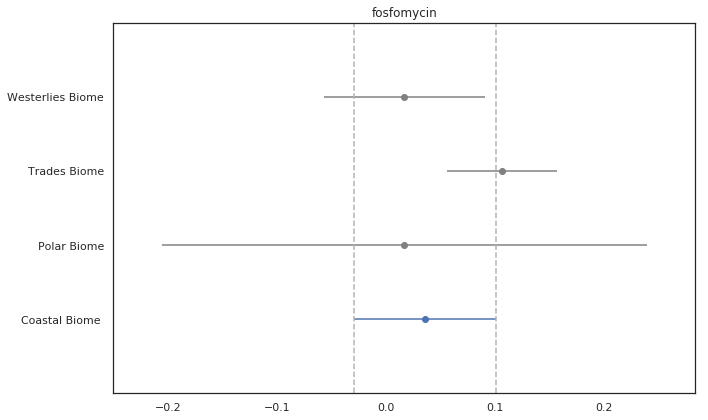

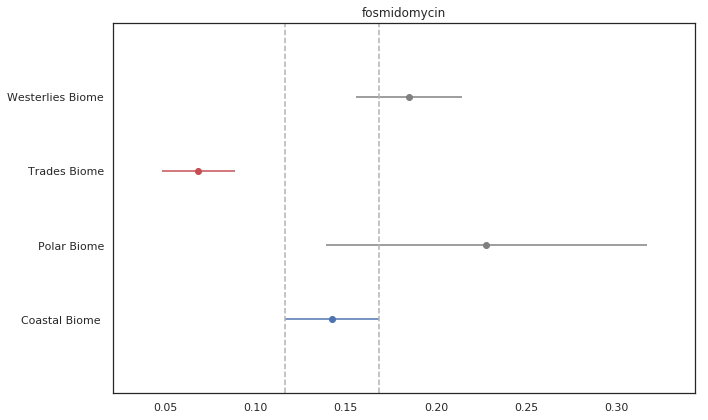

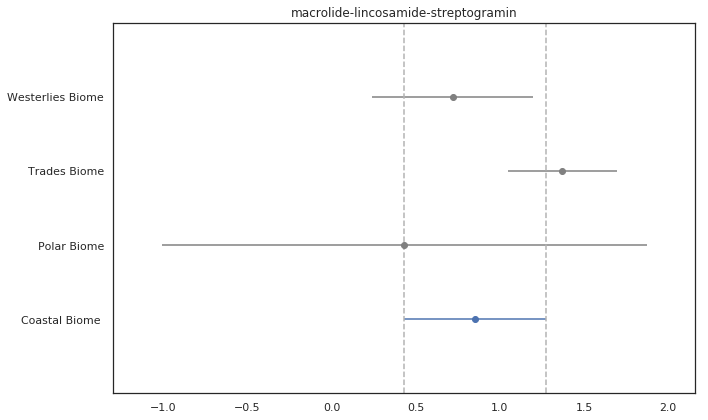

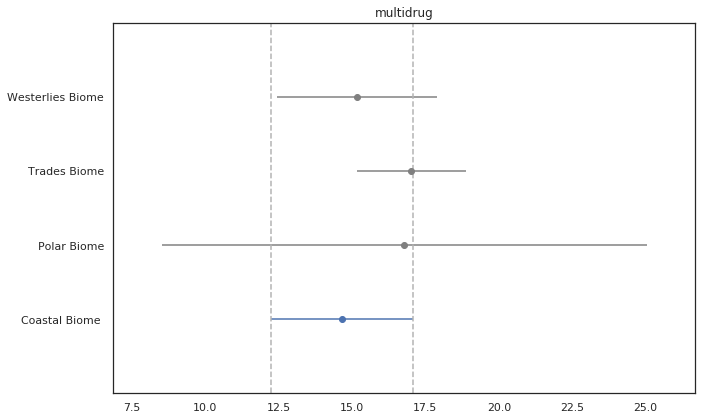

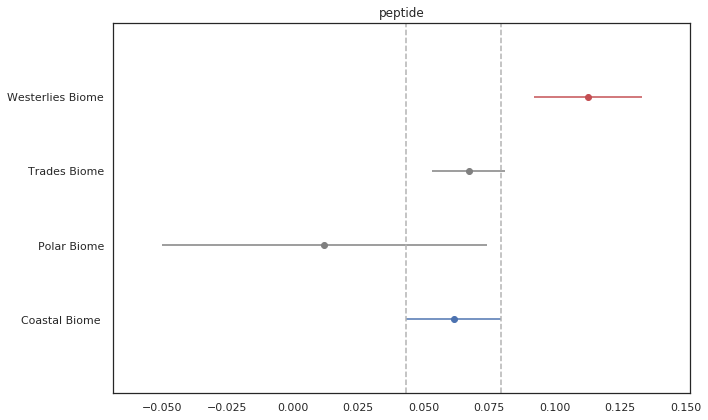

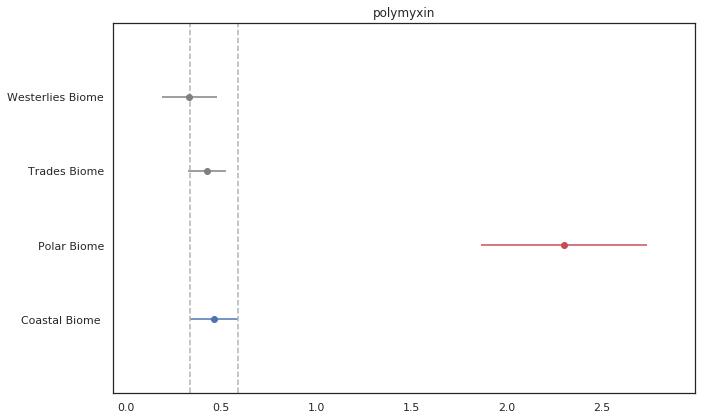

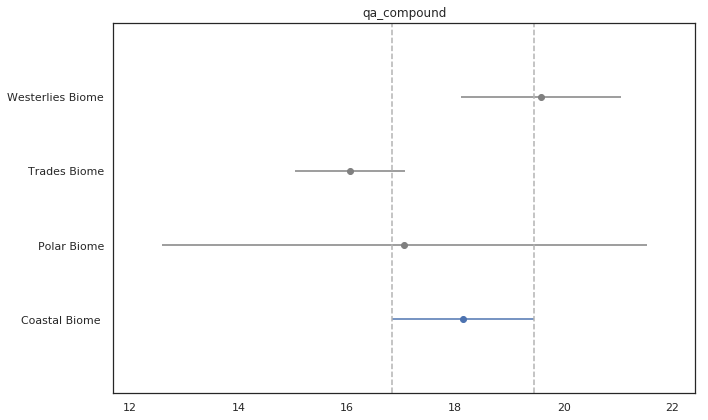

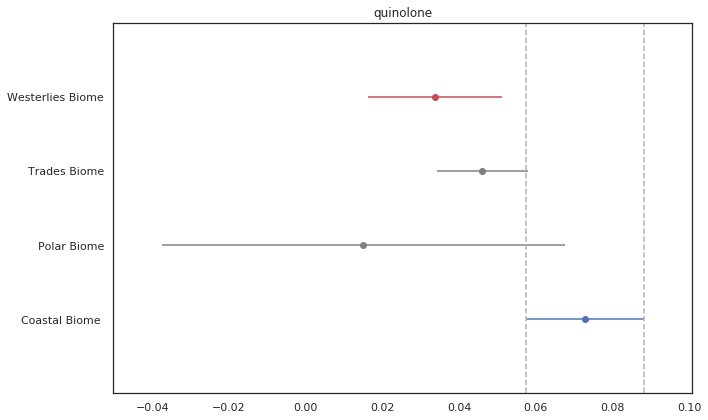

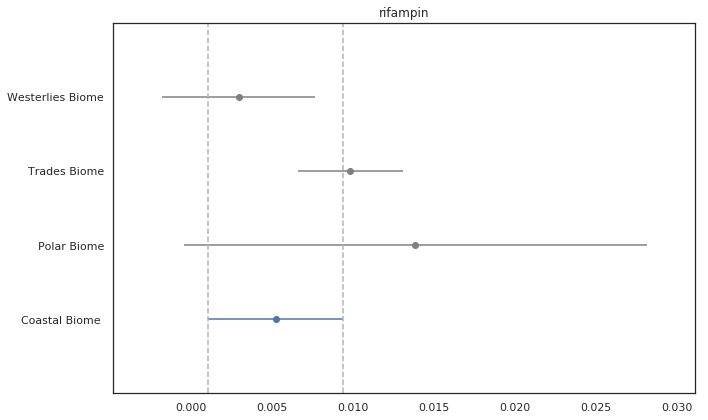

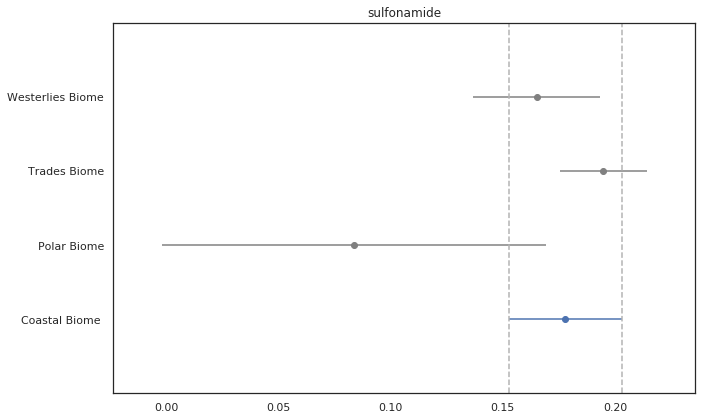

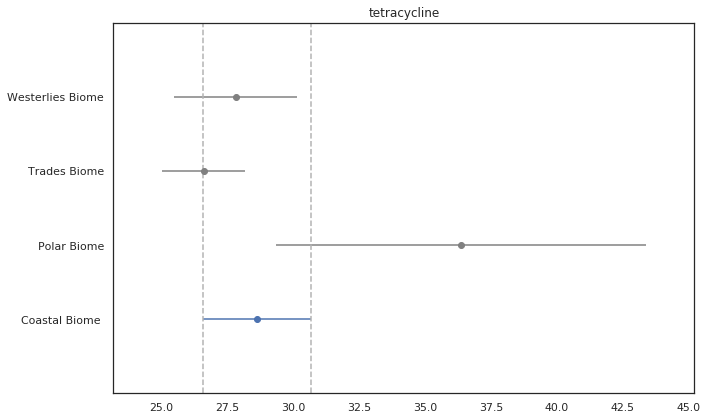

In [196]:
for e in env:
    pdf = matplotlib.backends.backend_pdf.PdfPages(out+"tukey_class_FPKM_"+e +".pdf")

    all_c=pd.DataFrame()
    classes=list(classes_RPKG_env_novirus.columns)[0:-6]
    for c in classes:
        #print c

        tukey = pairwise_tukeyhsd(endog=classes_RPKG_env_novirus[c],     # Data
                                  groups=classes_RPKG_env_novirus[e],   # Groups
                                  alpha=0.05)          # Significance level

        fig=tukey.plot_simultaneous(comparison_name=classes_RPKG_env_novirus[e][0])    # Plot group confidence intervals
        plt.title(c)
        plt.tight_layout()
        pdf.savefig( fig )
        #plt.show()
        df=tukey.summary()
        res=pd.DataFrame(df.data[1:],columns=df.data[0])
        res["class"]=str(c)
        res["env"]=str(e)
        all_c=pd.concat([all_c,res])
        all_c.to_excel(out+"/tukey_class_tests_FPKM_" +e +".xlsx",index=None)
        
    pdf.close()
    plt.close()

In [197]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

/home/rcuadrat/.local/lib/python2.7/site-packages/statsmodels/base/model.py:1532: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2

/home/rcuadrat/.local/lib/python2.7/site-packages/statsmodels/base/model.py:1532: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2

/home/rcuadrat/.local/lib/python2.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/rcuadrat/.local/lib/python2.7/site-packages/statsmodels/base/model.py:1532: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2

/home/rcuadrat/.local/lib/python2.7/site-packages/statsmodels/base

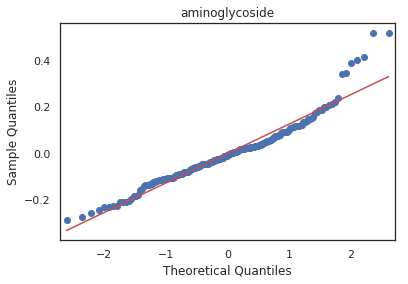

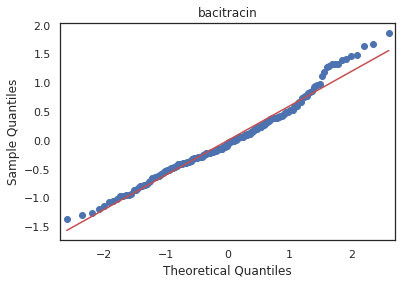

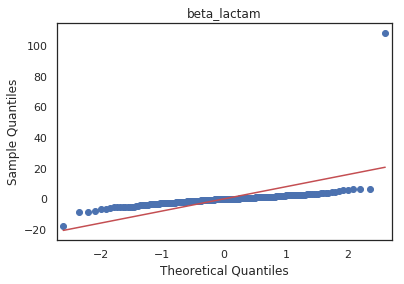

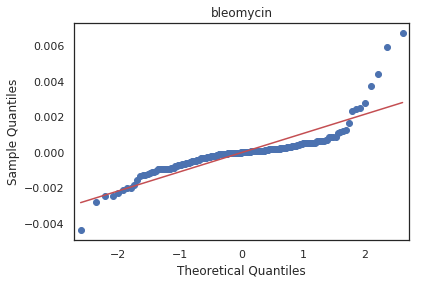

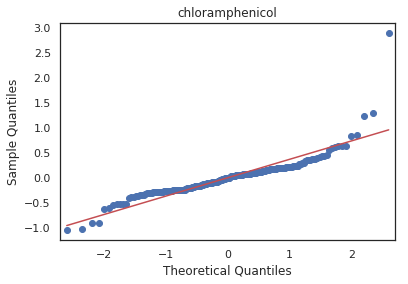

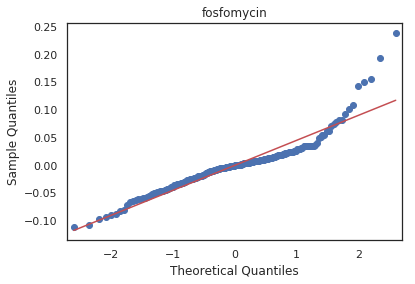

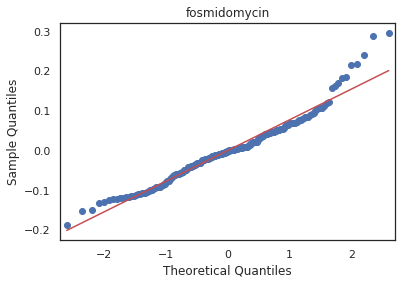

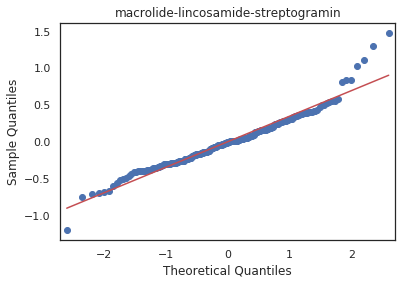

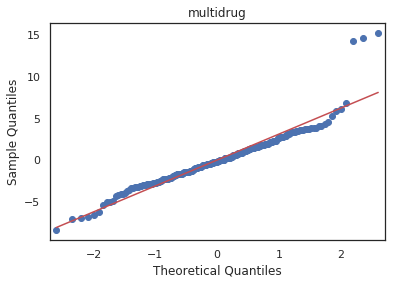

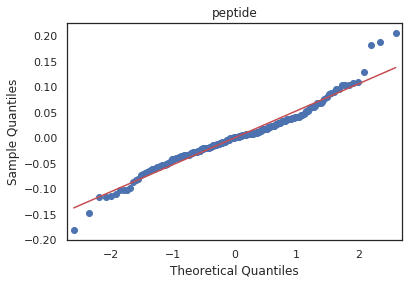

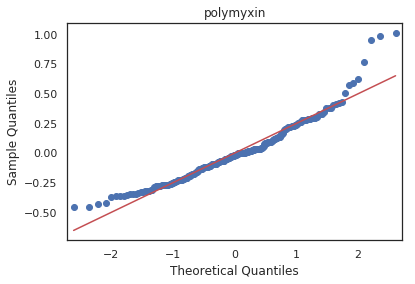

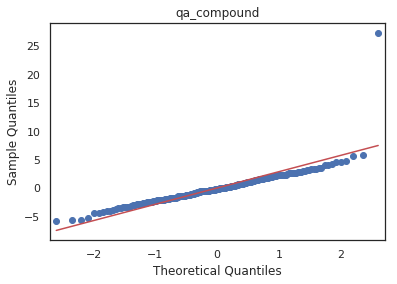

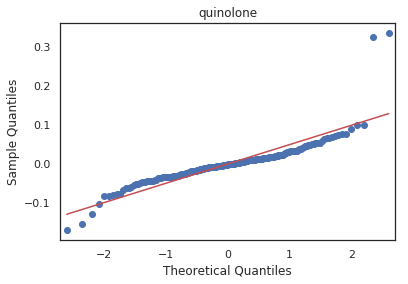

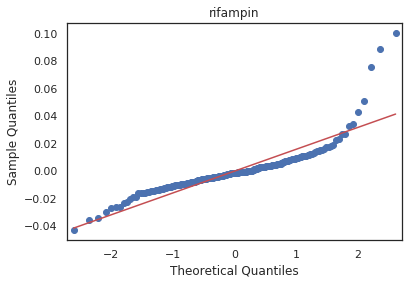

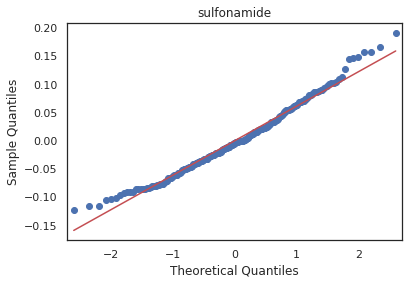

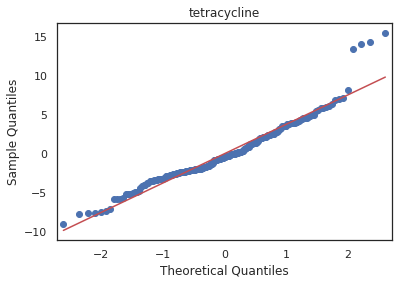

In [201]:
ols_df=classes_RPKG_env_novirus
ols_df=pd.merge(ols_df,meta[['Latitude [degrees North]', u'Longitude [degrees East]','run_id','NO2 [umol/L]**','PO4 [umol/L]**',
       u'NO2NO3 [umol/L]**', u'SI [umol/L]**','miTAG.SILVA.Taxo.Richness',
       u'miTAG.SILVA.Phylo.Diversity', u'miTAG.SILVA.Chao', u'miTAG.SILVA.ace',
       u'miTAG.SILVA.Shannon', u'OG.Shannon', u'OG.Richness', u'OG.Evenness',
       u'FC - heterotrophs [cells/mL]', u'FC - autotrophs [cells/mL]',
       u'FC - bacteria [cells/mL]', u'FC - picoeukaryotes [cells/mL]']],on="run_id")
ols_df.rename(columns={"Latitude [degrees North]":"Latitude","Longitude [degrees East]":"Longitude",
                       "Date/Time [yyyy-mm-ddThh:mm]":"Data_Time","NO2NO3 [umol/L]**":"NO2NO3",
                       "NO2 [umol/L]**":"NO2","PO4 [umol/L]**":"PO4",
                       "SI [umol/L]**":"SI","FC - heterotrophs [cells/mL]":"FC_heterotrophs_cells.mL",
                      "FC - autotrophs [cells/mL]":"FC_autotrophs_cells.mL","FC - bacteria [cells/mL]":"FC_bacteria_cells.mL",
                      "FC - picoeukaryotes [cells/mL]":"FC_picoeukaryotes_cells.mL"},inplace=True)
ols_df.drop("run_id",axis=1,inplace=True)

#'Date/Time [yyyy-mm-ddThh:mm]'
ols_df.columns=ols_df.columns.str.replace(r".", "_").str.replace(r"-", "_")
par=list(ols_df.columns)
parameters=[x for x in par if x not in classes]
parameters.remove("macrolide_lincosamide_streptogramin")
#parameters.remove("multidrug_mutation")

formula1="+".join(parameters)
# OLS with all the metadata 
reg3 = pd.DataFrame()
reg3_ = pd.DataFrame()
aov=pd.DataFrame()
pdf = matplotlib.backends.backend_pdf.PdfPages(out+"models_aov.pdf")
writer = pd.ExcelWriter(out+'aov_results.xlsx', engine='xlsxwriter')
writer2 = pd.ExcelWriter(out+'aov_results_significant.xlsx', engine='xlsxwriter')
classes=list(classes_RPKG_env.columns)[0:-6]
for c in classes:
    formula="%s ~ "%(c.replace(r"-", "_")) + formula1
    res = ols(formula, ols_df).fit()
    dfres={"coeficient":res.params,"p values":res.pvalues}
    ddd=pd.DataFrame(dfres)
    ddd["coeficient"]=ddd["coeficient"].apply(lambda x: "%.4f" % (x))
    ddd["variable"]=c.replace(r"-", "_")
    ddd["Formula"] = formula
    ddd["model p value"]=res.f_pvalue
    ddd["model Adjusted r squared"]=res.rsquared_adj
    ddd["r squared"]=res.rsquared
    #final result of OLS
    reg3=pd.concat([reg3,ddd],axis=0)
    
    reg3_ = reg3[(reg3["p values"] < 0.05) | (reg3["model p value"]< 0.05)] 
    reg3_["coeficient"]=reg3_["coeficient"].astype(float)
    reg3_ = reg3_.sort_values(by=["coeficient"],ascending=False)
    aov_table = anova_lm(res,typ=2)
    aov_table["classe"]=c
    
    eta_squared(aov_table)
    omega_squared(aov_table)
    #print(aov_table)
    aov_sig=aov_table[aov_table["PR(>F)"]<0.05]
    
    aov_table.to_excel(writer, sheet_name=c[0:30])
    aov_sig.to_excel(writer2, sheet_name=c[0:30])

    aov=pd.concat([aov,aov_table],axis=0)

    res_ = res.resid 
    fig = sm.qqplot(res_, line='s')
    plt.title(c)
    pdf.savefig( fig )
    
plt.close()
pdf.close()
writer.save()
writer2.save()

In [202]:
plt.show()

[0.44002853 0.32978189]


/home/rcuadrat/.local/lib/python2.7/site-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



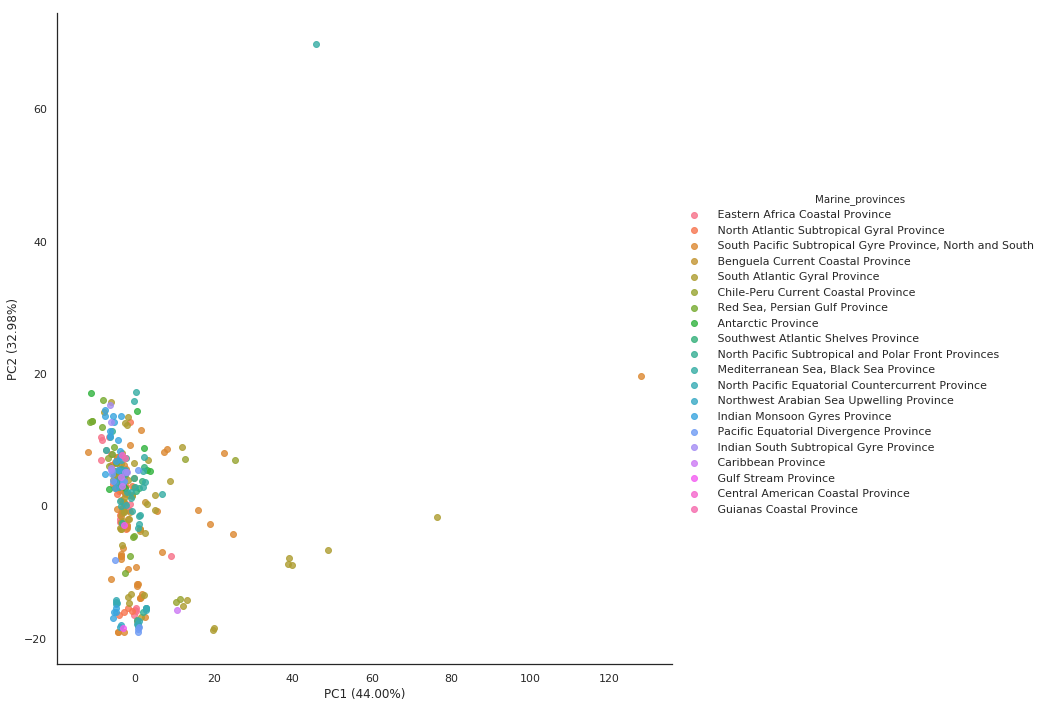

/home/rcuadrat/.local/lib/python2.7/site-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



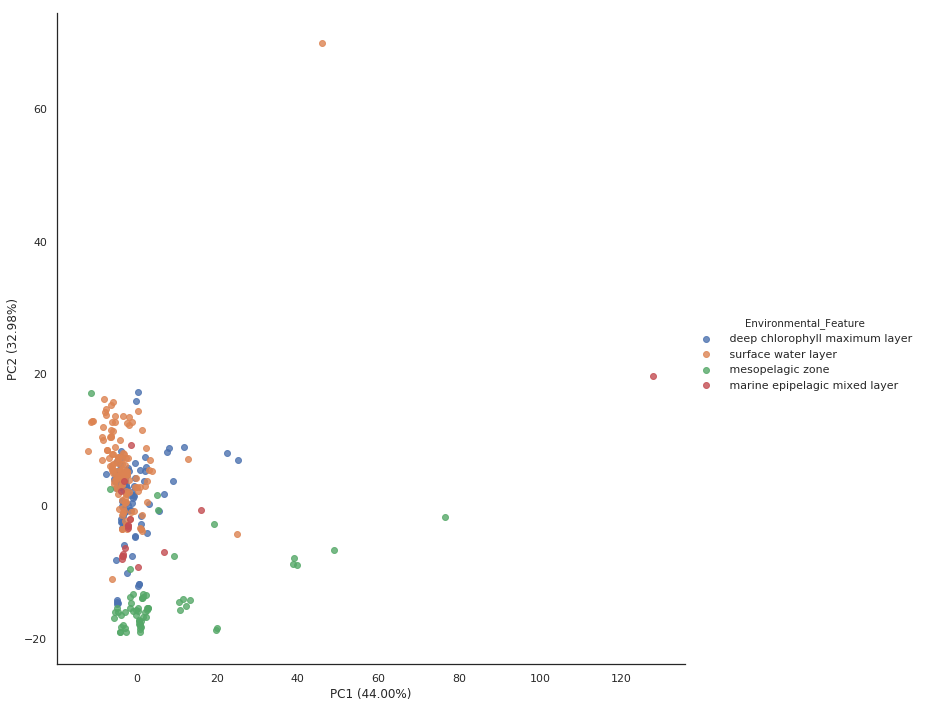

/home/rcuadrat/.local/lib/python2.7/site-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



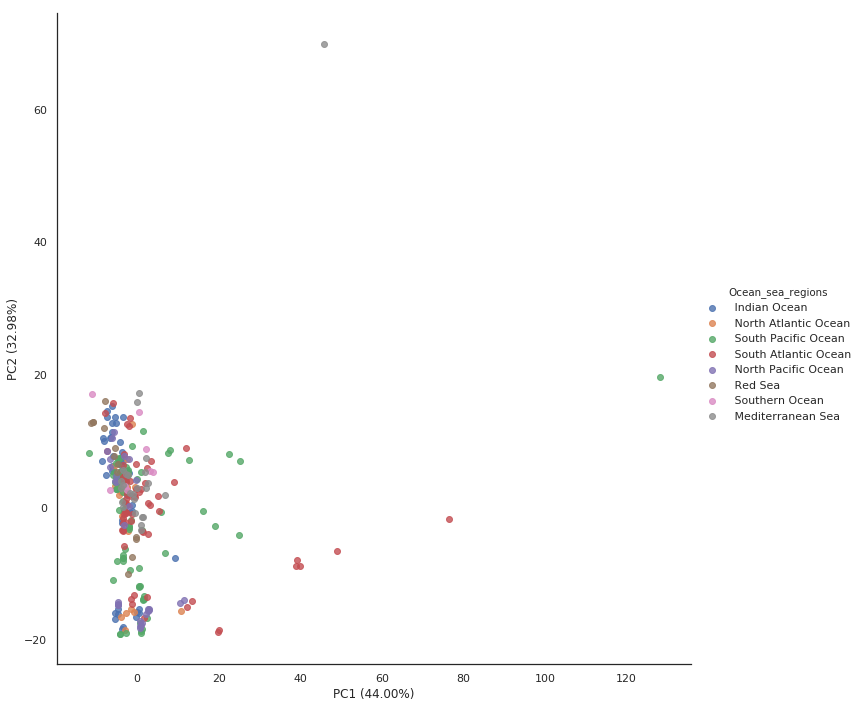

/home/rcuadrat/.local/lib/python2.7/site-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



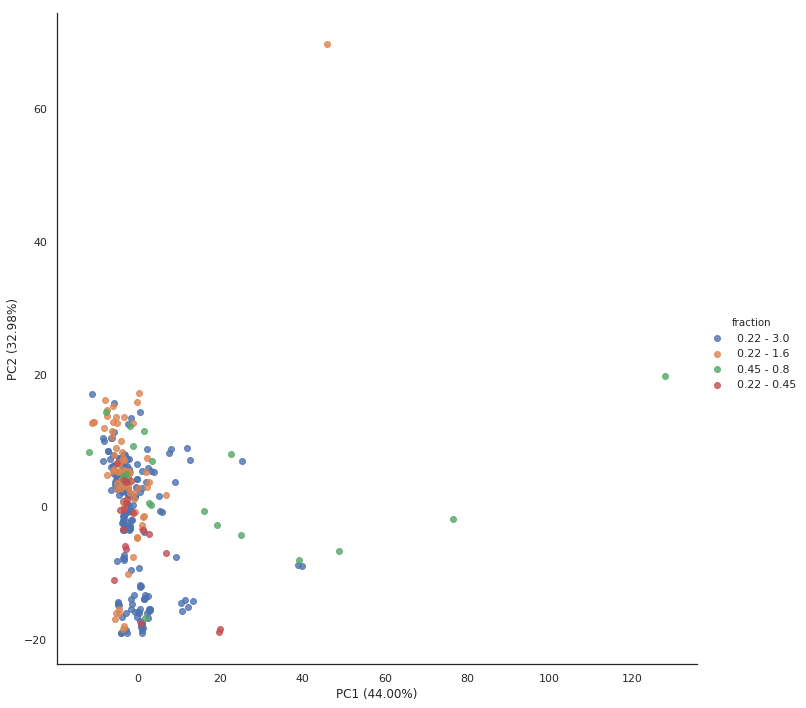

/home/rcuadrat/.local/lib/python2.7/site-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



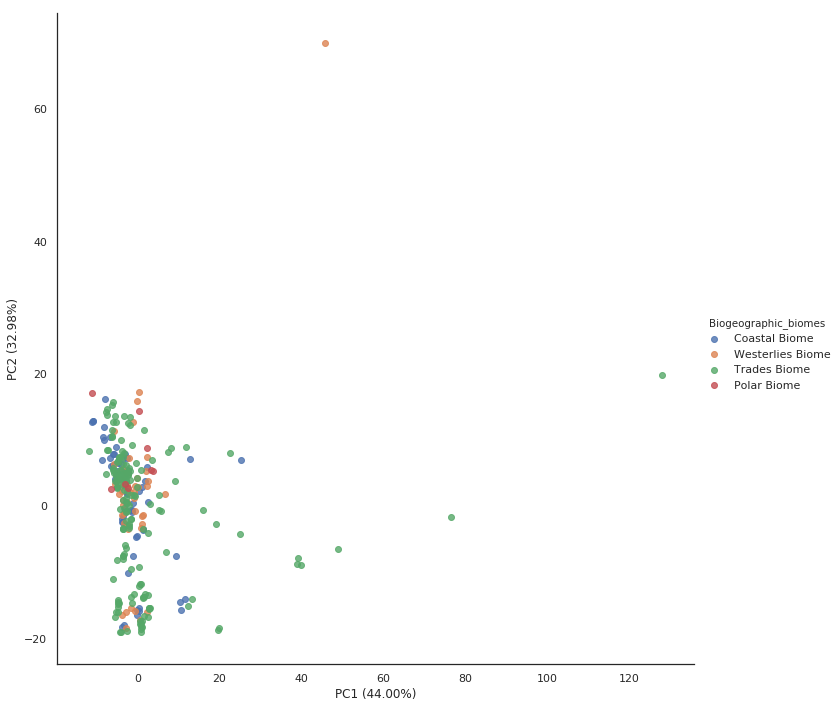

[0.27628184 0.13420284]


/home/rcuadrat/.local/lib/python2.7/site-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



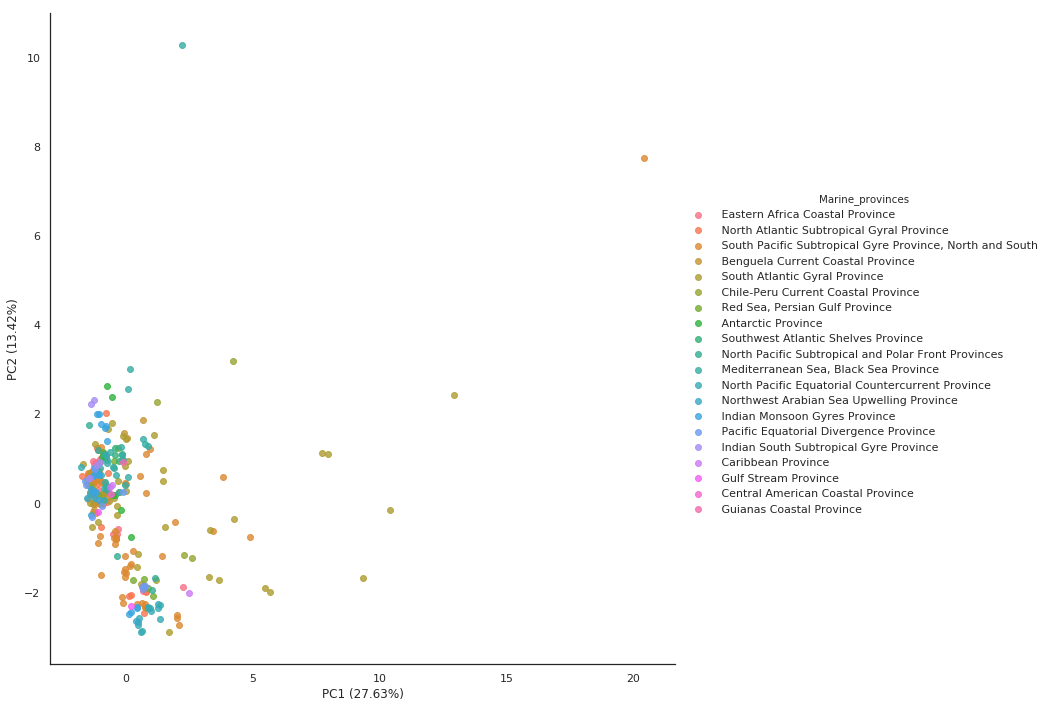

/home/rcuadrat/.local/lib/python2.7/site-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



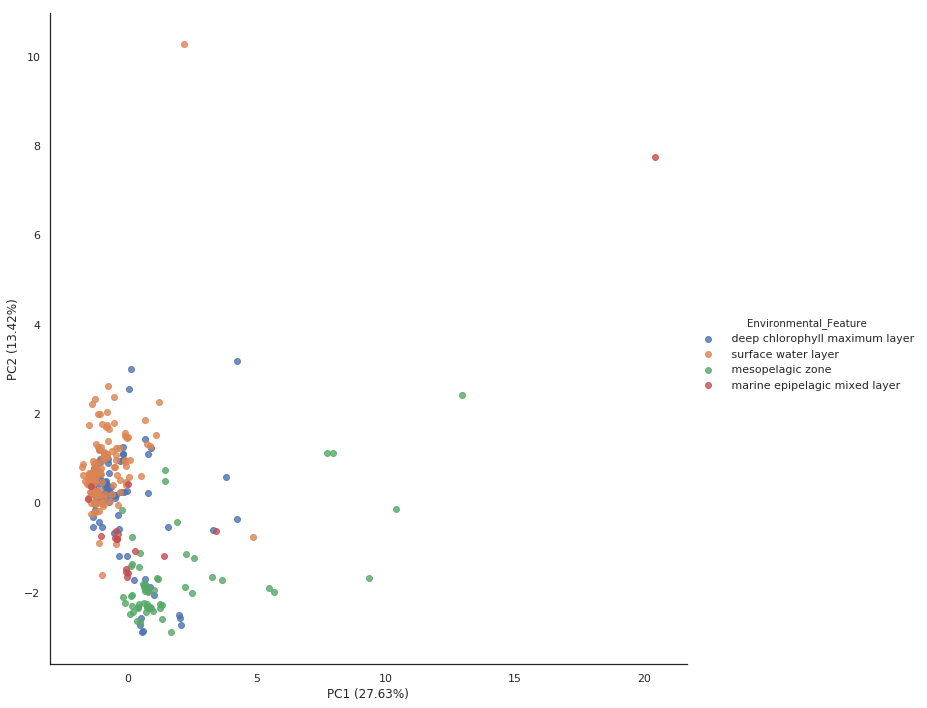

/home/rcuadrat/.local/lib/python2.7/site-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



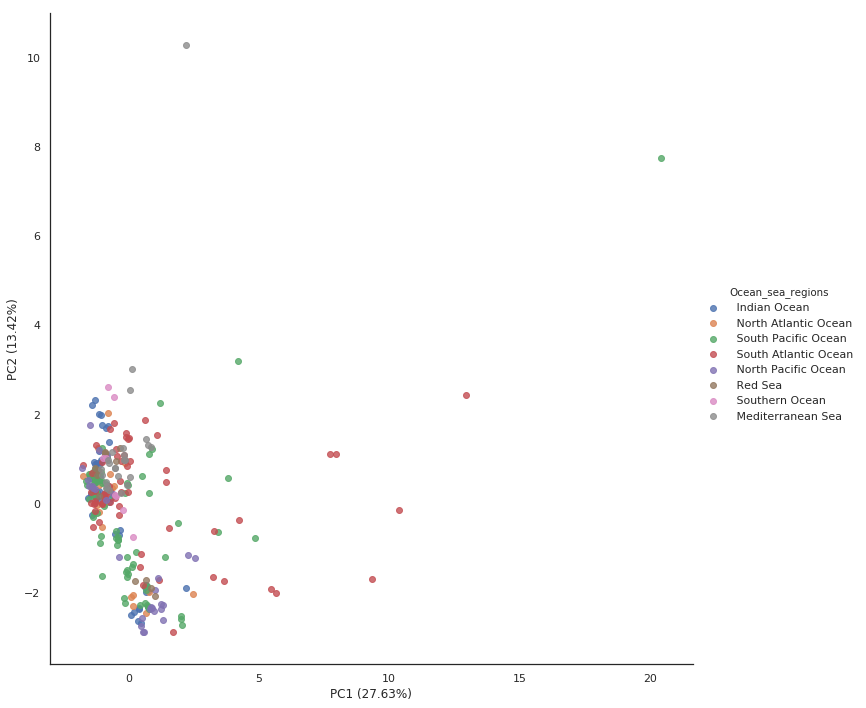

/home/rcuadrat/.local/lib/python2.7/site-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



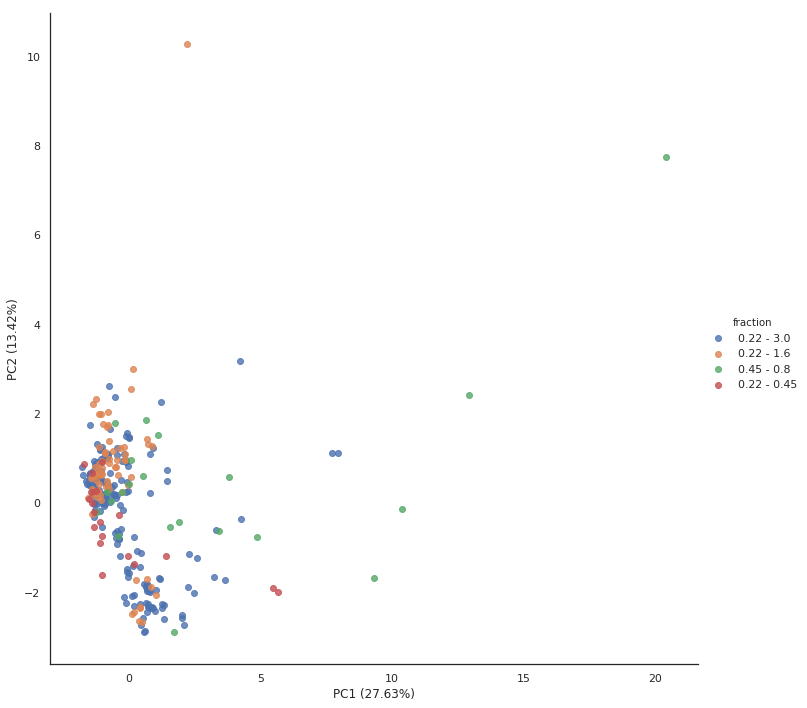

/home/rcuadrat/.local/lib/python2.7/site-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



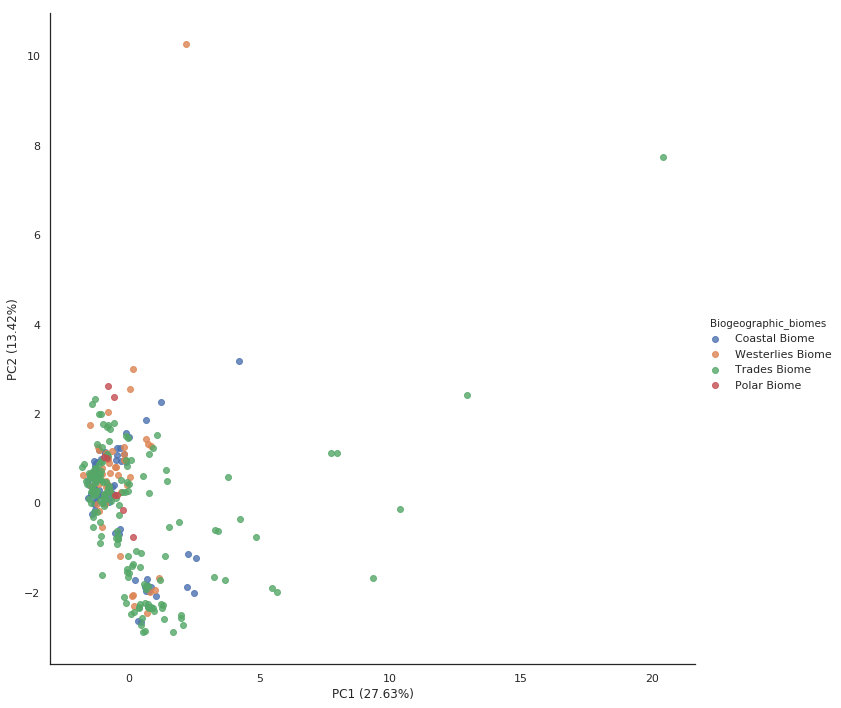

In [203]:
pcadf=classes_RPKG_env_novirus.set_index(['run_id', u'Marine_provinces',
       u'Environmental_Feature', u'Ocean_sea_regions', u'fraction',
       u'Biogeographic_biomes'])

pca = PCA(n_components=2)

##


pcadf_scaled = preprocessing.scale(pcadf)
#projected=pca.fit_transform(pcadf_scaled)
projected=pca.fit_transform(pcadf)

###
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)


aaa=pd.merge(pcadf.reset_index(),pd.DataFrame(projected),left_index=True,right_index=True)

aaa=aaa.rename(columns = {0:"0",1:"1"})

pdf = matplotlib.backends.backend_pdf.PdfPages(out+"PCA_not_scaled.pdf")
for e in env:
    hue=e
    sns.lmplot("0","1",data=aaa,hue=hue,size=10,fit_reg=False)
    plt.xlabel('PC1 ('+ str("{0:.2f}".format(pca.explained_variance_ratio_[0]*100))+ "%)" )
    plt.ylabel('PC2 ('+ str("{0:.2f}".format(pca.explained_variance_ratio_[1]*100))+ "%)" )
    pdf.savefig( fig )
    plt.show()
    plt.close()
pdf.close()

pca = PCA(n_components=2)

##


pcadf_scaled = preprocessing.scale(pcadf)
projected=pca.fit_transform(pcadf_scaled)

###
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)


aaa=pd.merge(pcadf.reset_index(),pd.DataFrame(projected),left_index=True,right_index=True)

aaa=aaa.rename(columns = {0:"0",1:"1"})

pdf = matplotlib.backends.backend_pdf.PdfPages(out+"PCA_scaled.pdf")
for e in env:
    hue=e
    sns.lmplot("0","1",data=aaa,hue=hue,size=10,fit_reg=False)
    plt.xlabel('PC1 ('+ str("{0:.2f}".format(pca.explained_variance_ratio_[0]*100))+ "%)" )
    plt.ylabel('PC2 ('+ str("{0:.2f}".format(pca.explained_variance_ratio_[1]*100))+ "%)" )
    pdf.savefig( fig )
    plt.show()
    plt.close()
pdf.close()

In [204]:
ARGS_RPKG=ARGS_RPKG[list(classes_RPKG_env_novirus["run_id"])]

In [205]:
meta=meta[meta["run_id"].isin(ARGS_RPKG[list(classes_RPKG_env_novirus["run_id"])])]

In [206]:
conditions=meta[["run_id","Marine_provinces","Environmental_Feature","Ocean_sea_regions","fraction","Biogeographic_biomes"]]
conditions.set_index("run_id",inplace=True)
con=list(conditions.columns)
ARGS_RPKG=ARGS_RPKG[(ARGS_RPKG.T != 0).any()]
genes=list(set(ARGS_RPKG.reset_index()["#ARG"]))

In [207]:
all_fc=pd.DataFrame()
for g in con:
    groups=list(set(conditions[g].values))
    a=list(itertools.combinations(groups,2))
    for i in a:
        g1=list(conditions[conditions[g]==i[0]].index)
        g2=list(conditions[conditions[g]==i[1]].index)
        fc=np.log2((ARGS_RPKG[g1].mean(axis=1)+0.000001)/(ARGS_RPKG[g2].mean(axis=1)+0.000001))
        tmp=pd.DataFrame(fc)
        tmp.columns=["log2 FC"]
        tmp["g1"]=str(i[0])
        tmp["g2"]=str(i[1])
        tmp["param"]=str(g)
        tmp["mean_g1"]=ARGS_RPKG[g1].mean(axis=1)
        tmp["mean_g2"]=ARGS_RPKG[g2].mean(axis=1)
        tmp["std_g1"]=ARGS_RPKG[g1].std(axis=1)
        tmp["std_g2"]=ARGS_RPKG[g2].std(axis=1)
        
        F_a = []
        p_a = []
        for ge in genes:
            #one way ANOVA test
            F, p = ss.f_oneway(ARGS_RPKG[g1].T[ge],ARGS_RPKG[g2].T[ge])
            F_a.append(F)
            p_a.append(p)
        tmp["ANOVA F"] = F_a
        tmp["ANOVA pvalue"] = p_a
        p_adjusted= multipletests(p_a, method='bonferroni')
        tmp["pvalue adjusted"] = p_adjusted[1]
        all_fc=pd.concat([all_fc,tmp])

    
all_fc_sig=all_fc[all_fc["pvalue adjusted"]<0.05]
all_fc_sig["comp"]=all_fc_sig["g1"]+" / "+all_fc_sig["g2"]  
#all_fc_sig.drop(["g1","g2"],axis=1)

for g in con:
    writer = pd.ExcelWriter(out+'log2FC_anova_results_' +g +  '.xlsx', engine='xlsxwriter')
    t=all_fc_sig[all_fc_sig["param"]==g]
    for i in list(set(all_fc_sig["comp"])):
        t_=t[t["comp"]==i]
        t_.to_excel(writer, sheet_name=i[0:30].replace(" / ","_"))
    writer.save()

/home/rcuadrat/.local/lib/python2.7/site-packages/scipy/stats/stats.py:2961: RuntimeWarning:

invalid value encountered in double_scalars

/home/rcuadrat/.local/lib/python2.7/site-packages/statsmodels/stats/multitest.py:147: RuntimeWarning:

invalid value encountered in less_equal

/home/rcuadrat/.local/lib/python2.7/site-packages/statsmodels/stats/multitest.py:251: RuntimeWarning:

invalid value encountered in greater

/home/rcuadrat/.local/lib/python2.7/site-packages/scipy/stats/stats.py:2961: RuntimeWarning:

divide by zero encountered in double_scalars

/home/rcuadrat/.local/lib/python2.7/site-packages/scipy/stats/stats.py:2960: RuntimeWarning:

invalid value encountered in double_scalars

/home/rcuadrat/.local/lib/python2.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [208]:
ARGS_RPKG_=ARGS_RPKG.T.reset_index().rename(columns={"index":"run_id"})
ARGS_RPKG_env=pd.merge(ARGS_RPKG_,meta[["run_id","Marine_provinces","Environmental_Feature","Ocean_sea_regions","fraction","Biogeographic_biomes"]],on="run_id")


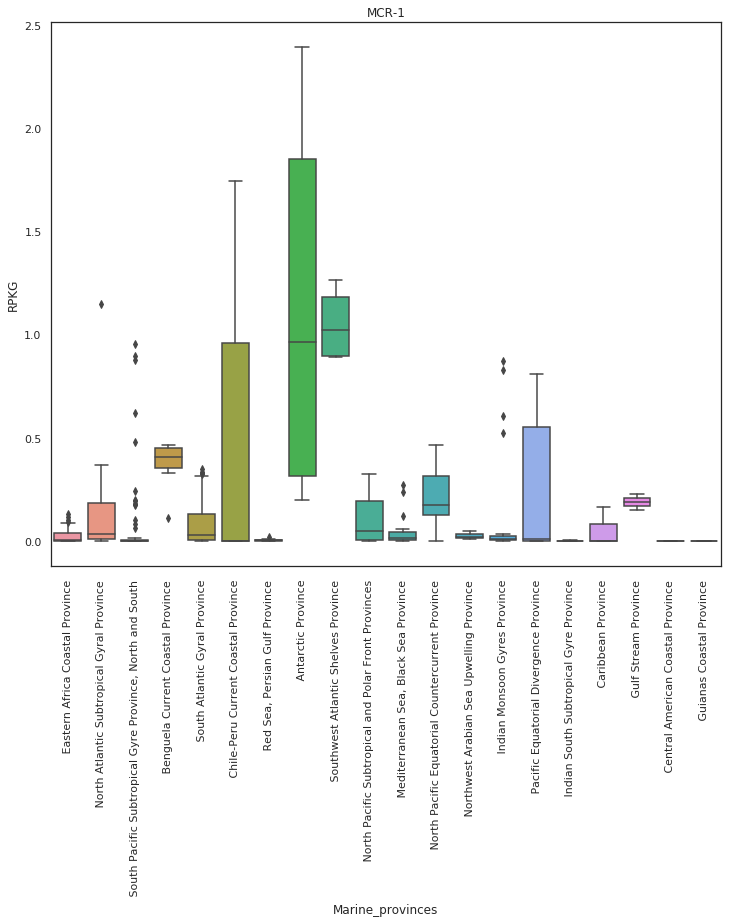

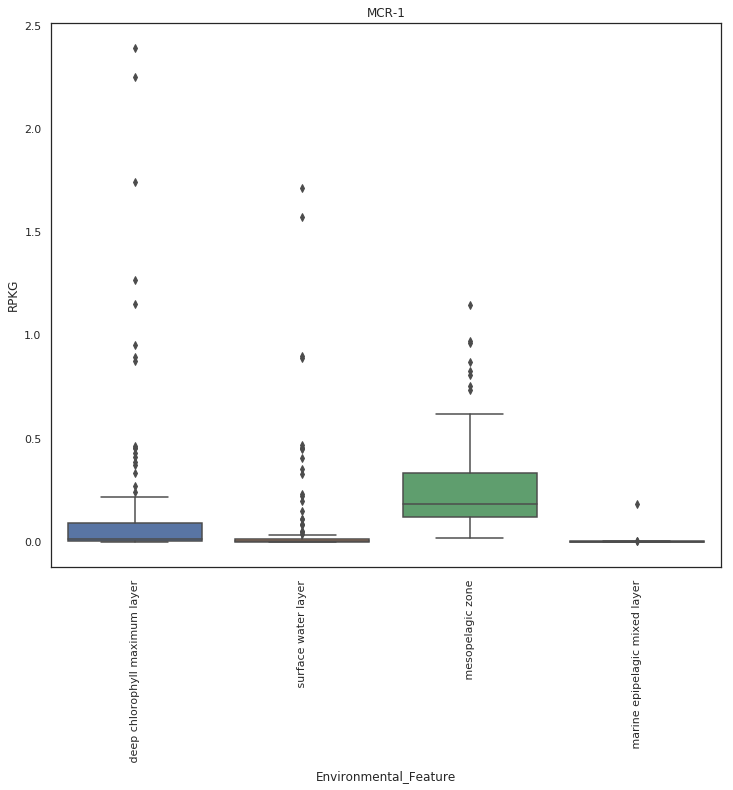

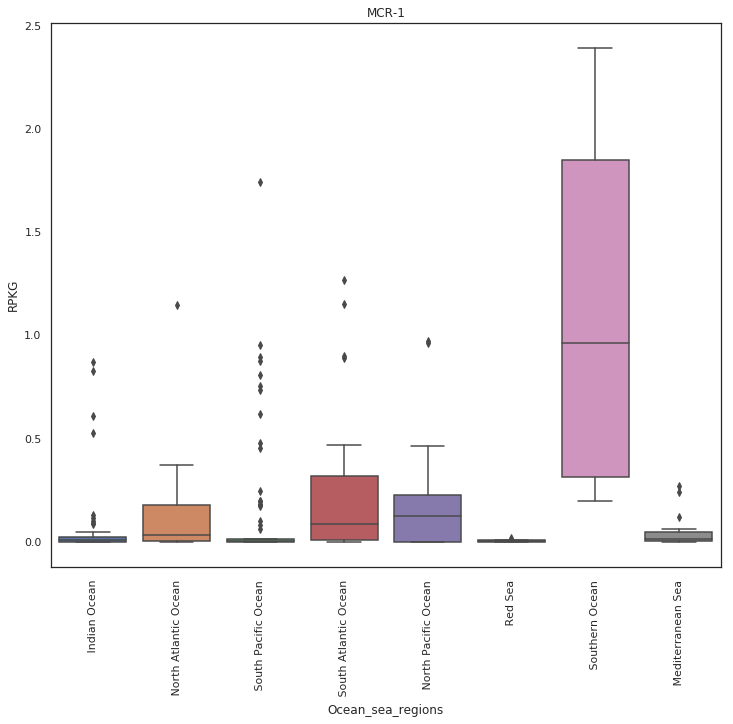

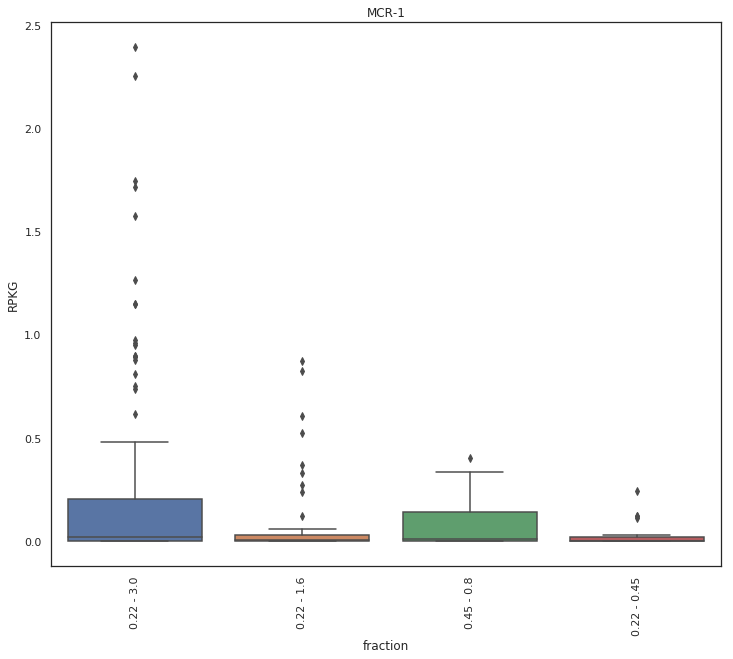

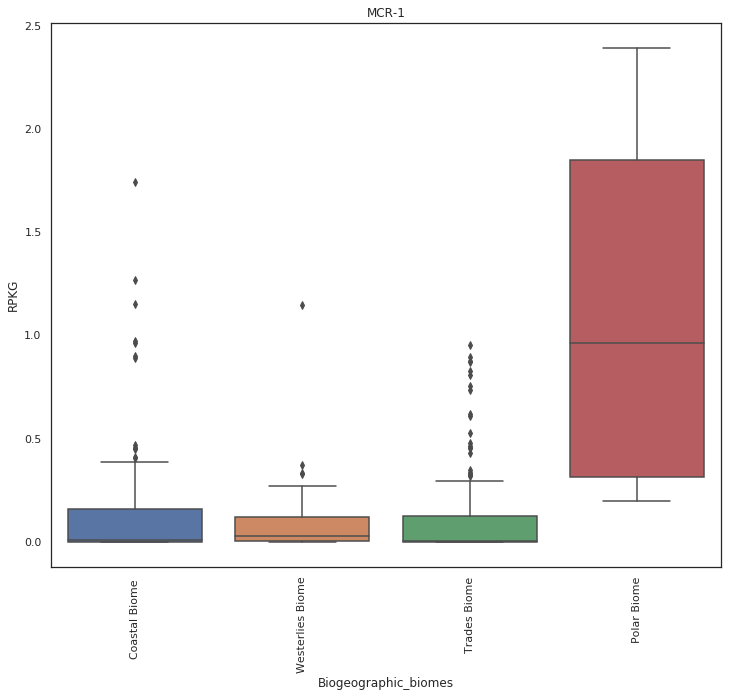

In [209]:
pdf = matplotlib.backends.backend_pdf.PdfPages(out+"boxplots_MCR1.pdf")
for e in env:
    fig=plt.figure(figsize=(12,10))
    sns.boxplot(ARGS_RPKG_env[e],ARGS_RPKG_env["MCR-1"])
    plt.xticks(rotation=90)
    plt.ylabel("RPKG")
    plt.title("MCR-1")
    pdf.savefig(fig)
    plt.show()
pdf.close()

In [210]:
set(aov["classe"])

{'aminoglycoside',
 'bacitracin',
 'beta_lactam',
 'bleomycin',
 'chloramphenicol',
 'fosfomycin',
 'fosmidomycin',
 'macrolide-lincosamide-streptogramin',
 'multidrug',
 'peptide',
 'polymyxin',
 'qa_compound',
 'quinolone',
 'rifampin',
 'sulfonamide',
 'tetracycline',
 'triclosan'}

In [211]:
poly=aov[aov["classe"]=="polymyxin"]

In [212]:
poly[poly["PR(>F)"]<0.05]

sum_sq    df          F        PR(>F)  \
Marine_provinces            10.260621  19.0   6.981460  1.308840e-13   
Environmental_Feature        0.721769   3.0   3.110304  2.776709e-02   
Ocean_sea_regions            3.425019   7.0   6.325446  1.234726e-06   
fraction                     1.785515   3.0   7.694288  6.259011e-04   
Biogeographic_biomes         6.339993   3.0  27.320821  1.482037e-14   
PO4                          1.493502   1.0  19.307771  1.918251e-05   
SI                           2.363679   1.0  30.557275  1.153469e-07   
miTAG_SILVA_ace              0.337342   1.0   4.361100  3.820778e-02   
miTAG_SILVA_Shannon          0.612285   1.0   7.915527  5.458798e-03   
OG_Shannon                   0.345389   1.0   4.465134  3.600324e-02   
OG_Richness                  0.473326   1.0   6.119083  1.432131e-02   
OG_Evenness                  0.696667   1.0   9.006409  3.081243e-03   
FC_picoeukaryotes_cells_mL   1.084374   1.0  14.018622  2.449692e-04   

                               classe    eta_sq  omega_sq  
Marine_provinces            polymyxin  0.231448  0.197951  
Environmental_Feature       polymyxin  0.016281  0.011027  
Ocean_sea_regions           polymyxin  0.077258  0.064931  
fraction                    polymyxin  0.040276  0.034980  
Biogeographic_biomes        polymyxin  0.143011  0.137536  
PO4                         polymyxin  0.033689  0.031888  
SI                          polymyxin  0.053317  0.051483  
miTAG_SILVA_ace             polymyxin  0.007609  0.005854  
miTAG_SILVA_Shannon         polymyxin  0.013811  0.012045  
OG_Shannon                  polymyxin  0.007791  0.006036  
OG_Richness                 polymyxin  0.010677  0.008916  
OG_Evenness                 polymyxin  0.015715  0.013945  
FC_picoeukaryotes_cells_mL  polymyxin  0.024460  0.022676

In [213]:
from  scipy.stats import spearmanr 

In [214]:
rho,pvalue=spearmanr(ARGS_RPKG.T)
pv_df=pd.DataFrame(pvalue)
rho_df=pd.DataFrame(rho)
corrr=ARGS_RPKG.T.corr(method='spearman')
corrr.to_csv(out+"ARGS_RPKG_spearman_corr.tsv",sep="\t")

In [215]:
pv_df.columns=[list(ARGS_RPKG.T.columns)]

In [216]:
pv_df.T.reset_index().to_csv(out+"ARGS_RPKG_spearman_pvalue.tsv",sep="\t")